In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import LabelEncoder

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/dataset/creditCardFraud/credit_card_transactions-ibm_v2.csv',nrows=6000000)
#sd_cards=pd.read_csv('/content/drive/MyDrive/dataset/creditCardFraud/sd254_cards.csv')
#sd_users=pd.read_csv('/content/drive/MyDrive/dataset/creditCardFraud/sd254_users.csv')

In [ ]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No


In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24386900 entries, 0 to 24386899
Data columns (total 15 columns):
 #   Column          Dtype  
---  ------          -----  
 0   User            int64  
 1   Card            int64  
 2   Year            int64  
 3   Month           int64  
 4   Day             int64  
 5   Time            object 
 6   Amount          object 
 7   Use Chip        object 
 8   Merchant Name   int64  
 9   Merchant City   object 
 10  Merchant State  object 
 11  Zip             float64
 12  MCC             int64  
 13  Errors?         object 
 14  Is Fraud?       object 
dtypes: float64(1), int64(7), object(7)
memory usage: 2.7+ GB


In [ ]:
df['Is Fraud?']=df['Is Fraud?'].replace({'No':0,'Yes':1}) 

In [ ]:
y=df['Is Fraud?'] 
df.drop('Is Fraud?',axis=1,inplace=True)

In [ ]:
le=LabelEncoder() 
df['Amount'] = df['Amount'].apply(lambda value: float(value.split("$")[1]))
df['Use Chip']=le.fit_transform(df['Use Chip'])
df['Merchant State'].fillna('NAN', inplace=True)
df['Merchant State']=le.fit_transform(df['Merchant State'])
df['Merchant City']=le.fit_transform(df['Merchant City'])

df['Errors?'].fillna('NAN', inplace=True)
df['Errors?']=le.fit_transform(df['Errors?'])

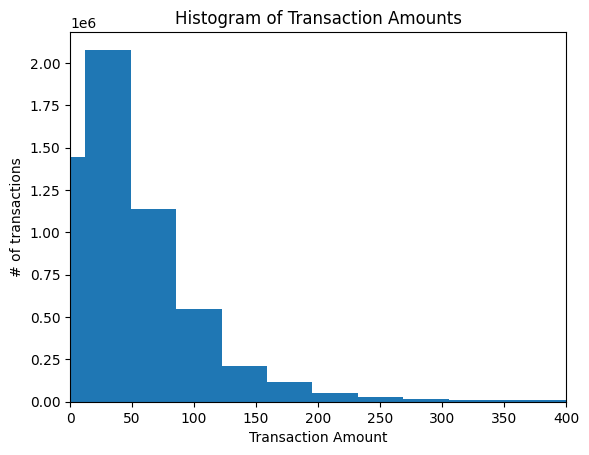

In [ ]:
#Гистограмма транзакций
plt.hist(df['Amount'], bins=200)
plt.xlabel('Transaction Amount')
plt.xlim(0, 400)  
plt.ylabel('# of transactions')
plt.title('Histogram of Transaction Amounts')
plt.show()

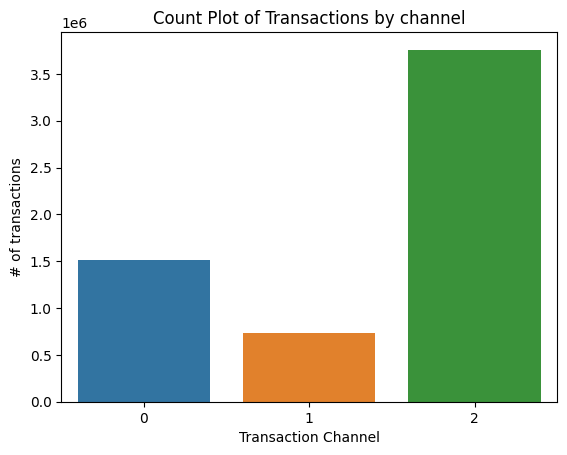

In [ ]:
sns.countplot(x='Use Chip', data=df)
plt.xlabel('Transaction Channel')
plt.ylabel('# of transactions')
plt.title('Count Plot of Transactions by channel')
plt.show()
#

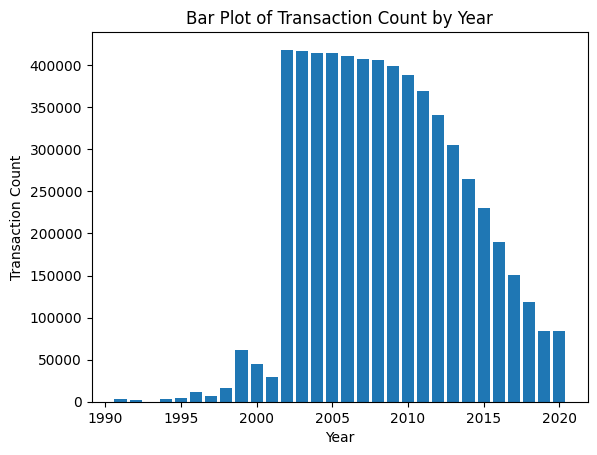

In [ ]:
plt.bar(df['Year'].unique(), df['Year'].value_counts())
plt.xlabel('Year')
plt.ylabel('Transaction Count')
plt.title('Bar Plot of Transaction Count by Year')
plt.show()

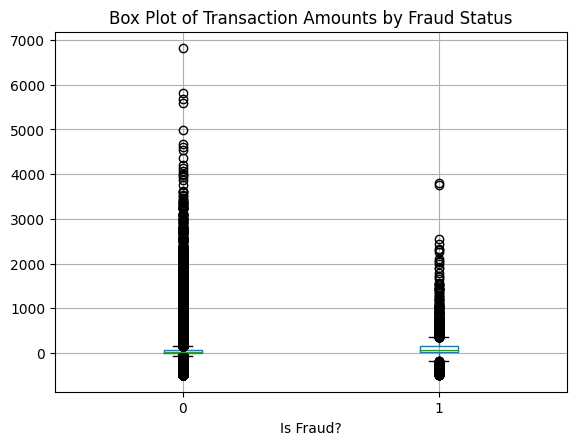

In [ ]:
#Transaction amount by fraud
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')
df.boxplot(column='Amount', by='Is Fraud?')
plt.title('Box Plot of Transaction Amounts by Fraud Status')
plt.suptitle('')
plt.show()

In [ ]:
df.isnull().sum()

User                     0
Card                     0
Year                     0
Month                    0
Day                      0
Time                     0
Amount                   0
Use Chip                 0
Merchant Name            0
Merchant City            0
Merchant State     2720821
Zip                2878135
MCC                      0
Errors?           23998469
Is Fraud?                0
dtype: int64

In [ ]:
le = LabelEncoder()

# Замена пропущенных значений на токен "UNK"
df['Zip'].fillna('UNK', inplace=True)

df['Zip'] = df['Zip'].apply(lambda x: str(x) if isinstance(x, float) else x)

# Кодирование значений zip code в числовой формат
#df['zip_code_encoded'] = le.fit_transform(df['Zip'])

# Создание слоя эмбеддинга в PyTorch
num_zip_codes = len(le.classes_)
emb_size = 10
zip_emb = torch.nn.Embedding(num_embeddings=num_zip_codes + 1, embedding_dim=emb_size)

# Индекс токена "UNK" в эмбеддинге
unk_idx = num_zip_codes

# Получение эмбеддинга для конкретного значения zip code
def get_zip_emb(zip_code):
    if zip_code in le.classes_:
        return zip_emb(torch.tensor([le.transform([zip_code])[0]]))
    else:
        return zip_emb(torch.tensor([unk_idx]))

unique_zip_codes = df['zip_code_encoded'].unique()
embeddings = get_zip_emb(unique_zip_codes)
zip_code_embedding_mapping = dict(zip(unique_zip_codes, embeddings.tolist()))
df['zip_code_embedding'] = df['zip_code_encoded'].map(zip_code_embedding_mapping)    



In [ ]:
df.head()

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,zip_code_encoded,zip_code_embedding
0,0,0,2002,9,1,06:21,134.09,2,3527213246127876953,4876,17,91750.0,5300,21,18705,"[-0.35894232988357544, -1.0936939716339111, 1...."
1,0,0,2002,9,1,06:42,38.48,2,-727612092139916043,6076,17,91754.0,5411,21,18707,NaN
2,0,0,2002,9,2,06:22,120.34,2,-727612092139916043,6076,17,91754.0,5411,21,18707,NaN
3,0,0,2002,9,2,17:45,128.95,2,3414527459579106770,6076,17,91754.0,5651,21,18707,NaN
4,0,0,2002,9,3,06:23,104.71,2,5817218446178736267,4876,17,91750.0,5912,21,18705,"[-0.35894232988357544, -1.0936939716339111, 1...."


In [ ]:

def value_split_transform(df, column):
  df[column] = df[column].apply(lambda value: float(value.split("$")[1] if isinstance(value, str) else value))
  return df

def fillna_transform(df, column):
  df[column].fillna('NAN', inplace=True)
  return df

def label_encoder(df, column):
  le = LabelEncoder()
  df[column] = df[column].apply(lambda x: str(x) if isinstance(x, (float,int)) else x)
  df[column] = le.fit_transform(df[column])
  return df

def date_transform(df, column):
  # Преобразуем столбцы "year", "month" и "day" в тип datetime64[ns]
  dt = pd.to_datetime(df[column[:3]])

  # Преобразуем datetime64[ns] в POSIX-время
  df['timestamp'] = dt.values.astype(int) // 10 ** 9

  # Преобразуем столбец "time" в тип datetime64[ns]
  df['datetime'] = pd.to_datetime(df[column[-1]], format='%H:%M')

  # Преобразуем datetime64[ns] в POSIX-время и добавляем к "timestamp"
  df['timestamp'] += df['datetime'].apply(lambda x: x.timestamp()).astype(int)

  return df

In [ ]:
# Преобразуем столбцы "year", "month" и "day" в тип datetime64[ns]
dt = pd.to_datetime(df[['Year', 'Month', 'Day']])

# Преобразуем datetime64[ns] в POSIX-время
df['timestamp'] = dt.values.astype(int) // 10 ** 9

# Преобразуем столбец "time" в тип datetime64[ns]
df['datetime'] = pd.to_datetime(df['Time'], format='%H:%M')

# Преобразуем datetime64[ns] в POSIX-время и добавляем к "timestamp"
df['timestamp'] += df['datetime'].apply(lambda x: x.timestamp()).astype(int)

df.drop(['Year','Month','Day','Time','datetime'], axis=1, inplace=True)  

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer as FT

steps = [
    ('value_split_transform', FT(value_split_transform, kw_args={'column':'Amount'})),
    ('fillna_MerchantState', FT(fillna_transform, kw_args={'column':'Merchant State'})),
    ('fillna_Errors', FT(fillna_transform, kw_args={'column':'Errors?'})),
    ('label_encoder_UseChip', FT(label_encoder, kw_args={'column':'Use Chip'})),
    ('label_encoder_Errors', FT(label_encoder, kw_args={'column':'Errors?'})),
    ('label_encoder_MerchantState', FT(label_encoder, kw_args={'column':'Merchant State'})),
    ('label_encoder_MerchantCity', FT(label_encoder, kw_args={'column':'Merchant City'})),
    ('fillna_Zip', FT(fillna_transform, kw_args={'column':'Zip'})),
    ('label_encoder_Zip', FT(label_encoder, kw_args={'column':'Zip'})),
    ('date_transform', FT(date_transform, kw_args={'column':['Year', 'Month', 'Day','Time']}))
]
preprocessing_pipeline = Pipeline(steps)

In [ ]:
transformed_df = preprocessing_pipeline.fit_transform(df)

In [ ]:
import joblib
joblib.dump(preprocessing_pipeline, 'preprocessing_pipeline.pkl')

['preprocessing_pipeline.pkl']

In [ ]:
df.head()

,User,Card,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,timestamp
0,0,0,134.09,2,3527213246127876953,4876,17,18705,5300,21,-1178127540
1,0,0,38.48,2,-727612092139916043,6076,17,18707,5411,21,-1178126280
2,0,0,120.34,2,-727612092139916043,6076,17,18707,5411,21,-1178041080
3,0,0,128.95,2,3414527459579106770,6076,17,18707,5651,21,-1178000100
4,0,0,104.71,2,5817218446178736267,4876,17,18705,5912,21,-1177954620


In [ ]:
df.drop(['Year','Month','Day','Time','datetime'], axis=1, inplace=True)

In [ ]:
df.head()

,User,Card,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,MCC,Errors?,Is Fraud?,zip_code_encoded,timestamp
0,0,0,134.09,2,3527213246127876953,4876,17,5300,21,0,18705,-1178127540
1,0,0,38.48,2,-727612092139916043,6076,17,5411,21,0,18707,-1178126280
2,0,0,120.34,2,-727612092139916043,6076,17,5411,21,0,18707,-1178041080
3,0,0,128.95,2,3414527459579106770,6076,17,5651,21,0,18707,-1178000100
4,0,0,104.71,2,5817218446178736267,4876,17,5912,21,0,18705,-1177954620


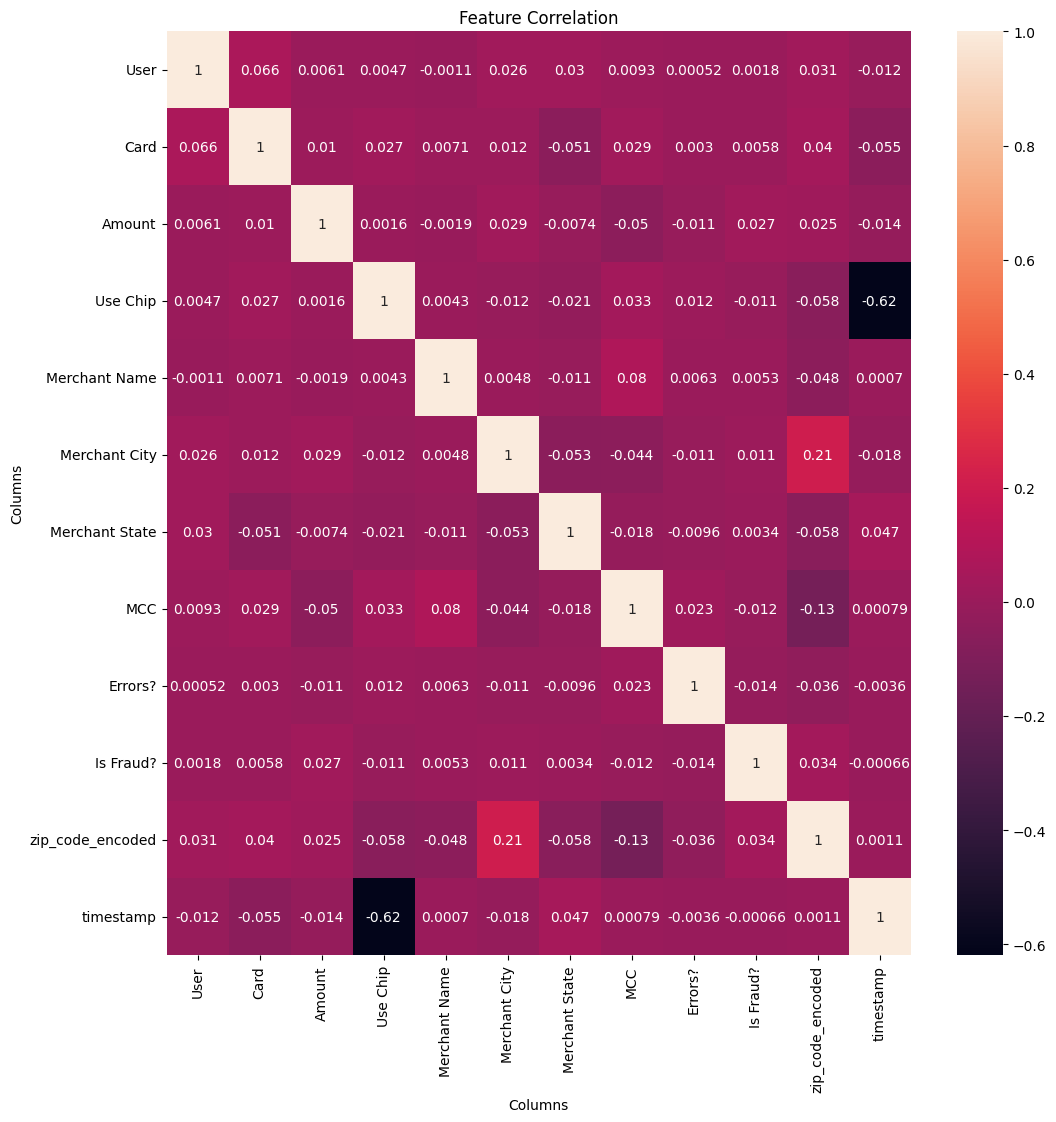

In [ ]:
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df.corr(), annot=True, ax=ax).set(
    title = 'Feature Correlation', xlabel = 'Columns', ylabel = 'Columns')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df,y,test_size=0.2)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def normalize_data(x_train):
    scaler = MinMaxScaler()
    x_normalized = scaler.fit_transform(x_train)

    return x_normalized

In [ ]:
x_train_norm=normalize_data(x_train)
x_test_norm=normalize_data(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train_norm, y_train)
predictions = logisticRegr.predict(x_test)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

#precision=precision_score(y_test,predictions)
#print("precision_score: {:.2f}".format(precision))

#recall=recall_score(y_test,predictions)
#print("recall_score: {:.2f}".format(recall))

#f1=f1_score(y_test,predictions)
#print("f1_score: {:.2f}".format(f1))

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.7 MB/s eta 0:00:00


In [ ]:
x_train,x_valid,y_train,y_valid=train_test_split(x_train,y_train,test_size=0.2)

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.2 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 2, 12),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.5, 1.0)
    }

    model = CatBoostClassifier(iterations=120, **params,loss_function='Logloss')
    model.fit(x_train, y_train)
    y_pred = model.predict(x_valid)
    f1=f1_score(y_valid, y_pred)
    precision=precision_score(y_valid, y_pred)
    recall=recall_score(y_valid, y_pred)
    return (f1 + precision + recall) / 3

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_value = study.best_value

modelGB = CatBoostClassifier(iterations=100, **best_params,loss_function='Logloss')
modelGB.fit(x_train, y_train)
y_pred = modelGB.predict(x_test)

[I 2023-06-05 07:35:15,211] A new study created in memory with name: no-name-3ab2e0b2-f1c7-4e0e-b7e8-5ad50df78966
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),

0:	learn: 0.4183742	total: 388ms	remaining: 46.2s
1:	learn: 0.2743221	total: 663ms	remaining: 39.1s
2:	learn: 0.1867479	total: 931ms	remaining: 36.3s
3:	learn: 0.1305560	total: 1.2s	remaining: 34.7s
4:	learn: 0.0921050	total: 1.45s	remaining: 33.2s
5:	learn: 0.0664279	total: 1.72s	remaining: 32.6s
6:	learn: 0.0482087	total: 2s	remaining: 32.3s
7:	learn: 0.0357479	total: 2.28s	remaining: 31.9s
8:	learn: 0.0269976	total: 2.52s	remaining: 31.1s
9:	learn: 0.0206262	total: 2.77s	remaining: 30.4s
10:	learn: 0.0163281	total: 3.05s	remaining: 30.2s
11:	learn: 0.0132513	total: 3.36s	remaining: 30.3s
12:	learn: 0.0109417	total: 3.81s	remaining: 31.3s
13:	learn: 0.0092906	total: 4.26s	remaining: 32.3s
14:	learn: 0.0082587	total: 4.73s	remaining: 33.1s
15:	learn: 0.0073453	total: 5.18s	remaining: 33.6s
16:	learn: 0.0069792	total: 5.63s	remaining: 34.1s
17:	learn: 0.0065598	total: 6.03s	remaining: 34.2s
18:	learn: 0.0062552	total: 6.45s	remaining: 34.3s
19:	learn: 0.0060793	total: 6.85s	remaining: 

[I 2023-06-05 07:35:55,058] Trial 0 finished with value: 0.41676329200362056 and parameters: {'depth': 2, 'learning_rate': 0.3306693278914699, 'l2_leaf_reg': 3.568942177857672e-05, 'subsample': 0.790001340521248, 'scale_pos_weight': 0.800855259410358}. Best is trial 0 with value: 0.41676329200362056.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.6882454	total: 293ms	remaining: 34.9s
1:	learn: 0.6880931	total: 645ms	remaining: 38s
2:	learn: 0.6875627	total: 997ms	remaining: 38.9s
3:	learn: 0.6873412	total: 1.29s	remaining: 37.4s
4:	learn: 0.6864457	total: 1.57s	remaining: 36.2s
5:	learn: 0.6851390	total: 1.95s	remaining: 37s
6:	learn: 0.6778881	total: 2.17s	remaining: 35s
7:	learn: 0.6772547	total: 2.48s	remaining: 34.7s
8:	learn: 0.6753061	total: 2.75s	remaining: 33.9s
9:	learn: 0.6689954	total: 3.02s	remaining: 33.2s
10:	learn: 0.6688365	total: 3.38s	remaining: 33.4s
11:	learn: 0.6681653	total: 3.69s	remaining: 33.2s
12:	learn: 0.6665660	total: 4.06s	remaining: 33.5s
13:	learn: 0.6659167	total: 4.36s	remaining: 33s
14:	learn: 0.6593544	total: 4.65s	remaining: 32.6s
15:	learn: 0.6583394	total: 4.94s	remaining: 32.1s
16:	learn: 0.6570271	total: 5.3s	remaining: 32.1s
17:	learn: 0.6563784	total: 5.59s	remaining: 31.7s
18:	learn: 0.6561489	total: 5.91s	remaining: 31.4s
19:	learn: 0.6552262	total: 6.38s	remaining: 31.9s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-06-05 07:36:40,380] Trial 1 finished with value: 0.0 and parameters: {'depth': 6, 'learning_rate': 0.13337081953153676, 'l2_leaf_reg': 26327078.943728846, 'subsample': 0.7250932483346176, 'scale_pos_weight': 0.8455060920753502}. Best is trial 0 with value: 0.41676329200362056.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

0:	learn: 0.4524862	total: 253ms	remaining: 30.1s
1:	learn: 0.3128741	total: 519ms	remaining: 30.6s
2:	learn: 0.2219496	total: 773ms	remaining: 30.1s
3:	learn: 0.1624032	total: 1.03s	remaining: 29.9s
4:	learn: 0.1193218	total: 1.31s	remaining: 30.1s
5:	learn: 0.0891995	total: 1.57s	remaining: 29.8s
6:	learn: 0.0670853	total: 1.83s	remaining: 29.5s
7:	learn: 0.0511807	total: 2.08s	remaining: 29.2s
8:	learn: 0.0392261	total: 2.35s	remaining: 29s
9:	learn: 0.0305516	total: 2.62s	remaining: 28.8s
10:	learn: 0.0239644	total: 2.9s	remaining: 28.7s
11:	learn: 0.0190761	total: 3.31s	remaining: 29.8s
12:	learn: 0.0155243	total: 3.79s	remaining: 31.2s
13:	learn: 0.0128661	total: 4.28s	remaining: 32.4s
14:	learn: 0.0107965	total: 4.75s	remaining: 33.3s
15:	learn: 0.0092941	total: 5.21s	remaining: 33.9s
16:	learn: 0.0081524	total: 5.66s	remaining: 34.3s
17:	learn: 0.0071979	total: 6.12s	remaining: 34.7s
18:	learn: 0.0065428	total: 6.59s	remaining: 35s
19:	learn: 0.0060976	total: 6.95s	remaining: 3

[I 2023-06-05 07:37:20,273] Trial 2 finished with value: 0.6254890218214864 and parameters: {'depth': 3, 'learning_rate': 0.2834301316648624, 'l2_leaf_reg': 0.016426648845411146, 'subsample': 0.5154202588618553, 'scale_pos_weight': 0.7350964178443511}. Best is trial 2 with value: 0.6254890218214864.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.5165066	total: 766ms	remaining: 1m 31s
1:	learn: 0.3978242	total: 1.57s	remaining: 1m 32s
2:	learn: 0.3135519	total: 2.37s	remaining: 1m 32s
3:	learn: 0.2498744	total: 3.16s	remaining: 1m 31s
4:	learn: 0.1994555	total: 3.98s	remaining: 1m 31s
5:	learn: 0.1613253	total: 4.77s	remaining: 1m 30s
6:	learn: 0.1311413	total: 5.81s	remaining: 1m 33s
7:	learn: 0.1071586	total: 7.14s	remaining: 1m 40s
8:	learn: 0.0878772	total: 8.45s	remaining: 1m 44s
9:	learn: 0.0720716	total: 9.58s	remaining: 1m 45s
10:	learn: 0.0594319	total: 10.3s	remaining: 1m 42s
11:	learn: 0.0493096	total: 11.1s	remaining: 1m 40s
12:	learn: 0.0408668	total: 11.9s	remaining: 1m 37s
13:	learn: 0.0341249	total: 12.6s	remaining: 1m 35s
14:	learn: 0.0285392	total: 13.4s	remaining: 1m 33s
15:	learn: 0.0241474	total: 14.2s	remaining: 1m 32s
16:	learn: 0.0202645	total: 14.9s	remaining: 1m 30s
17:	learn: 0.0172015	total: 15.7s	remaining: 1m 28s
18:	learn: 0.0147262	total: 16.5s	remaining: 1m 27s
19:	learn: 0.0127126	t

Training has stopped (degenerate solution on iteration 82, probably too small l2-regularization, try to increase it)
[I 2023-06-05 07:38:34,772] Trial 3 finished with value: 0.770920815047235 and parameters: {'depth': 11, 'learning_rate': 0.19486093424998124, 'l2_leaf_reg': 0.0001749886098153044, 'subsample': 0.5223231523536449, 'scale_pos_weight': 0.9166210010047434}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_le

0:	learn: 0.6876500	total: 275ms	remaining: 32.7s
1:	learn: 0.6873516	total: 612ms	remaining: 36.1s
2:	learn: 0.6847742	total: 883ms	remaining: 34.5s
3:	learn: 0.6774211	total: 1.21s	remaining: 35.2s
4:	learn: 0.6749084	total: 1.69s	remaining: 38.9s
5:	learn: 0.6688528	total: 2.32s	remaining: 44s
6:	learn: 0.6663197	total: 2.82s	remaining: 45.5s
7:	learn: 0.6612874	total: 3.38s	remaining: 47.3s
8:	learn: 0.6589381	total: 3.97s	remaining: 49s
9:	learn: 0.6555903	total: 4.36s	remaining: 48s
10:	learn: 0.6537211	total: 4.95s	remaining: 49.1s
11:	learn: 0.6435481	total: 5.28s	remaining: 47.5s
12:	learn: 0.6379377	total: 5.59s	remaining: 46s
13:	learn: 0.6353874	total: 5.89s	remaining: 44.6s
14:	learn: 0.6278856	total: 6.16s	remaining: 43.1s
15:	learn: 0.6253481	total: 6.45s	remaining: 41.9s
16:	learn: 0.6244743	total: 6.75s	remaining: 40.9s
17:	learn: 0.6140262	total: 6.97s	remaining: 39.5s
18:	learn: 0.6120468	total: 7.31s	remaining: 38.9s
19:	learn: 0.6113789	total: 7.65s	remaining: 38.2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-06-05 07:39:17,268] Trial 4 finished with value: 0.0 and parameters: {'depth': 5, 'learning_rate': 0.8736363240259417, 'l2_leaf_reg': 90222840.60622923, 'subsample': 0.7285920024292287, 'scale_pos_weight': 0.9930799148239478}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6

0:	learn: 0.4496449	total: 898ms	remaining: 1m 46s
1:	learn: 0.3091303	total: 2.28s	remaining: 2m 14s
2:	learn: 0.2204355	total: 3.91s	remaining: 2m 32s
3:	learn: 0.1599599	total: 5.39s	remaining: 2m 36s
4:	learn: 0.1185835	total: 6.38s	remaining: 2m 26s
5:	learn: 0.0878547	total: 7.32s	remaining: 2m 19s
6:	learn: 0.0657918	total: 8.22s	remaining: 2m 12s
7:	learn: 0.0498345	total: 9.12s	remaining: 2m 7s
8:	learn: 0.0382362	total: 10s	remaining: 2m 3s
9:	learn: 0.0294327	total: 10.9s	remaining: 2m
10:	learn: 0.0225505	total: 11.8s	remaining: 1m 57s
11:	learn: 0.0177714	total: 12.7s	remaining: 1m 54s
12:	learn: 0.0142496	total: 13.6s	remaining: 1m 52s
13:	learn: 0.0115503	total: 14.5s	remaining: 1m 49s
14:	learn: 0.0096125	total: 15.5s	remaining: 1m 48s
15:	learn: 0.0078634	total: 17s	remaining: 1m 50s
16:	learn: 0.0066722	total: 18.6s	remaining: 1m 52s
17:	learn: 0.0058493	total: 19.8s	remaining: 1m 52s
18:	learn: 0.0052267	total: 20.7s	remaining: 1m 49s
19:	learn: 0.0048968	total: 21.6

[I 2023-06-05 07:41:24,810] Trial 5 finished with value: 0.767767031202245 and parameters: {'depth': 11, 'learning_rate': 0.2865732571959578, 'l2_leaf_reg': 5.923121956437536e-09, 'subsample': 0.6634514825120786, 'scale_pos_weight': 0.9398810676645798}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.1421614	total: 1.08s	remaining: 2m 8s
1:	learn: 0.0520173	total: 2.41s	remaining: 2m 22s
2:	learn: 0.0220310	total: 3.79s	remaining: 2m 27s
3:	learn: 0.0109367	total: 4.79s	remaining: 2m 18s
4:	learn: 0.0088884	total: 5.52s	remaining: 2m 7s
5:	learn: 0.0063468	total: 6.26s	remaining: 1m 58s
6:	learn: 0.0104272	total: 7.02s	remaining: 1m 53s
7:	learn: 0.0093327	total: 7.81s	remaining: 1m 49s
8:	learn: 0.0197498	total: 8.57s	remaining: 1m 45s
9:	learn: 0.0317137	total: 9.33s	remaining: 1m 42s
10:	learn: 0.0258218	total: 10.1s	remaining: 1m 40s
11:	learn: 0.0275214	total: 10.9s	remaining: 1m 37s
12:	learn: 0.0282275	total: 11.6s	remaining: 1m 35s
13:	learn: 1.3709809	total: 12.4s	remaining: 1m 33s


Training has stopped (degenerate solution on iteration 14, probably too small l2-regularization, try to increase it)
[I 2023-06-05 07:41:40,231] Trial 6 finished with value: 0.19894811826675876 and parameters: {'depth': 11, 'learning_rate': 0.9466113848835044, 'l2_leaf_reg': 0.002272815617248539, 'subsample': 0.5058539467482696, 'scale_pos_weight': 0.6687581307598857}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_le

0:	learn: 0.4374979	total: 454ms	remaining: 54s
1:	learn: 0.3452898	total: 1.09s	remaining: 1m 4s
2:	learn: 0.2674440	total: 1.61s	remaining: 1m 2s
3:	learn: 0.1958296	total: 2.03s	remaining: 59s
4:	learn: 0.1732298	total: 2.62s	remaining: 1m
5:	learn: 0.1334993	total: 3.02s	remaining: 57.5s
6:	learn: 0.1146365	total: 3.33s	remaining: 53.7s
7:	learn: 0.1054687	total: 3.72s	remaining: 52.1s
8:	learn: 0.0924676	total: 4.04s	remaining: 49.9s
9:	learn: 0.0822549	total: 4.36s	remaining: 47.9s
10:	learn: 0.0738633	total: 4.68s	remaining: 46.3s
11:	learn: 0.0668334	total: 5.05s	remaining: 45.5s
12:	learn: 0.0609768	total: 5.35s	remaining: 44s
13:	learn: 0.0559928	total: 5.65s	remaining: 42.7s
14:	learn: 0.0518193	total: 5.95s	remaining: 41.6s
15:	learn: 0.0498081	total: 6.31s	remaining: 41s
16:	learn: 0.0464580	total: 6.69s	remaining: 40.6s
17:	learn: 0.0448611	total: 7.06s	remaining: 40s
18:	learn: 0.0421891	total: 7.37s	remaining: 39.2s
19:	learn: 0.0397496	total: 7.66s	remaining: 38.3s
20:

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-06-05 07:42:42,099] Trial 7 finished with value: 0.0 and parameters: {'depth': 8, 'learning_rate': 0.42986229111922, 'l2_leaf_reg': 200475.07815174642, 'subsample': 0.637448181388768, 'scale_pos_weight': 0.8535735055084417}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0

0:	learn: 0.3151524	total: 1s	remaining: 1m 59s
1:	learn: 0.1738389	total: 2s	remaining: 1m 58s
2:	learn: 0.1015844	total: 3.01s	remaining: 1m 57s
3:	learn: 0.0614227	total: 4.03s	remaining: 1m 56s
4:	learn: 0.0383832	total: 5.14s	remaining: 1m 58s
5:	learn: 0.0241087	total: 6.1s	remaining: 1m 55s
6:	learn: 0.0159805	total: 7.13s	remaining: 1m 55s
7:	learn: 0.0108726	total: 8.09s	remaining: 1m 53s
8:	learn: 0.0079072	total: 9.67s	remaining: 1m 59s
9:	learn: 0.0059070	total: 11.4s	remaining: 2m 5s
10:	learn: 0.0049005	total: 12.7s	remaining: 2m 5s
11:	learn: 0.0040621	total: 13.7s	remaining: 2m 3s
12:	learn: 0.0038332	total: 14.7s	remaining: 2m
13:	learn: 0.0070312	total: 15.7s	remaining: 1m 58s
14:	learn: 0.0042688	total: 16.7s	remaining: 1m 56s
15:	learn: 0.0055220	total: 17.7s	remaining: 1m 55s
16:	learn: 0.0054043	total: 18.8s	remaining: 1m 53s
17:	learn: 0.0064507	total: 19.7s	remaining: 1m 51s
18:	learn: 0.0056058	total: 20.7s	remaining: 1m 50s
19:	learn: 0.0049620	total: 21.8s	re

Training has stopped (degenerate solution on iteration 24, probably too small l2-regularization, try to increase it)
[I 2023-06-05 07:43:12,885] Trial 8 finished with value: 0.6689408246890983 and parameters: {'depth': 12, 'learning_rate': 0.4968826131669122, 'l2_leaf_reg': 4.539806887015855e-05, 'subsample': 0.6292675677437352, 'scale_pos_weight': 0.8554688283369163}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_le

0:	learn: 0.6595522	total: 998ms	remaining: 1m 58s
1:	learn: 0.6354641	total: 2.02s	remaining: 1m 58s
2:	learn: 0.6076184	total: 3.02s	remaining: 1m 57s
3:	learn: 0.5807502	total: 4.02s	remaining: 1m 56s
4:	learn: 0.5602530	total: 5.13s	remaining: 1m 57s
5:	learn: 0.5334629	total: 5.5s	remaining: 1m 44s
6:	learn: 0.5155987	total: 7.18s	remaining: 1m 55s
7:	learn: 0.4956610	total: 7.96s	remaining: 1m 51s
8:	learn: 0.4732864	total: 9.7s	remaining: 1m 59s
9:	learn: 0.4547469	total: 10.7s	remaining: 1m 57s
10:	learn: 0.4385476	total: 11.2s	remaining: 1m 50s
11:	learn: 0.4226402	total: 12s	remaining: 1m 47s
12:	learn: 0.4068524	total: 13s	remaining: 1m 46s
13:	learn: 0.3915328	total: 13.4s	remaining: 1m 41s
14:	learn: 0.3763398	total: 14.4s	remaining: 1m 40s
15:	learn: 0.3615352	total: 15.5s	remaining: 1m 40s
16:	learn: 0.3484573	total: 16.5s	remaining: 1m 40s
17:	learn: 0.3364263	total: 17.3s	remaining: 1m 38s
18:	learn: 0.3248262	total: 18.3s	remaining: 1m 37s
19:	learn: 0.3137591	total: 

[I 2023-06-05 07:45:22,760] Trial 9 finished with value: 0.45585099711526406 and parameters: {'depth': 12, 'learning_rate': 0.03112838270141012, 'l2_leaf_reg': 19.223089917531087, 'subsample': 0.629714457795282, 'scale_pos_weight': 0.9465466351879104}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0.

0:	learn: 0.2343269	total: 546ms	remaining: 1m 4s
1:	learn: 0.1076148	total: 1.14s	remaining: 1m 7s
2:	learn: 0.0541099	total: 1.8s	remaining: 1m 10s
3:	learn: 0.0282709	total: 2.41s	remaining: 1m 9s
4:	learn: 0.0156754	total: 3.51s	remaining: 1m 20s
5:	learn: 0.0092008	total: 4.49s	remaining: 1m 25s
6:	learn: 0.0063259	total: 5.52s	remaining: 1m 29s
7:	learn: 0.0050176	total: 6.58s	remaining: 1m 32s
8:	learn: 0.0037017	total: 7.13s	remaining: 1m 27s
9:	learn: 0.0034681	total: 7.74s	remaining: 1m 25s
10:	learn: 0.0080579	total: 8.31s	remaining: 1m 22s
11:	learn: 0.0046785	total: 8.92s	remaining: 1m 20s
12:	learn: 0.0048014	total: 9.51s	remaining: 1m 18s
13:	learn: 0.0069822	total: 10.2s	remaining: 1m 16s
14:	learn: 0.0089848	total: 10.8s	remaining: 1m 15s


Training has stopped (degenerate solution on iteration 15, probably too small l2-regularization, try to increase it)
[I 2023-06-05 07:45:36,578] Trial 10 finished with value: 0.4933445292554601 and parameters: {'depth': 9, 'learning_rate': 0.6704768289213909, 'l2_leaf_reg': 1.2347983711962e-10, 'subsample': 0.9023288585928142, 'scale_pos_weight': 0.5097558227268788}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf

0:	learn: 0.5003507	total: 697ms	remaining: 1m 22s
1:	learn: 0.3751310	total: 1.42s	remaining: 1m 24s
2:	learn: 0.2853552	total: 2.01s	remaining: 1m 18s
3:	learn: 0.2214198	total: 2.7s	remaining: 1m 18s
4:	learn: 0.1741260	total: 3.9s	remaining: 1m 29s
5:	learn: 0.1381292	total: 5.19s	remaining: 1m 38s
6:	learn: 0.1095190	total: 6.46s	remaining: 1m 44s
7:	learn: 0.0880346	total: 7.37s	remaining: 1m 43s
8:	learn: 0.0709530	total: 7.81s	remaining: 1m 36s
9:	learn: 0.0572528	total: 8.53s	remaining: 1m 33s
10:	learn: 0.0462904	total: 9.24s	remaining: 1m 31s
11:	learn: 0.0378785	total: 9.95s	remaining: 1m 29s
12:	learn: 0.0310696	total: 10.6s	remaining: 1m 27s
13:	learn: 0.0256435	total: 11.4s	remaining: 1m 26s
14:	learn: 0.0210146	total: 12.1s	remaining: 1m 24s
15:	learn: 0.0175522	total: 12.8s	remaining: 1m 23s
16:	learn: 0.0147908	total: 13.5s	remaining: 1m 21s
17:	learn: 0.0125470	total: 14.2s	remaining: 1m 20s
18:	learn: 0.0108090	total: 14.9s	remaining: 1m 19s
19:	learn: 0.0094008	tot

Training has stopped (degenerate solution on iteration 73, probably too small l2-regularization, try to increase it)
[I 2023-06-05 07:46:38,532] Trial 11 finished with value: 0.7458774537892706 and parameters: {'depth': 10, 'learning_rate': 0.21815579498172405, 'l2_leaf_reg': 1.6790342773237634e-09, 'subsample': 0.552971487782081, 'scale_pos_weight': 0.9478043482874459}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_

0:	learn: 0.6844383	total: 895ms	remaining: 1m 46s
1:	learn: 0.6682343	total: 1.64s	remaining: 1m 36s
2:	learn: 0.6563364	total: 2.24s	remaining: 1m 27s
3:	learn: 0.6455829	total: 2.96s	remaining: 1m 25s
4:	learn: 0.6352149	total: 3.69s	remaining: 1m 24s
5:	learn: 0.6244839	total: 4.43s	remaining: 1m 24s
6:	learn: 0.6118716	total: 5.2s	remaining: 1m 24s
7:	learn: 0.5978442	total: 5.96s	remaining: 1m 23s
8:	learn: 0.5932281	total: 6.42s	remaining: 1m 19s
9:	learn: 0.5800339	total: 7.15s	remaining: 1m 18s
10:	learn: 0.5739557	total: 7.91s	remaining: 1m 18s
11:	learn: 0.5626486	total: 8.66s	remaining: 1m 17s
12:	learn: 0.5504203	total: 9.4s	remaining: 1m 17s
13:	learn: 0.5446753	total: 10.2s	remaining: 1m 16s
14:	learn: 0.5324368	total: 11.3s	remaining: 1m 18s
15:	learn: 0.5278701	total: 12.6s	remaining: 1m 21s
16:	learn: 0.5161365	total: 13.9s	remaining: 1m 24s
17:	learn: 0.5087082	total: 14.7s	remaining: 1m 23s
18:	learn: 0.5004476	total: 15.5s	remaining: 1m 22s
19:	learn: 0.4897313	tot

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-06-05 07:48:20,697] Trial 12 finished with value: 0.0 and parameters: {'depth': 10, 'learning_rate': 0.012593810571233821, 'l2_leaf_reg': 1.2122153707330457e-07, 'subsample': 0.5872816026552902, 'scale_pos_weight': 0.9219276127457359}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be remo

0:	learn: 0.4061468	total: 376ms	remaining: 44.8s
1:	learn: 0.2595540	total: 801ms	remaining: 47.3s
2:	learn: 0.1739543	total: 1.19s	remaining: 46.5s
3:	learn: 0.1195045	total: 1.61s	remaining: 46.6s
4:	learn: 0.0834731	total: 2.07s	remaining: 47.6s
5:	learn: 0.0592829	total: 2.47s	remaining: 47s
6:	learn: 0.0427446	total: 2.9s	remaining: 46.8s
7:	learn: 0.0313490	total: 3.29s	remaining: 46.1s
8:	learn: 0.0232187	total: 3.7s	remaining: 45.6s
9:	learn: 0.0176920	total: 4.09s	remaining: 45s
10:	learn: 0.0137942	total: 4.51s	remaining: 44.7s
11:	learn: 0.0106490	total: 4.94s	remaining: 44.5s
12:	learn: 0.0088095	total: 5.33s	remaining: 43.8s
13:	learn: 0.0071629	total: 5.71s	remaining: 43.2s
14:	learn: 0.0061596	total: 6.14s	remaining: 43s
15:	learn: 0.0052692	total: 6.52s	remaining: 42.4s
16:	learn: 0.0048014	total: 6.93s	remaining: 42s
17:	learn: 0.0044944	total: 7.32s	remaining: 41.5s
18:	learn: 0.0042859	total: 7.74s	remaining: 41.1s
19:	learn: 0.0040773	total: 8.15s	remaining: 40.8s


Training has stopped (degenerate solution on iteration 39, probably too small l2-regularization, try to increase it)
[I 2023-06-05 07:48:41,338] Trial 13 finished with value: 0.49709279997916384 and parameters: {'depth': 8, 'learning_rate': 0.3495927487729198, 'l2_leaf_reg': 2.945625516294398e-07, 'subsample': 0.50543764483362, 'scale_pos_weight': 0.9766097964070699}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_lea

0:	learn: 0.5350753	total: 791ms	remaining: 1m 34s
1:	learn: 0.4246565	total: 1.63s	remaining: 1m 35s
2:	learn: 0.3445590	total: 2.69s	remaining: 1m 45s
3:	learn: 0.2811418	total: 4.11s	remaining: 1m 59s
4:	learn: 0.2290633	total: 5.48s	remaining: 2m 6s
5:	learn: 0.1895495	total: 6.46s	remaining: 2m 2s
6:	learn: 0.1580596	total: 7.3s	remaining: 1m 57s
7:	learn: 0.1314043	total: 8.13s	remaining: 1m 53s
8:	learn: 0.1103948	total: 8.64s	remaining: 1m 46s
9:	learn: 0.0926318	total: 9.44s	remaining: 1m 43s
10:	learn: 0.0779781	total: 10.3s	remaining: 1m 41s
11:	learn: 0.0659308	total: 11.1s	remaining: 1m 39s
12:	learn: 0.0559608	total: 12s	remaining: 1m 38s
13:	learn: 0.0476735	total: 12.8s	remaining: 1m 36s
14:	learn: 0.0405265	total: 13.5s	remaining: 1m 34s
15:	learn: 0.0346985	total: 14.3s	remaining: 1m 33s
16:	learn: 0.0296659	total: 15.1s	remaining: 1m 31s
17:	learn: 0.0254999	total: 15.9s	remaining: 1m 30s
18:	learn: 0.0220369	total: 17.3s	remaining: 1m 31s
19:	learn: 0.0192299	total:

[I 2023-06-05 07:50:34,292] Trial 14 finished with value: 0.7545808781416644 and parameters: {'depth': 10, 'learning_rate': 0.17118721495889733, 'l2_leaf_reg': 3.718345078688155, 'subsample': 0.6823589819946222, 'scale_pos_weight': 0.9031095800907193}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0.

0:	learn: 0.3637697	total: 929ms	remaining: 1m 50s
1:	learn: 0.2193289	total: 1.96s	remaining: 1m 55s
2:	learn: 0.1384805	total: 3.6s	remaining: 2m 20s
3:	learn: 0.0893322	total: 5.27s	remaining: 2m 32s
4:	learn: 0.0597106	total: 6.49s	remaining: 2m 29s
5:	learn: 0.0397966	total: 7.38s	remaining: 2m 20s
6:	learn: 0.0274811	total: 8.34s	remaining: 2m 14s
7:	learn: 0.0193327	total: 9.24s	remaining: 2m 9s
8:	learn: 0.0139745	total: 10.1s	remaining: 2m 4s
9:	learn: 0.0105062	total: 11s	remaining: 2m 1s
10:	learn: 0.0083507	total: 11.9s	remaining: 1m 58s
11:	learn: 0.0065040	total: 12.8s	remaining: 1m 55s
12:	learn: 0.0055026	total: 13.8s	remaining: 1m 53s
13:	learn: 0.0046169	total: 14.7s	remaining: 1m 51s
14:	learn: 0.0041505	total: 15.7s	remaining: 1m 49s
15:	learn: 0.0043362	total: 17.2s	remaining: 1m 51s
16:	learn: 0.0040981	total: 18.9s	remaining: 1m 54s
17:	learn: 0.0039543	total: 20.2s	remaining: 1m 54s
18:	learn: 0.0038532	total: 21.2s	remaining: 1m 52s
19:	learn: 0.0039572	total: 

Training has stopped (degenerate solution on iteration 31, probably too small l2-regularization, try to increase it)
[I 2023-06-05 07:51:11,759] Trial 15 finished with value: 0.7654898141823931 and parameters: {'depth': 12, 'learning_rate': 0.4129403004173109, 'l2_leaf_reg': 9.309465373260155e-08, 'subsample': 0.5815414985759653, 'scale_pos_weight': 0.9845537502712475}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_l

0:	learn: 0.2881909	total: 406ms	remaining: 48.3s
1:	learn: 0.1498585	total: 846ms	remaining: 49.9s
2:	learn: 0.0832431	total: 1.29s	remaining: 50.4s
3:	learn: 0.0480731	total: 1.74s	remaining: 50.5s
4:	learn: 0.0291720	total: 2.18s	remaining: 50.2s
5:	learn: 0.0183487	total: 2.66s	remaining: 50.5s
6:	learn: 0.0121330	total: 3.14s	remaining: 50.7s
7:	learn: 0.0088174	total: 3.57s	remaining: 50s
8:	learn: 0.0068206	total: 4.04s	remaining: 49.9s
9:	learn: 0.0063396	total: 4.5s	remaining: 49.5s
10:	learn: 0.0051513	total: 4.97s	remaining: 49.3s
11:	learn: 0.0047764	total: 5.43s	remaining: 48.9s
12:	learn: 0.0059703	total: 5.9s	remaining: 48.6s
13:	learn: 0.0053826	total: 6.37s	remaining: 48.3s
14:	learn: 0.0058346	total: 7.02s	remaining: 49.1s
15:	learn: 0.0052787	total: 7.84s	remaining: 50.9s
16:	learn: 0.0088859	total: 8.66s	remaining: 52.5s
17:	learn: 0.0088030	total: 9.47s	remaining: 53.7s
18:	learn: 0.0106169	total: 10.3s	remaining: 54.5s
19:	learn: 0.0096750	total: 10.8s	remaining: 

Training has stopped (degenerate solution on iteration 39, probably too small l2-regularization, try to increase it)
[I 2023-06-05 07:51:34,868] Trial 16 finished with value: 0.6761423620534838 and parameters: {'depth': 7, 'learning_rate': 0.5540855940257408, 'l2_leaf_reg': 2.445068342969184e-10, 'subsample': 0.7999214079204565, 'scale_pos_weight': 0.9072839949772735}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_le

0:	learn: 0.5154288	total: 832ms	remaining: 1m 38s
1:	learn: 0.3924363	total: 1.34s	remaining: 1m 19s
2:	learn: 0.3072656	total: 1.89s	remaining: 1m 13s
3:	learn: 0.2433900	total: 2.42s	remaining: 1m 10s
4:	learn: 0.1947231	total: 2.92s	remaining: 1m 7s
5:	learn: 0.1565917	total: 3.44s	remaining: 1m 5s
6:	learn: 0.1266947	total: 3.94s	remaining: 1m 3s
7:	learn: 0.1030214	total: 4.29s	remaining: 1m
8:	learn: 0.0838618	total: 4.79s	remaining: 59.1s
9:	learn: 0.0685362	total: 5.27s	remaining: 57.9s
10:	learn: 0.0562492	total: 5.77s	remaining: 57.2s
11:	learn: 0.0463082	total: 6.24s	remaining: 56.2s
12:	learn: 0.0383579	total: 6.79s	remaining: 55.9s
13:	learn: 0.0319511	total: 7.32s	remaining: 55.4s
14:	learn: 0.0267212	total: 7.76s	remaining: 54.4s
15:	learn: 0.0224547	total: 8.31s	remaining: 54s
16:	learn: 0.0189842	total: 8.78s	remaining: 53.2s
17:	learn: 0.0162307	total: 9.25s	remaining: 52.4s
18:	learn: 0.0139145	total: 9.72s	remaining: 51.7s
19:	learn: 0.0119290	total: 10.3s	remainin

Training has stopped (degenerate solution on iteration 48, probably too small l2-regularization, try to increase it)
[I 2023-06-05 07:52:06,903] Trial 17 finished with value: 0.7058713446362889 and parameters: {'depth': 9, 'learning_rate': 0.19930534220968538, 'l2_leaf_reg': 2.7960860817098226e-05, 'subsample': 0.6799606316245679, 'scale_pos_weight': 0.7723998283645479}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_

0:	learn: 0.4546733	total: 320ms	remaining: 38s
1:	learn: 0.3188969	total: 651ms	remaining: 38.4s
2:	learn: 0.2288074	total: 1s	remaining: 39.2s
3:	learn: 0.1686628	total: 1.32s	remaining: 38.2s
4:	learn: 0.1260281	total: 1.66s	remaining: 38.1s
5:	learn: 0.0946043	total: 1.97s	remaining: 37.5s
6:	learn: 0.0714897	total: 2.34s	remaining: 37.8s
7:	learn: 0.0548757	total: 2.65s	remaining: 37.2s
8:	learn: 0.0420738	total: 3.02s	remaining: 37.3s
9:	learn: 0.0328023	total: 3.37s	remaining: 37.1s
10:	learn: 0.0259372	total: 3.69s	remaining: 36.6s
11:	learn: 0.0207813	total: 4s	remaining: 36s
12:	learn: 0.0167265	total: 4.33s	remaining: 35.6s
13:	learn: 0.0137716	total: 4.66s	remaining: 35.3s
14:	learn: 0.0115185	total: 4.98s	remaining: 34.9s
15:	learn: 0.0097974	total: 5.31s	remaining: 34.5s
16:	learn: 0.0086537	total: 5.6s	remaining: 33.9s
17:	learn: 0.0074675	total: 5.94s	remaining: 33.7s
18:	learn: 0.0067513	total: 6.26s	remaining: 33.3s
19:	learn: 0.0062251	total: 6.58s	remaining: 32.9s
2

[I 2023-06-05 07:52:54,103] Trial 18 finished with value: 0.7400361366044157 and parameters: {'depth': 5, 'learning_rate': 0.2755069358622674, 'l2_leaf_reg': 0.05026272627769938, 'subsample': 0.5725407331566715, 'scale_pos_weight': 0.880201065523792}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. 

0:	learn: 0.6068711	total: 1.18s	remaining: 2m 20s
1:	learn: 0.5332532	total: 2.39s	remaining: 2m 21s
2:	learn: 0.4708258	total: 3.94s	remaining: 2m 33s
3:	learn: 0.4182979	total: 6.11s	remaining: 2m 57s
4:	learn: 0.3735956	total: 7.83s	remaining: 3m
5:	learn: 0.3336838	total: 9.06s	remaining: 2m 52s
6:	learn: 0.2987546	total: 10.3s	remaining: 2m 46s
7:	learn: 0.2680373	total: 11.5s	remaining: 2m 40s
8:	learn: 0.2411939	total: 12.7s	remaining: 2m 36s
9:	learn: 0.2172106	total: 13.9s	remaining: 2m 33s
10:	learn: 0.1961150	total: 15.2s	remaining: 2m 30s
11:	learn: 0.1774514	total: 16.4s	remaining: 2m 27s
12:	learn: 0.1607152	total: 17.9s	remaining: 2m 27s
13:	learn: 0.1453685	total: 19.2s	remaining: 2m 25s
14:	learn: 0.1321278	total: 21.4s	remaining: 2m 29s
15:	learn: 0.1201361	total: 22.6s	remaining: 2m 26s
16:	learn: 0.1092773	total: 23.8s	remaining: 2m 24s
17:	learn: 0.1004047	total: 25.1s	remaining: 2m 22s
18:	learn: 0.0915665	total: 26.3s	remaining: 2m 19s
19:	learn: 0.0838179	total

[I 2023-06-05 07:55:38,135] Trial 19 finished with value: 0.5183208982709929 and parameters: {'depth': 11, 'learning_rate': 0.09568812129806986, 'l2_leaf_reg': 177.22745126391646, 'subsample': 0.9949460656072524, 'scale_pos_weight': 0.9966928217417713}. Best is trial 3 with value: 0.770920815047235.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.5903796	total: 799ms	remaining: 1m 35s
1:	learn: 0.5006899	total: 1.6s	remaining: 1m 34s
2:	learn: 0.4339135	total: 2.44s	remaining: 1m 34s
3:	learn: 0.3757142	total: 3.24s	remaining: 1m 34s
4:	learn: 0.3280417	total: 4.07s	remaining: 1m 33s
5:	learn: 0.2849010	total: 4.86s	remaining: 1m 32s
6:	learn: 0.2513014	total: 5.66s	remaining: 1m 31s
7:	learn: 0.2205235	total: 6.45s	remaining: 1m 30s
8:	learn: 0.1951770	total: 7.25s	remaining: 1m 29s
9:	learn: 0.1724203	total: 8.03s	remaining: 1m 28s
10:	learn: 0.1519537	total: 8.89s	remaining: 1m 28s
11:	learn: 0.1351386	total: 10.3s	remaining: 1m 32s
12:	learn: 0.1198327	total: 11.7s	remaining: 1m 36s
13:	learn: 0.1069747	total: 13s	remaining: 1m 38s
14:	learn: 0.0952214	total: 13.8s	remaining: 1m 36s
15:	learn: 0.0846822	total: 14.6s	remaining: 1m 35s
16:	learn: 0.0757260	total: 15.4s	remaining: 1m 33s
17:	learn: 0.0674972	total: 16.2s	remaining: 1m 31s
18:	learn: 0.0608073	total: 17s	remaining: 1m 30s
19:	learn: 0.0542595	total:

[I 2023-06-05 07:57:29,831] Trial 20 finished with value: 0.7729050611519265 and parameters: {'depth': 11, 'learning_rate': 0.11334683943659962, 'l2_leaf_reg': 4.842962172740597e-08, 'subsample': 0.5567854548135769, 'scale_pos_weight': 0.9309874903640453}. Best is trial 20 with value: 0.7729050611519265.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v

0:	learn: 0.5913606	total: 777ms	remaining: 1m 32s
1:	learn: 0.5046664	total: 1.59s	remaining: 1m 33s
2:	learn: 0.4383173	total: 2.4s	remaining: 1m 33s
3:	learn: 0.3812822	total: 3.21s	remaining: 1m 33s
4:	learn: 0.3344073	total: 4.03s	remaining: 1m 32s
5:	learn: 0.2932749	total: 4.83s	remaining: 1m 31s
6:	learn: 0.2591373	total: 5.63s	remaining: 1m 30s
7:	learn: 0.2282932	total: 6.43s	remaining: 1m 29s
8:	learn: 0.2028941	total: 7.2s	remaining: 1m 28s
9:	learn: 0.1795605	total: 8s	remaining: 1m 27s
10:	learn: 0.1589996	total: 8.77s	remaining: 1m 26s
11:	learn: 0.1422844	total: 9.62s	remaining: 1m 26s
12:	learn: 0.1268675	total: 11s	remaining: 1m 30s
13:	learn: 0.1125321	total: 12.4s	remaining: 1m 34s
14:	learn: 0.1005100	total: 13.7s	remaining: 1m 36s
15:	learn: 0.0900260	total: 14.5s	remaining: 1m 34s
16:	learn: 0.0808002	total: 15.3s	remaining: 1m 32s
17:	learn: 0.0726406	total: 16.1s	remaining: 1m 31s
18:	learn: 0.0651742	total: 16.9s	remaining: 1m 29s
19:	learn: 0.0584973	total: 1

[I 2023-06-05 07:59:19,889] Trial 21 finished with value: 0.7797408493077175 and parameters: {'depth': 11, 'learning_rate': 0.10959594589335897, 'l2_leaf_reg': 4.003225706439721e-08, 'subsample': 0.5443205960860706, 'scale_pos_weight': 0.9331278921950319}. Best is trial 21 with value: 0.7797408493077175.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v

0:	learn: 0.5967325	total: 766ms	remaining: 1m 31s
1:	learn: 0.5193785	total: 1.6s	remaining: 1m 34s
2:	learn: 0.4550815	total: 2.49s	remaining: 1m 37s
3:	learn: 0.4034216	total: 3.12s	remaining: 1m 30s
4:	learn: 0.3564115	total: 3.58s	remaining: 1m 22s
5:	learn: 0.3148721	total: 4.06s	remaining: 1m 17s
6:	learn: 0.2820942	total: 4.51s	remaining: 1m 12s
7:	learn: 0.2512220	total: 4.84s	remaining: 1m 7s
8:	learn: 0.2238385	total: 5.3s	remaining: 1m 5s
9:	learn: 0.2002659	total: 5.73s	remaining: 1m 3s
10:	learn: 0.1807058	total: 6.23s	remaining: 1m 1s
11:	learn: 0.1615296	total: 6.64s	remaining: 59.8s
12:	learn: 0.1456694	total: 7.15s	remaining: 58.8s
13:	learn: 0.1310403	total: 7.62s	remaining: 57.7s
14:	learn: 0.1185094	total: 8.04s	remaining: 56.3s
15:	learn: 0.1068616	total: 8.52s	remaining: 55.4s
16:	learn: 0.0963036	total: 8.98s	remaining: 54.4s
17:	learn: 0.0872455	total: 9.42s	remaining: 53.4s
18:	learn: 0.0788519	total: 9.87s	remaining: 52.5s
19:	learn: 0.0714358	total: 10.3s	re

[I 2023-06-05 08:00:27,200] Trial 22 finished with value: 0.7484417542448764 and parameters: {'depth': 9, 'learning_rate': 0.09961859450093424, 'l2_leaf_reg': 4.089693522342361e-07, 'subsample': 0.5453903825168673, 'scale_pos_weight': 0.9028624129295615}. Best is trial 21 with value: 0.7797408493077175.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3

0:	learn: 0.6851300	total: 819ms	remaining: 1m 37s
1:	learn: 0.6749914	total: 1.63s	remaining: 1m 36s
2:	learn: 0.6594837	total: 2.47s	remaining: 1m 36s
3:	learn: 0.6556721	total: 3.78s	remaining: 1m 49s
4:	learn: 0.6438969	total: 5.26s	remaining: 2m
5:	learn: 0.6357775	total: 6.7s	remaining: 2m 7s
6:	learn: 0.6252663	total: 7.52s	remaining: 2m 1s
7:	learn: 0.6171991	total: 8.34s	remaining: 1m 56s
8:	learn: 0.6078717	total: 9.18s	remaining: 1m 53s
9:	learn: 0.5972977	total: 9.98s	remaining: 1m 49s
10:	learn: 0.5933427	total: 10.8s	remaining: 1m 46s
11:	learn: 0.5822387	total: 11.6s	remaining: 1m 44s
12:	learn: 0.5767763	total: 12.5s	remaining: 1m 42s
13:	learn: 0.5657216	total: 13.3s	remaining: 1m 40s
14:	learn: 0.5620056	total: 14.1s	remaining: 1m 38s
15:	learn: 0.5504004	total: 15s	remaining: 1m 37s
16:	learn: 0.5464973	total: 15.8s	remaining: 1m 35s
17:	learn: 0.5352310	total: 16.7s	remaining: 1m 34s
18:	learn: 0.5314156	total: 18s	remaining: 1m 35s
19:	learn: 0.5206267	total: 19.5s

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-06-05 08:02:20,069] Trial 23 finished with value: 0.0 and parameters: {'depth': 11, 'learning_rate': 0.010232322859722906, 'l2_leaf_reg': 1.474015299983753e-05, 'subsample': 0.5857471917564929, 'scale_pos_weight': 0.8156803800754875}. Best is trial 21 with value: 0.7797408493077175.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be rem

0:	learn: 0.5160040	total: 685ms	remaining: 1m 21s
1:	learn: 0.3941861	total: 1.39s	remaining: 1m 21s
2:	learn: 0.3092506	total: 1.97s	remaining: 1m 17s
3:	learn: 0.2444294	total: 2.67s	remaining: 1m 17s
4:	learn: 0.1967014	total: 3.81s	remaining: 1m 27s
5:	learn: 0.1582119	total: 5.06s	remaining: 1m 36s
6:	learn: 0.1276802	total: 6.3s	remaining: 1m 41s
7:	learn: 0.1042339	total: 7.23s	remaining: 1m 41s
8:	learn: 0.0852037	total: 7.68s	remaining: 1m 34s
9:	learn: 0.0698165	total: 8.38s	remaining: 1m 32s
10:	learn: 0.0577414	total: 9.11s	remaining: 1m 30s
11:	learn: 0.0479716	total: 9.82s	remaining: 1m 28s
12:	learn: 0.0397919	total: 10.5s	remaining: 1m 26s
13:	learn: 0.0331869	total: 11.2s	remaining: 1m 25s
14:	learn: 0.0277755	total: 11.9s	remaining: 1m 23s
15:	learn: 0.0234349	total: 12.6s	remaining: 1m 22s
16:	learn: 0.0197577	total: 13.3s	remaining: 1m 20s
17:	learn: 0.0167371	total: 14s	remaining: 1m 19s
18:	learn: 0.0143390	total: 14.7s	remaining: 1m 18s
19:	learn: 0.0124347	tota

[I 2023-06-05 08:03:59,022] Trial 24 finished with value: 0.781064509982067 and parameters: {'depth': 10, 'learning_rate': 0.1979586099335708, 'l2_leaf_reg': 1.770030996248102e-08, 'subsample': 0.5404218285411249, 'scale_pos_weight': 0.9474065258549003}. Best is trial 24 with value: 0.781064509982067.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.6113459	total: 393ms	remaining: 46.8s
1:	learn: 0.5437435	total: 820ms	remaining: 48.4s
2:	learn: 0.4840489	total: 1.24s	remaining: 48.2s
3:	learn: 0.4334239	total: 1.67s	remaining: 48.4s
4:	learn: 0.3876592	total: 2.15s	remaining: 49.5s
5:	learn: 0.3468910	total: 2.62s	remaining: 49.8s
6:	learn: 0.3138159	total: 3.23s	remaining: 52.1s
7:	learn: 0.2831466	total: 3.96s	remaining: 55.4s
8:	learn: 0.2579882	total: 4.71s	remaining: 58.1s
9:	learn: 0.2341126	total: 5.46s	remaining: 1m
10:	learn: 0.2123906	total: 6.25s	remaining: 1m 1s
11:	learn: 0.1923392	total: 6.84s	remaining: 1m 1s
12:	learn: 0.1749593	total: 7.27s	remaining: 59.8s
13:	learn: 0.1595775	total: 7.72s	remaining: 58.5s
14:	learn: 0.1462032	total: 8.13s	remaining: 56.9s
15:	learn: 0.1335284	total: 8.58s	remaining: 55.8s
16:	learn: 0.1222180	total: 9.02s	remaining: 54.6s
17:	learn: 0.1117055	total: 9.33s	remaining: 52.9s
18:	learn: 0.1020946	total: 9.76s	remaining: 51.9s
19:	learn: 0.0934419	total: 10.2s	remaining:

[I 2023-06-05 08:04:59,892] Trial 25 finished with value: 0.693566141159308 and parameters: {'depth': 8, 'learning_rate': 0.08645899846274563, 'l2_leaf_reg': 5.987568957118117e-09, 'subsample': 0.550207583201264, 'scale_pos_weight': 0.9568390342390227}. Best is trial 24 with value: 0.781064509982067.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.5656471	total: 1.34s	remaining: 2m 39s
1:	learn: 0.4699295	total: 2.1s	remaining: 2m 3s
2:	learn: 0.3954959	total: 2.7s	remaining: 1m 45s
3:	learn: 0.3345863	total: 3.43s	remaining: 1m 39s
4:	learn: 0.2841949	total: 4.18s	remaining: 1m 36s
5:	learn: 0.2436695	total: 4.91s	remaining: 1m 33s
6:	learn: 0.2102341	total: 5.67s	remaining: 1m 31s
7:	learn: 0.1809767	total: 6.44s	remaining: 1m 30s
8:	learn: 0.1559410	total: 6.91s	remaining: 1m 25s
9:	learn: 0.1350270	total: 7.65s	remaining: 1m 24s
10:	learn: 0.1171820	total: 8.41s	remaining: 1m 23s
11:	learn: 0.1020682	total: 9.16s	remaining: 1m 22s
12:	learn: 0.0888979	total: 9.93s	remaining: 1m 21s
13:	learn: 0.0775852	total: 10.7s	remaining: 1m 20s
14:	learn: 0.0678650	total: 11.5s	remaining: 1m 20s
15:	learn: 0.0595071	total: 12.8s	remaining: 1m 23s
16:	learn: 0.0520977	total: 14.1s	remaining: 1m 25s
17:	learn: 0.0457080	total: 15.4s	remaining: 1m 27s
18:	learn: 0.0401282	total: 16.2s	remaining: 1m 26s
19:	learn: 0.0354701	tota

[I 2023-06-05 08:06:45,744] Trial 26 finished with value: 0.7715413732014187 and parameters: {'depth': 10, 'learning_rate': 0.1353496441073322, 'l2_leaf_reg': 1.754298711192437e-06, 'subsample': 0.601982100902599, 'scale_pos_weight': 0.8681040034921729}. Best is trial 24 with value: 0.781064509982067.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.4971124	total: 877ms	remaining: 1m 44s
1:	learn: 0.3679450	total: 1.79s	remaining: 1m 45s
2:	learn: 0.2812924	total: 2.69s	remaining: 1m 44s
3:	learn: 0.2159198	total: 3.6s	remaining: 1m 44s
4:	learn: 0.1689626	total: 4.57s	remaining: 1m 45s
5:	learn: 0.1328520	total: 4.9s	remaining: 1m 33s
6:	learn: 0.1052039	total: 5.76s	remaining: 1m 33s
7:	learn: 0.0842463	total: 6.19s	remaining: 1m 26s
8:	learn: 0.0671992	total: 7.73s	remaining: 1m 35s
9:	learn: 0.0539673	total: 9.28s	remaining: 1m 42s
10:	learn: 0.0435101	total: 10.6s	remaining: 1m 44s
11:	learn: 0.0352693	total: 11.5s	remaining: 1m 43s
12:	learn: 0.0287708	total: 12.3s	remaining: 1m 41s
13:	learn: 0.0233108	total: 13.2s	remaining: 1m 40s
14:	learn: 0.0192023	total: 14.2s	remaining: 1m 39s
15:	learn: 0.0159295	total: 15.1s	remaining: 1m 37s
16:	learn: 0.0132977	total: 15.9s	remaining: 1m 36s
17:	learn: 0.0112108	total: 16.8s	remaining: 1m 35s
18:	learn: 0.0095834	total: 17.7s	remaining: 1m 33s
19:	learn: 0.0082767	tot

Training has stopped (degenerate solution on iteration 45, probably too small l2-regularization, try to increase it)
[I 2023-06-05 08:07:32,870] Trial 27 finished with value: 0.7384773417046896 and parameters: {'depth': 12, 'learning_rate': 0.2236720409586232, 'l2_leaf_reg': 1.2808065139903661e-08, 'subsample': 0.5303220597800877, 'scale_pos_weight': 0.9652856805658658}. Best is trial 24 with value: 0.781064509982067.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2

0:	learn: 0.6072003	total: 424ms	remaining: 50.4s
1:	learn: 0.5325597	total: 887ms	remaining: 52.3s
2:	learn: 0.4727103	total: 1.55s	remaining: 1m
3:	learn: 0.4223852	total: 2.41s	remaining: 1m 9s
4:	learn: 0.3759434	total: 3.19s	remaining: 1m 13s
5:	learn: 0.3377460	total: 4.01s	remaining: 1m 16s
6:	learn: 0.3034591	total: 4.81s	remaining: 1m 17s
7:	learn: 0.2733692	total: 5.3s	remaining: 1m 14s
8:	learn: 0.2447272	total: 5.76s	remaining: 1m 11s
9:	learn: 0.2209782	total: 6.19s	remaining: 1m 8s
10:	learn: 0.2000537	total: 6.67s	remaining: 1m 6s
11:	learn: 0.1814330	total: 7.1s	remaining: 1m 3s
12:	learn: 0.1652505	total: 7.59s	remaining: 1m 2s
13:	learn: 0.1499029	total: 8.07s	remaining: 1m 1s
14:	learn: 0.1354497	total: 8.49s	remaining: 59.4s
15:	learn: 0.1233956	total: 8.98s	remaining: 58.4s
16:	learn: 0.1121938	total: 9.46s	remaining: 57.3s
17:	learn: 0.1028487	total: 9.91s	remaining: 56.1s
18:	learn: 0.0934231	total: 10.3s	remaining: 54.9s
19:	learn: 0.0851813	total: 10.8s	remaini

[I 2023-06-05 08:08:40,127] Trial 28 finished with value: 0.7247283970678856 and parameters: {'depth': 9, 'learning_rate': 0.0908066266457988, 'l2_leaf_reg': 4.0814450987584394e-10, 'subsample': 0.5547834584588301, 'scale_pos_weight': 0.8880637951993525}. Best is trial 24 with value: 0.781064509982067.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.4070263	total: 277ms	remaining: 33s
1:	learn: 0.2648547	total: 545ms	remaining: 32.2s
2:	learn: 0.1764935	total: 809ms	remaining: 31.6s
3:	learn: 0.1223092	total: 1.09s	remaining: 31.7s
4:	learn: 0.0851436	total: 1.4s	remaining: 32.1s
5:	learn: 0.0609938	total: 1.65s	remaining: 31.4s
6:	learn: 0.0440436	total: 1.93s	remaining: 31.1s
7:	learn: 0.0321929	total: 2.19s	remaining: 30.6s
8:	learn: 0.0241906	total: 2.47s	remaining: 30.5s
9:	learn: 0.0185672	total: 2.76s	remaining: 30.3s
10:	learn: 0.0146251	total: 3.02s	remaining: 30s
11:	learn: 0.0118924	total: 3.29s	remaining: 29.6s
12:	learn: 0.0098419	total: 3.57s	remaining: 29.4s
13:	learn: 0.0084229	total: 3.85s	remaining: 29.1s
14:	learn: 0.0072319	total: 4.13s	remaining: 28.9s
15:	learn: 0.0063488	total: 4.44s	remaining: 28.9s
16:	learn: 0.0058497	total: 4.89s	remaining: 29.7s
17:	learn: 0.0054052	total: 5.37s	remaining: 30.4s
18:	learn: 0.0051173	total: 5.85s	remaining: 31.1s
19:	learn: 0.0050430	total: 6.33s	remaining: 3

[I 2023-06-05 08:09:20,636] Trial 29 finished with value: 0.4950965403825462 and parameters: {'depth': 3, 'learning_rate': 0.3447605129786829, 'l2_leaf_reg': 2.5131241483380386e-06, 'subsample': 0.6081133798313113, 'scale_pos_weight': 0.8208130673277904}. Best is trial 24 with value: 0.781064509982067.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.5443832	total: 336ms	remaining: 39.9s
1:	learn: 0.4370103	total: 686ms	remaining: 40.4s
2:	learn: 0.3544106	total: 1.06s	remaining: 41.4s
3:	learn: 0.2898845	total: 1.42s	remaining: 41.3s
4:	learn: 0.2388108	total: 1.79s	remaining: 41.1s
5:	learn: 0.1988508	total: 2.16s	remaining: 41s
6:	learn: 0.1661857	total: 2.56s	remaining: 41.4s
7:	learn: 0.1394740	total: 2.94s	remaining: 41.2s
8:	learn: 0.1180670	total: 3.34s	remaining: 41.2s
9:	learn: 0.0997522	total: 3.72s	remaining: 40.9s
10:	learn: 0.0845279	total: 4.08s	remaining: 40.5s
11:	learn: 0.0714277	total: 4.47s	remaining: 40.3s
12:	learn: 0.0612161	total: 4.85s	remaining: 39.9s
13:	learn: 0.0521565	total: 5.23s	remaining: 39.6s
14:	learn: 0.0447696	total: 5.61s	remaining: 39.3s
15:	learn: 0.0386825	total: 5.98s	remaining: 38.9s
16:	learn: 0.0332550	total: 6.53s	remaining: 39.5s
17:	learn: 0.0288905	total: 7.2s	remaining: 40.8s
18:	learn: 0.0251249	total: 7.85s	remaining: 41.7s
19:	learn: 0.0219157	total: 8.54s	remaining:

[I 2023-06-05 08:10:15,584] Trial 30 finished with value: 0.7156311413277542 and parameters: {'depth': 7, 'learning_rate': 0.16423579454301668, 'l2_leaf_reg': 0.0005069210840051146, 'subsample': 0.5023412835048567, 'scale_pos_weight': 0.9284259455355631}. Best is trial 24 with value: 0.781064509982067.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.5767833	total: 735ms	remaining: 1m 27s
1:	learn: 0.4848436	total: 1.49s	remaining: 1m 27s
2:	learn: 0.4109099	total: 2.1s	remaining: 1m 22s
3:	learn: 0.3510559	total: 2.83s	remaining: 1m 22s
4:	learn: 0.3033603	total: 3.56s	remaining: 1m 21s
5:	learn: 0.2601920	total: 4.31s	remaining: 1m 21s
6:	learn: 0.2272677	total: 5.09s	remaining: 1m 22s
7:	learn: 0.1969723	total: 5.84s	remaining: 1m 21s
8:	learn: 0.1718455	total: 6.31s	remaining: 1m 17s
9:	learn: 0.1503041	total: 7.06s	remaining: 1m 17s
10:	learn: 0.1312314	total: 8.19s	remaining: 1m 21s
11:	learn: 0.1155141	total: 9.51s	remaining: 1m 25s
12:	learn: 0.1012104	total: 10.8s	remaining: 1m 29s
13:	learn: 0.0890974	total: 11.8s	remaining: 1m 29s
14:	learn: 0.0786914	total: 12.5s	remaining: 1m 27s
15:	learn: 0.0692851	total: 13.3s	remaining: 1m 26s
16:	learn: 0.0614050	total: 14s	remaining: 1m 24s
17:	learn: 0.0539972	total: 14.8s	remaining: 1m 23s
18:	learn: 0.0478887	total: 15.5s	remaining: 1m 22s
19:	learn: 0.0426165	tota

[I 2023-06-05 08:11:59,185] Trial 31 finished with value: 0.7857411231844713 and parameters: {'depth': 10, 'learning_rate': 0.12575765291003901, 'l2_leaf_reg': 1.924299790478259e-06, 'subsample': 0.6014444223718488, 'scale_pos_weight': 0.8752607162564704}. Best is trial 31 with value: 0.7857411231844713.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v

0:	learn: 0.6285498	total: 698ms	remaining: 1m 23s
1:	learn: 0.5778973	total: 1.43s	remaining: 1m 24s
2:	learn: 0.5314685	total: 2.05s	remaining: 1m 20s
3:	learn: 0.4859509	total: 2.94s	remaining: 1m 25s
4:	learn: 0.4507356	total: 4.22s	remaining: 1m 37s
5:	learn: 0.4172217	total: 5.5s	remaining: 1m 44s
6:	learn: 0.3844582	total: 6.69s	remaining: 1m 48s
7:	learn: 0.3557568	total: 7.45s	remaining: 1m 44s
8:	learn: 0.3292037	total: 7.9s	remaining: 1m 37s
9:	learn: 0.3056219	total: 8.6s	remaining: 1m 34s
10:	learn: 0.2831871	total: 9.34s	remaining: 1m 32s
11:	learn: 0.2653490	total: 10.1s	remaining: 1m 30s
12:	learn: 0.2453694	total: 10.8s	remaining: 1m 28s
13:	learn: 0.2284769	total: 11.5s	remaining: 1m 27s
14:	learn: 0.2129888	total: 12.2s	remaining: 1m 25s
15:	learn: 0.1988311	total: 12.7s	remaining: 1m 22s
16:	learn: 0.1866203	total: 13.4s	remaining: 1m 21s
17:	learn: 0.1737148	total: 14.1s	remaining: 1m 20s
18:	learn: 0.1622780	total: 14.9s	remaining: 1m 19s
19:	learn: 0.1513429	tota

[I 2023-06-05 08:13:38,724] Trial 32 finished with value: 0.6755995493375581 and parameters: {'depth': 10, 'learning_rate': 0.06325463897146667, 'l2_leaf_reg': 6.11377225345768e-08, 'subsample': 0.5608595259191593, 'scale_pos_weight': 0.8825105289800124}. Best is trial 31 with value: 0.7857411231844713.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3

0:	learn: 0.5627858	total: 766ms	remaining: 1m 31s
1:	learn: 0.4652907	total: 1.57s	remaining: 1m 32s
2:	learn: 0.3872616	total: 2.43s	remaining: 1m 34s
3:	learn: 0.3249710	total: 3.85s	remaining: 1m 51s
4:	learn: 0.2748738	total: 5.3s	remaining: 2m 1s
5:	learn: 0.2345294	total: 6.55s	remaining: 2m 4s
6:	learn: 0.1994278	total: 7.32s	remaining: 1m 58s
7:	learn: 0.1713223	total: 8.1s	remaining: 1m 53s
8:	learn: 0.1471070	total: 8.88s	remaining: 1m 49s
9:	learn: 0.1269571	total: 9.67s	remaining: 1m 46s
10:	learn: 0.1090921	total: 10.4s	remaining: 1m 43s
11:	learn: 0.0947246	total: 11.2s	remaining: 1m 41s
12:	learn: 0.0819838	total: 12s	remaining: 1m 39s
13:	learn: 0.0711356	total: 12.8s	remaining: 1m 37s
14:	learn: 0.0617602	total: 13.6s	remaining: 1m 34s
15:	learn: 0.0538829	total: 14.4s	remaining: 1m 33s
16:	learn: 0.0473904	total: 15.2s	remaining: 1m 31s
17:	learn: 0.0414403	total: 16s	remaining: 1m 30s
18:	learn: 0.0363694	total: 17.1s	remaining: 1m 30s
19:	learn: 0.0318924	total: 18

Training has stopped (degenerate solution on iteration 104, probably too small l2-regularization, try to increase it)
[I 2023-06-05 08:15:15,000] Trial 33 finished with value: 0.7983521459363615 and parameters: {'depth': 11, 'learning_rate': 0.14144385986670477, 'l2_leaf_reg': 4.990498838778536e-06, 'subsample': 0.537218065616917, 'scale_pos_weight': 0.9660423875367513}. Best is trial 33 with value: 0.7983521459363615.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l

0:	learn: 0.5511617	total: 666ms	remaining: 1m 19s
1:	learn: 0.4526997	total: 1.35s	remaining: 1m 19s
2:	learn: 0.3718359	total: 1.92s	remaining: 1m 14s
3:	learn: 0.3086469	total: 2.58s	remaining: 1m 14s
4:	learn: 0.2591136	total: 3.27s	remaining: 1m 15s
5:	learn: 0.2184952	total: 3.95s	remaining: 1m 15s
6:	learn: 0.1841209	total: 4.65s	remaining: 1m 15s
7:	learn: 0.1564549	total: 5.83s	remaining: 1m 21s
8:	learn: 0.1331621	total: 6.62s	remaining: 1m 21s
9:	learn: 0.1137801	total: 7.83s	remaining: 1m 26s
10:	learn: 0.0974626	total: 8.94s	remaining: 1m 28s
11:	learn: 0.0839609	total: 9.67s	remaining: 1m 27s
12:	learn: 0.0720738	total: 10.4s	remaining: 1m 25s
13:	learn: 0.0621574	total: 11.1s	remaining: 1m 23s
14:	learn: 0.0539649	total: 11.8s	remaining: 1m 22s
15:	learn: 0.0465214	total: 12.4s	remaining: 1m 20s
16:	learn: 0.0402495	total: 13.1s	remaining: 1m 19s
17:	learn: 0.0349472	total: 13.8s	remaining: 1m 18s
18:	learn: 0.0305731	total: 14.5s	remaining: 1m 16s
19:	learn: 0.0267819	t

Training has stopped (degenerate solution on iteration 103, probably too small l2-regularization, try to increase it)
[I 2023-06-05 08:16:38,911] Trial 34 finished with value: 0.784356535787866 and parameters: {'depth': 10, 'learning_rate': 0.15156738641656875, 'l2_leaf_reg': 6.0193999045310405e-06, 'subsample': 0.5275391308218456, 'scale_pos_weight': 0.9977562732902159}. Best is trial 33 with value: 0.7983521459363615.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('

0:	learn: 0.4737393	total: 422ms	remaining: 50.2s
1:	learn: 0.3444442	total: 878ms	remaining: 51.8s
2:	learn: 0.2536875	total: 1.35s	remaining: 52.8s
3:	learn: 0.1914302	total: 1.83s	remaining: 53s
4:	learn: 0.1465104	total: 2.27s	remaining: 52.2s
5:	learn: 0.1125004	total: 2.74s	remaining: 52.1s
6:	learn: 0.0878116	total: 3.17s	remaining: 51.3s
7:	learn: 0.0686202	total: 3.49s	remaining: 48.9s
8:	learn: 0.0535821	total: 3.95s	remaining: 48.7s
9:	learn: 0.0422056	total: 4.38s	remaining: 48.2s
10:	learn: 0.0335035	total: 4.84s	remaining: 47.9s
11:	learn: 0.0269108	total: 5.26s	remaining: 47.3s
12:	learn: 0.0217949	total: 5.82s	remaining: 47.9s
13:	learn: 0.0178815	total: 6.64s	remaining: 50.3s
14:	learn: 0.0148313	total: 7.42s	remaining: 51.9s
15:	learn: 0.0124680	total: 8.27s	remaining: 53.8s
16:	learn: 0.0105819	total: 9.05s	remaining: 54.8s
17:	learn: 0.0091962	total: 9.68s	remaining: 54.8s
18:	learn: 0.0079703	total: 10.1s	remaining: 53.9s
19:	learn: 0.0070507	total: 10.6s	remaining

Training has stopped (degenerate solution on iteration 41, probably too small l2-regularization, try to increase it)
[I 2023-06-05 08:17:03,569] Trial 35 finished with value: 0.7130657890699171 and parameters: {'depth': 9, 'learning_rate': 0.2488724706083949, 'l2_leaf_reg': 5.210502507096232e-06, 'subsample': 0.5235607523848171, 'scale_pos_weight': 0.9936483928211968}. Best is trial 33 with value: 0.7983521459363615.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_

0:	learn: 0.5468059	total: 339ms	remaining: 40.3s
1:	learn: 0.4382272	total: 712ms	remaining: 42s
2:	learn: 0.3589896	total: 1.06s	remaining: 41.4s
3:	learn: 0.2934678	total: 1.44s	remaining: 41.7s
4:	learn: 0.2437643	total: 1.76s	remaining: 40.5s
5:	learn: 0.2041946	total: 2.13s	remaining: 40.5s
6:	learn: 0.1709408	total: 2.52s	remaining: 40.7s
7:	learn: 0.1431934	total: 2.93s	remaining: 41s
8:	learn: 0.1209613	total: 3.31s	remaining: 40.9s
9:	learn: 0.1031474	total: 3.69s	remaining: 40.5s
10:	learn: 0.0875987	total: 4.04s	remaining: 40.1s
11:	learn: 0.0743968	total: 4.42s	remaining: 39.8s
12:	learn: 0.0637696	total: 4.77s	remaining: 39.3s
13:	learn: 0.0543691	total: 5.14s	remaining: 38.9s
14:	learn: 0.0467301	total: 5.51s	remaining: 38.6s
15:	learn: 0.0405433	total: 5.86s	remaining: 38.1s
16:	learn: 0.0350184	total: 6.23s	remaining: 37.7s
17:	learn: 0.0302715	total: 6.61s	remaining: 37.5s
18:	learn: 0.0261120	total: 6.99s	remaining: 37.1s
19:	learn: 0.0229969	total: 7.36s	remaining: 

[I 2023-06-05 08:17:56,658] Trial 36 finished with value: 0.7126525417247335 and parameters: {'depth': 6, 'learning_rate': 0.16133781917313525, 'l2_leaf_reg': 0.00027565284394181827, 'subsample': 0.6079094312013145, 'scale_pos_weight': 0.9723595746740553}. Best is trial 33 with value: 0.7983521459363615.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v

0:	learn: 0.4394149	total: 1.09s	remaining: 2m 10s
1:	learn: 0.3002172	total: 1.76s	remaining: 1m 43s
2:	learn: 0.2126846	total: 2.32s	remaining: 1m 30s
3:	learn: 0.1534542	total: 3.01s	remaining: 1m 27s
4:	learn: 0.1120027	total: 3.66s	remaining: 1m 24s
5:	learn: 0.0823969	total: 4.35s	remaining: 1m 22s
6:	learn: 0.0615254	total: 5.03s	remaining: 1m 21s
7:	learn: 0.0463873	total: 5.71s	remaining: 1m 19s
8:	learn: 0.0354035	total: 6.37s	remaining: 1m 18s
9:	learn: 0.0270447	total: 7.04s	remaining: 1m 17s
10:	learn: 0.0210798	total: 7.68s	remaining: 1m 16s
11:	learn: 0.0166170	total: 8.36s	remaining: 1m 15s
12:	learn: 0.0131951	total: 9.04s	remaining: 1m 14s
13:	learn: 0.0107819	total: 9.7s	remaining: 1m 13s
14:	learn: 0.0089763	total: 10.4s	remaining: 1m 12s
15:	learn: 0.0075625	total: 11s	remaining: 1m 11s
16:	learn: 0.0063903	total: 12.3s	remaining: 1m 14s
17:	learn: 0.0056751	total: 13.5s	remaining: 1m 16s
18:	learn: 0.0050488	total: 14.6s	remaining: 1m 17s
19:	learn: 0.0046841	tota

[I 2023-06-05 08:19:32,662] Trial 37 finished with value: 0.7998112123369369 and parameters: {'depth': 10, 'learning_rate': 0.2961339313605127, 'l2_leaf_reg': 0.009189606338331128, 'subsample': 0.5016524114337166, 'scale_pos_weight': 0.9619249897278712}. Best is trial 37 with value: 0.7998112123369369.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.4695350	total: 374ms	remaining: 44.5s
1:	learn: 0.3359082	total: 791ms	remaining: 46.7s
2:	learn: 0.2467985	total: 1.25s	remaining: 48.8s
3:	learn: 0.1847931	total: 1.97s	remaining: 57.1s
4:	learn: 0.1400312	total: 2.72s	remaining: 1m 2s
5:	learn: 0.1076660	total: 3.42s	remaining: 1m 4s
6:	learn: 0.0829018	total: 4.14s	remaining: 1m 6s
7:	learn: 0.0644017	total: 4.89s	remaining: 1m 8s
8:	learn: 0.0505808	total: 5.49s	remaining: 1m 7s
9:	learn: 0.0400569	total: 5.87s	remaining: 1m 4s
10:	learn: 0.0316964	total: 6.29s	remaining: 1m 2s
11:	learn: 0.0252874	total: 6.68s	remaining: 1m
12:	learn: 0.0202780	total: 7.08s	remaining: 58.3s
13:	learn: 0.0165171	total: 7.51s	remaining: 56.8s
14:	learn: 0.0136648	total: 7.93s	remaining: 55.5s
15:	learn: 0.0115544	total: 8.34s	remaining: 54.2s
16:	learn: 0.0097844	total: 8.77s	remaining: 53.1s
17:	learn: 0.0085056	total: 9.19s	remaining: 52.1s
18:	learn: 0.0074982	total: 9.6s	remaining: 51s
19:	learn: 0.0067603	total: 10s	remaining: 50.1

[I 2023-06-05 08:20:32,053] Trial 38 finished with value: 0.7840455749589667 and parameters: {'depth': 8, 'learning_rate': 0.25608453219703914, 'l2_leaf_reg': 0.014780695790889626, 'subsample': 0.5015139914367261, 'scale_pos_weight': 0.9672039362541921}. Best is trial 37 with value: 0.7998112123369369.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.4344710	total: 1.59s	remaining: 3m 9s
1:	learn: 0.2916739	total: 2.53s	remaining: 2m 29s
2:	learn: 0.2045491	total: 3.46s	remaining: 2m 14s
3:	learn: 0.1457265	total: 4.39s	remaining: 2m 7s
4:	learn: 0.1049968	total: 5.39s	remaining: 2m 3s
5:	learn: 0.0772533	total: 5.74s	remaining: 1m 49s
6:	learn: 0.0575436	total: 6.14s	remaining: 1m 39s
7:	learn: 0.0424288	total: 7.03s	remaining: 1m 38s
8:	learn: 0.0323501	total: 7.39s	remaining: 1m 31s
9:	learn: 0.0246411	total: 8.27s	remaining: 1m 30s
10:	learn: 0.0185773	total: 9.2s	remaining: 1m 31s
11:	learn: 0.0143057	total: 10.1s	remaining: 1m 31s
12:	learn: 0.0113549	total: 11.1s	remaining: 1m 31s
13:	learn: 0.0093144	total: 11.5s	remaining: 1m 26s
14:	learn: 0.0077267	total: 13s	remaining: 1m 30s
15:	learn: 0.0065745	total: 14.6s	remaining: 1m 35s
16:	learn: 0.0057490	total: 15.9s	remaining: 1m 36s
17:	learn: 0.0049090	total: 16.9s	remaining: 1m 35s
18:	learn: 0.0044420	total: 17.8s	remaining: 1m 34s
19:	learn: 0.0041135	total: 

[I 2023-06-05 08:22:43,661] Trial 39 finished with value: 0.5787771237940061 and parameters: {'depth': 12, 'learning_rate': 0.30742615186528405, 'l2_leaf_reg': 0.004383109423095536, 'subsample': 0.574262352096951, 'scale_pos_weight': 0.9960420452197686}. Best is trial 37 with value: 0.7998112123369369.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.5423951	total: 315ms	remaining: 37.5s
1:	learn: 0.4278881	total: 668ms	remaining: 39.4s
2:	learn: 0.3461997	total: 993ms	remaining: 38.7s
3:	learn: 0.2831362	total: 1.34s	remaining: 38.8s
4:	learn: 0.2346470	total: 1.65s	remaining: 38s
5:	learn: 0.1946223	total: 1.98s	remaining: 37.6s
6:	learn: 0.1614794	total: 2.32s	remaining: 37.5s
7:	learn: 0.1350666	total: 2.7s	remaining: 37.8s
8:	learn: 0.1131184	total: 3.05s	remaining: 37.6s
9:	learn: 0.0957709	total: 3.39s	remaining: 37.3s
10:	learn: 0.0809237	total: 3.73s	remaining: 36.9s
11:	learn: 0.0683020	total: 4.07s	remaining: 36.6s
12:	learn: 0.0580544	total: 4.39s	remaining: 36.2s
13:	learn: 0.0496087	total: 4.75s	remaining: 35.9s
14:	learn: 0.0423542	total: 5.08s	remaining: 35.6s
15:	learn: 0.0364811	total: 5.41s	remaining: 35.2s
16:	learn: 0.0314104	total: 5.78s	remaining: 35s
17:	learn: 0.0269645	total: 6.13s	remaining: 34.7s
18:	learn: 0.0231351	total: 6.48s	remaining: 34.5s
19:	learn: 0.0202083	total: 6.83s	remaining: 3

Training has stopped (degenerate solution on iteration 116, probably too small l2-regularization, try to increase it)
[I 2023-06-05 08:23:32,718] Trial 40 finished with value: 0.727796653118086 and parameters: {'depth': 6, 'learning_rate': 0.16814557440157538, 'l2_leaf_reg': 0.0003531291233779847, 'subsample': 0.5193030580670928, 'scale_pos_weight': 0.91181829040676}. Best is trial 37 with value: 0.7998112123369369.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_l

0:	learn: 0.4814991	total: 397ms	remaining: 47.2s
1:	learn: 0.3475870	total: 841ms	remaining: 49.6s
2:	learn: 0.2594307	total: 1.52s	remaining: 59.2s
3:	learn: 0.1970917	total: 2.28s	remaining: 1m 6s
4:	learn: 0.1507765	total: 3.1s	remaining: 1m 11s
5:	learn: 0.1165639	total: 3.85s	remaining: 1m 13s
6:	learn: 0.0914415	total: 4.58s	remaining: 1m 14s
7:	learn: 0.0717369	total: 5.09s	remaining: 1m 11s
8:	learn: 0.0565720	total: 5.48s	remaining: 1m 7s
9:	learn: 0.0451585	total: 5.88s	remaining: 1m 4s
10:	learn: 0.0360215	total: 6.31s	remaining: 1m 2s
11:	learn: 0.0285767	total: 6.72s	remaining: 1m
12:	learn: 0.0231396	total: 7.12s	remaining: 58.6s
13:	learn: 0.0189348	total: 7.55s	remaining: 57.1s
14:	learn: 0.0155833	total: 7.96s	remaining: 55.7s
15:	learn: 0.0131024	total: 8.35s	remaining: 54.3s
16:	learn: 0.0110874	total: 8.75s	remaining: 53s
17:	learn: 0.0095665	total: 9.16s	remaining: 51.9s
18:	learn: 0.0083959	total: 9.56s	remaining: 50.8s
19:	learn: 0.0074727	total: 9.99s	remaining

[I 2023-06-05 08:24:31,891] Trial 41 finished with value: 0.8161052858608723 and parameters: {'depth': 8, 'learning_rate': 0.24324503175595685, 'l2_leaf_reg': 0.09577910642671633, 'subsample': 0.5023353674710761, 'scale_pos_weight': 0.9645437694093707}. Best is trial 41 with value: 0.8161052858608723.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.4842929	total: 768ms	remaining: 1m 31s
1:	learn: 0.3516343	total: 1.35s	remaining: 1m 19s
2:	learn: 0.2641901	total: 1.84s	remaining: 1m 11s
3:	learn: 0.2000373	total: 2.31s	remaining: 1m 7s
4:	learn: 0.1542088	total: 2.77s	remaining: 1m 3s
5:	learn: 0.1197310	total: 3.25s	remaining: 1m 1s
6:	learn: 0.0935064	total: 3.7s	remaining: 59.8s
7:	learn: 0.0738105	total: 4.01s	remaining: 56.2s
8:	learn: 0.0579886	total: 4.45s	remaining: 54.9s
9:	learn: 0.0460412	total: 4.91s	remaining: 54s
10:	learn: 0.0368307	total: 5.37s	remaining: 53.2s
11:	learn: 0.0297181	total: 5.79s	remaining: 52.2s
12:	learn: 0.0241466	total: 6.28s	remaining: 51.6s
13:	learn: 0.0199475	total: 6.74s	remaining: 51s
14:	learn: 0.0165776	total: 7.18s	remaining: 50.3s
15:	learn: 0.0139334	total: 7.65s	remaining: 49.7s
16:	learn: 0.0117261	total: 8.12s	remaining: 49.2s
17:	learn: 0.0101445	total: 8.58s	remaining: 48.6s
18:	learn: 0.0086884	total: 9.02s	remaining: 48s
19:	learn: 0.0076410	total: 9.5s	remaining: 4

[I 2023-06-05 08:25:38,324] Trial 42 finished with value: 0.8102978937452251 and parameters: {'depth': 9, 'learning_rate': 0.2396656933232324, 'l2_leaf_reg': 0.04912313928839954, 'subsample': 0.5254148567377117, 'scale_pos_weight': 0.9670435627353965}. Best is trial 41 with value: 0.8161052858608723.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.4420377	total: 375ms	remaining: 44.7s
1:	learn: 0.3038289	total: 793ms	remaining: 46.8s
2:	learn: 0.2140445	total: 1.19s	remaining: 46.3s
3:	learn: 0.1551321	total: 1.61s	remaining: 46.6s
4:	learn: 0.1134067	total: 2.06s	remaining: 47.5s
5:	learn: 0.0844989	total: 2.58s	remaining: 49s
6:	learn: 0.0633969	total: 3.32s	remaining: 53.6s
7:	learn: 0.0480039	total: 4.05s	remaining: 56.7s
8:	learn: 0.0367571	total: 4.74s	remaining: 58.5s
9:	learn: 0.0284074	total: 5.46s	remaining: 1m
10:	learn: 0.0220421	total: 6.19s	remaining: 1m 1s
11:	learn: 0.0173771	total: 6.64s	remaining: 59.7s
12:	learn: 0.0139129	total: 7.06s	remaining: 58.1s
13:	learn: 0.0113221	total: 7.48s	remaining: 56.6s
14:	learn: 0.0094400	total: 7.91s	remaining: 55.4s
15:	learn: 0.0081284	total: 8.3s	remaining: 54s
16:	learn: 0.0071072	total: 8.71s	remaining: 52.7s
17:	learn: 0.0063665	total: 9.11s	remaining: 51.6s
18:	learn: 0.0057607	total: 9.51s	remaining: 50.5s
19:	learn: 0.0053069	total: 9.91s	remaining: 49.6

[I 2023-06-05 08:26:37,351] Trial 43 finished with value: 0.8133634259448804 and parameters: {'depth': 8, 'learning_rate': 0.29356133750779223, 'l2_leaf_reg': 0.08743074161951617, 'subsample': 0.5022802562929691, 'scale_pos_weight': 0.9570577113947648}. Best is trial 41 with value: 0.8161052858608723.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.4382156	total: 630ms	remaining: 1m 14s
1:	learn: 0.2979672	total: 1.27s	remaining: 1m 15s
2:	learn: 0.2092016	total: 1.94s	remaining: 1m 15s
3:	learn: 0.1502736	total: 2.6s	remaining: 1m 15s
4:	learn: 0.1088886	total: 3.24s	remaining: 1m 14s
5:	learn: 0.0808118	total: 3.61s	remaining: 1m 8s
6:	learn: 0.0601401	total: 4.02s	remaining: 1m 4s
7:	learn: 0.0453662	total: 4.41s	remaining: 1m 1s
8:	learn: 0.0347753	total: 4.81s	remaining: 59.3s
9:	learn: 0.0268166	total: 5.2s	remaining: 57.2s
10:	learn: 0.0207951	total: 5.61s	remaining: 55.6s
11:	learn: 0.0164528	total: 5.98s	remaining: 53.9s
12:	learn: 0.0133733	total: 6.37s	remaining: 52.5s
13:	learn: 0.0106674	total: 6.77s	remaining: 51.3s
14:	learn: 0.0090344	total: 7.15s	remaining: 50.1s
15:	learn: 0.0078045	total: 7.53s	remaining: 48.9s
16:	learn: 0.0067752	total: 7.9s	remaining: 47.9s
17:	learn: 0.0061000	total: 8.27s	remaining: 46.9s
18:	learn: 0.0056768	total: 8.66s	remaining: 46s
19:	learn: 0.0053032	total: 9.04s	remaini

[I 2023-06-05 08:27:33,064] Trial 44 finished with value: 0.7689810815516456 and parameters: {'depth': 7, 'learning_rate': 0.30095635548346034, 'l2_leaf_reg': 0.018573891145881614, 'subsample': 0.5223661958229209, 'scale_pos_weight': 0.9583903539062729}. Best is trial 41 with value: 0.8161052858608723.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.4825474	total: 616ms	remaining: 1m 13s
1:	learn: 0.3498177	total: 1.37s	remaining: 1m 20s
2:	learn: 0.2604355	total: 2.08s	remaining: 1m 21s
3:	learn: 0.1976871	total: 2.86s	remaining: 1m 22s
4:	learn: 0.1517838	total: 3.66s	remaining: 1m 24s
5:	learn: 0.1181851	total: 4.27s	remaining: 1m 21s
6:	learn: 0.0923939	total: 4.68s	remaining: 1m 15s
7:	learn: 0.0724663	total: 5.09s	remaining: 1m 11s
8:	learn: 0.0575478	total: 5.49s	remaining: 1m 7s
9:	learn: 0.0458227	total: 5.87s	remaining: 1m 4s
10:	learn: 0.0366190	total: 6.29s	remaining: 1m 2s
11:	learn: 0.0289318	total: 6.71s	remaining: 1m
12:	learn: 0.0236020	total: 7.08s	remaining: 58.3s
13:	learn: 0.0191810	total: 7.55s	remaining: 57.1s
14:	learn: 0.0159070	total: 7.92s	remaining: 55.4s
15:	learn: 0.0133058	total: 8.3s	remaining: 54s
16:	learn: 0.0113319	total: 8.72s	remaining: 52.8s
17:	learn: 0.0097538	total: 9.13s	remaining: 51.7s
18:	learn: 0.0085587	total: 9.53s	remaining: 50.7s
19:	learn: 0.0076086	total: 9.97s	remai

[I 2023-06-05 08:28:31,627] Trial 45 finished with value: 0.8019708833550968 and parameters: {'depth': 8, 'learning_rate': 0.2417703117398909, 'l2_leaf_reg': 0.09172299153669994, 'subsample': 0.5001252769836588, 'scale_pos_weight': 0.947906725565501}. Best is trial 41 with value: 0.8161052858608723.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.4028937	total: 682ms	remaining: 1m 21s
1:	learn: 0.2578287	total: 1.29s	remaining: 1m 15s
2:	learn: 0.1715649	total: 1.69s	remaining: 1m 5s
3:	learn: 0.1167664	total: 2.13s	remaining: 1m 1s
4:	learn: 0.0811389	total: 2.6s	remaining: 59.8s
5:	learn: 0.0575754	total: 3.01s	remaining: 57.2s
6:	learn: 0.0413534	total: 3.45s	remaining: 55.7s
7:	learn: 0.0301985	total: 3.87s	remaining: 54.2s
8:	learn: 0.0222723	total: 4.26s	remaining: 52.5s
9:	learn: 0.0169140	total: 4.67s	remaining: 51.4s
10:	learn: 0.0131272	total: 5.08s	remaining: 50.3s
11:	learn: 0.0100743	total: 5.51s	remaining: 49.6s
12:	learn: 0.0082829	total: 5.9s	remaining: 48.6s
13:	learn: 0.0068715	total: 6.35s	remaining: 48.1s
14:	learn: 0.0060265	total: 6.76s	remaining: 47.3s
15:	learn: 0.0050890	total: 7.16s	remaining: 46.5s
16:	learn: 0.0046773	total: 7.59s	remaining: 46s
17:	learn: 0.0043878	total: 7.98s	remaining: 45.2s
18:	learn: 0.0041057	total: 8.4s	remaining: 44.6s
19:	learn: 0.0038838	total: 8.81s	remaining:

[I 2023-06-05 08:29:32,418] Trial 46 finished with value: 0.785390793643647 and parameters: {'depth': 8, 'learning_rate': 0.3537090395822748, 'l2_leaf_reg': 0.046711100173730515, 'subsample': 0.5016002693389813, 'scale_pos_weight': 0.9212967641628473}. Best is trial 41 with value: 0.8161052858608723.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.4814230	total: 378ms	remaining: 45s
1:	learn: 0.3467612	total: 798ms	remaining: 47.1s
2:	learn: 0.2592814	total: 1.2s	remaining: 46.6s
3:	learn: 0.1968850	total: 1.61s	remaining: 46.8s
4:	learn: 0.1506105	total: 2.05s	remaining: 47.2s
5:	learn: 0.1161706	total: 2.47s	remaining: 46.9s
6:	learn: 0.0908770	total: 2.88s	remaining: 46.6s
7:	learn: 0.0714812	total: 3.29s	remaining: 46.1s
8:	learn: 0.0563815	total: 3.69s	remaining: 45.5s
9:	learn: 0.0449211	total: 4.08s	remaining: 44.9s
10:	learn: 0.0358432	total: 4.52s	remaining: 44.8s
11:	learn: 0.0284410	total: 4.97s	remaining: 44.7s
12:	learn: 0.0230144	total: 5.35s	remaining: 44.1s
13:	learn: 0.0188216	total: 5.79s	remaining: 43.9s
14:	learn: 0.0155640	total: 6.2s	remaining: 43.4s
15:	learn: 0.0129834	total: 6.59s	remaining: 42.8s
16:	learn: 0.0110368	total: 7s	remaining: 42.4s
17:	learn: 0.0095290	total: 7.41s	remaining: 42s
18:	learn: 0.0083784	total: 7.81s	remaining: 41.5s
19:	learn: 0.0074732	total: 8.45s	remaining: 42.3s

[I 2023-06-05 08:30:31,399] Trial 47 finished with value: 0.7993281307285062 and parameters: {'depth': 8, 'learning_rate': 0.24365216832100867, 'l2_leaf_reg': 0.26344001432670655, 'subsample': 0.5001597039885664, 'scale_pos_weight': 0.9423109149306261}. Best is trial 41 with value: 0.8161052858608723.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.3802285	total: 365ms	remaining: 43.4s
1:	learn: 0.2355240	total: 738ms	remaining: 43.5s
2:	learn: 0.1511393	total: 1.11s	remaining: 43.3s
3:	learn: 0.1004265	total: 1.49s	remaining: 43.1s
4:	learn: 0.0680094	total: 1.85s	remaining: 42.5s
5:	learn: 0.0470384	total: 2.23s	remaining: 42.3s
6:	learn: 0.0328130	total: 2.61s	remaining: 42.2s
7:	learn: 0.0236755	total: 2.98s	remaining: 41.8s
8:	learn: 0.0171983	total: 3.37s	remaining: 41.5s
9:	learn: 0.0130988	total: 3.75s	remaining: 41.3s
10:	learn: 0.0099833	total: 4.13s	remaining: 40.9s
11:	learn: 0.0076684	total: 4.55s	remaining: 41s
12:	learn: 0.0062579	total: 4.93s	remaining: 40.6s
13:	learn: 0.0054348	total: 5.32s	remaining: 40.3s
14:	learn: 0.0048362	total: 5.92s	remaining: 41.4s
15:	learn: 0.0045050	total: 6.58s	remaining: 42.8s
16:	learn: 0.0041863	total: 7.27s	remaining: 44s
17:	learn: 0.0039785	total: 7.95s	remaining: 45s
18:	learn: 0.0038347	total: 8.68s	remaining: 46.1s
19:	learn: 0.0037842	total: 9.37s	remaining: 46

[I 2023-06-05 08:31:26,748] Trial 48 finished with value: 0.8047657626861954 and parameters: {'depth': 7, 'learning_rate': 0.3865715825435352, 'l2_leaf_reg': 0.7206724658749323, 'subsample': 0.5229141411160794, 'scale_pos_weight': 0.8366069354702566}. Best is trial 41 with value: 0.8161052858608723.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.3600661	total: 304ms	remaining: 36.1s
1:	learn: 0.2127763	total: 648ms	remaining: 38.2s
2:	learn: 0.1339807	total: 1s	remaining: 39.1s
3:	learn: 0.0859538	total: 1.32s	remaining: 38.3s
4:	learn: 0.0568512	total: 1.65s	remaining: 38s
5:	learn: 0.0385124	total: 1.98s	remaining: 37.7s
6:	learn: 0.0263137	total: 2.3s	remaining: 37.1s
7:	learn: 0.0187103	total: 2.63s	remaining: 36.8s
8:	learn: 0.0136868	total: 2.96s	remaining: 36.5s
9:	learn: 0.0105803	total: 3.29s	remaining: 36.2s
10:	learn: 0.0083862	total: 3.63s	remaining: 36s
11:	learn: 0.0069181	total: 3.97s	remaining: 35.7s
12:	learn: 0.0060254	total: 4.29s	remaining: 35.3s
13:	learn: 0.0051925	total: 4.63s	remaining: 35s
14:	learn: 0.0047686	total: 4.97s	remaining: 34.8s
15:	learn: 0.0044080	total: 5.29s	remaining: 34.4s
16:	learn: 0.0042171	total: 5.63s	remaining: 34.1s
17:	learn: 0.0040946	total: 5.94s	remaining: 33.7s
18:	learn: 0.0040446	total: 6.26s	remaining: 33.3s
19:	learn: 0.0039969	total: 6.72s	remaining: 33.6s


[I 2023-06-05 08:32:14,418] Trial 49 finished with value: 0.7679146950320651 and parameters: {'depth': 5, 'learning_rate': 0.4215400280516447, 'l2_leaf_reg': 1.4192629013025442, 'subsample': 0.5656080447732625, 'scale_pos_weight': 0.8383391921687862}. Best is trial 41 with value: 0.8161052858608723.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.3931582	total: 356ms	remaining: 42.3s
1:	learn: 0.2504135	total: 715ms	remaining: 42.2s
2:	learn: 0.1654177	total: 1.19s	remaining: 46.6s
3:	learn: 0.1117577	total: 1.86s	remaining: 53.9s
4:	learn: 0.0770662	total: 2.52s	remaining: 58s
5:	learn: 0.0540823	total: 3.19s	remaining: 1m
6:	learn: 0.0384569	total: 3.91s	remaining: 1m 3s
7:	learn: 0.0280269	total: 4.59s	remaining: 1m 4s
8:	learn: 0.0207507	total: 5.15s	remaining: 1m 3s
9:	learn: 0.0158158	total: 5.54s	remaining: 1m
10:	learn: 0.0123414	total: 5.93s	remaining: 58.8s
11:	learn: 0.0095634	total: 6.36s	remaining: 57.3s
12:	learn: 0.0079067	total: 6.73s	remaining: 55.4s
13:	learn: 0.0068362	total: 7.1s	remaining: 53.8s
14:	learn: 0.0059932	total: 7.48s	remaining: 52.3s
15:	learn: 0.0054727	total: 7.84s	remaining: 51s
16:	learn: 0.0050373	total: 8.22s	remaining: 49.8s
17:	learn: 0.0047791	total: 8.62s	remaining: 48.8s
18:	learn: 0.0045821	total: 9.02s	remaining: 47.9s
19:	learn: 0.0044778	total: 9.4s	remaining: 47s
20:	

[I 2023-06-05 08:33:09,931] Trial 50 finished with value: 0.705861297482547 and parameters: {'depth': 7, 'learning_rate': 0.36472559694135087, 'l2_leaf_reg': 19.180080757895638, 'subsample': 0.5264123846327304, 'scale_pos_weight': 0.8472422461032656}. Best is trial 41 with value: 0.8161052858608723.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.4501216	total: 430ms	remaining: 51.2s
1:	learn: 0.3119036	total: 879ms	remaining: 51.8s
2:	learn: 0.2208013	total: 1.37s	remaining: 53.3s
3:	learn: 0.1612442	total: 1.88s	remaining: 54.5s
4:	learn: 0.1192372	total: 2.65s	remaining: 1m 1s
5:	learn: 0.0888394	total: 3.48s	remaining: 1m 6s
6:	learn: 0.0672069	total: 4.32s	remaining: 1m 9s
7:	learn: 0.0504468	total: 5.11s	remaining: 1m 11s
8:	learn: 0.0386472	total: 5.91s	remaining: 1m 12s
9:	learn: 0.0299921	total: 6.34s	remaining: 1m 9s
10:	learn: 0.0232786	total: 6.82s	remaining: 1m 7s
11:	learn: 0.0184548	total: 7.26s	remaining: 1m 5s
12:	learn: 0.0147764	total: 7.71s	remaining: 1m 3s
13:	learn: 0.0120706	total: 8.17s	remaining: 1m 1s
14:	learn: 0.0100817	total: 8.62s	remaining: 1m
15:	learn: 0.0086464	total: 9.04s	remaining: 58.7s
16:	learn: 0.0071643	total: 9.51s	remaining: 57.6s
17:	learn: 0.0063874	total: 9.97s	remaining: 56.5s
18:	learn: 0.0055332	total: 10.4s	remaining: 55.4s
19:	learn: 0.0050652	total: 10.8s	remainin

[I 2023-06-05 08:34:16,080] Trial 51 finished with value: 0.816668247150352 and parameters: {'depth': 9, 'learning_rate': 0.2854124725550666, 'l2_leaf_reg': 0.2011207986204933, 'subsample': 0.5204483302719473, 'scale_pos_weight': 0.940441878619486}. Best is trial 51 with value: 0.816668247150352.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. T

0:	learn: 0.4657271	total: 416ms	remaining: 49.5s
1:	learn: 0.3291062	total: 864ms	remaining: 50.9s
2:	learn: 0.2392108	total: 1.37s	remaining: 53.3s
3:	learn: 0.1778867	total: 1.84s	remaining: 53.3s
4:	learn: 0.1342479	total: 2.29s	remaining: 52.8s
5:	learn: 0.1014276	total: 2.75s	remaining: 52.4s
6:	learn: 0.0776858	total: 3.22s	remaining: 52s
7:	learn: 0.0601228	total: 3.56s	remaining: 49.8s
8:	learn: 0.0462710	total: 4s	remaining: 49.4s
9:	learn: 0.0361166	total: 4.42s	remaining: 48.6s
10:	learn: 0.0283779	total: 4.87s	remaining: 48.3s
11:	learn: 0.0225970	total: 5.3s	remaining: 47.7s
12:	learn: 0.0181685	total: 5.75s	remaining: 47.4s
13:	learn: 0.0148432	total: 6.19s	remaining: 46.9s
14:	learn: 0.0122583	total: 6.94s	remaining: 48.6s
15:	learn: 0.0100979	total: 7.82s	remaining: 50.8s
16:	learn: 0.0084904	total: 8.67s	remaining: 52.5s
17:	learn: 0.0073727	total: 9.46s	remaining: 53.6s
18:	learn: 0.0064880	total: 10.2s	remaining: 54.1s
19:	learn: 0.0057353	total: 10.7s	remaining: 53

[I 2023-06-05 08:35:20,139] Trial 52 finished with value: 0.8165744911328519 and parameters: {'depth': 9, 'learning_rate': 0.26443674096927205, 'l2_leaf_reg': 0.20132307723973866, 'subsample': 0.5221201192159562, 'scale_pos_weight': 0.8948854007692694}. Best is trial 51 with value: 0.816668247150352.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.4227721	total: 782ms	remaining: 1m 33s
1:	learn: 0.2817347	total: 1.62s	remaining: 1m 35s
2:	learn: 0.1932073	total: 2.21s	remaining: 1m 26s
3:	learn: 0.1356980	total: 2.68s	remaining: 1m 17s
4:	learn: 0.0970252	total: 3.14s	remaining: 1m 12s
5:	learn: 0.0704944	total: 3.6s	remaining: 1m 8s
6:	learn: 0.0518594	total: 4.04s	remaining: 1m 5s
7:	learn: 0.0379772	total: 4.49s	remaining: 1m 2s
8:	learn: 0.0283916	total: 4.96s	remaining: 1m 1s
9:	learn: 0.0215685	total: 5.4s	remaining: 59.4s
10:	learn: 0.0164838	total: 5.9s	remaining: 58.4s
11:	learn: 0.0130229	total: 6.34s	remaining: 57.1s
12:	learn: 0.0104296	total: 6.8s	remaining: 55.9s
13:	learn: 0.0086839	total: 7.28s	remaining: 55.1s
14:	learn: 0.0073949	total: 7.74s	remaining: 54.2s
15:	learn: 0.0063408	total: 8.22s	remaining: 53.4s
16:	learn: 0.0057041	total: 8.64s	remaining: 52.4s
17:	learn: 0.0052227	total: 9.11s	remaining: 51.6s
18:	learn: 0.0045758	total: 9.61s	remaining: 51.1s
19:	learn: 0.0041283	total: 10.1s	remain

[I 2023-06-05 08:36:26,472] Trial 53 finished with value: 0.8085083201924377 and parameters: {'depth': 9, 'learning_rate': 0.32155123772357824, 'l2_leaf_reg': 0.5747128876824785, 'subsample': 0.5324732572989106, 'scale_pos_weight': 0.8985686810391657}. Best is trial 51 with value: 0.816668247150352.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.4265176	total: 465ms	remaining: 55.4s
1:	learn: 0.2840712	total: 933ms	remaining: 55.1s
2:	learn: 0.1971092	total: 1.44s	remaining: 56.1s
3:	learn: 0.1393185	total: 1.92s	remaining: 55.6s
4:	learn: 0.1003231	total: 2.42s	remaining: 55.5s
5:	learn: 0.0730882	total: 2.9s	remaining: 55.1s
6:	learn: 0.0538351	total: 3.58s	remaining: 57.9s
7:	learn: 0.0395445	total: 4.39s	remaining: 1m 1s
8:	learn: 0.0297737	total: 5.26s	remaining: 1m 4s
9:	learn: 0.0228273	total: 6.08s	remaining: 1m 6s
10:	learn: 0.0173127	total: 6.91s	remaining: 1m 8s
11:	learn: 0.0136774	total: 7.44s	remaining: 1m 6s
12:	learn: 0.0109537	total: 7.93s	remaining: 1m 5s
13:	learn: 0.0090480	total: 8.42s	remaining: 1m 3s
14:	learn: 0.0076922	total: 8.88s	remaining: 1m 2s
15:	learn: 0.0065589	total: 9.33s	remaining: 1m
16:	learn: 0.0055568	total: 9.8s	remaining: 59.4s
17:	learn: 0.0050637	total: 10.3s	remaining: 58.2s
18:	learn: 0.0046741	total: 10.8s	remaining: 57.2s
19:	learn: 0.0044543	total: 11.2s	remaining: 5

[I 2023-06-05 08:37:34,402] Trial 54 finished with value: 0.7805907283329186 and parameters: {'depth': 9, 'learning_rate': 0.31610018443088184, 'l2_leaf_reg': 0.001699437177267729, 'subsample': 0.5635099299536446, 'scale_pos_weight': 0.9008488158597513}. Best is trial 51 with value: 0.816668247150352.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.4535703	total: 431ms	remaining: 51.3s
1:	learn: 0.3138889	total: 889ms	remaining: 52.4s
2:	learn: 0.2263716	total: 1.4s	remaining: 54.5s
3:	learn: 0.1655027	total: 1.87s	remaining: 54.1s
4:	learn: 0.1227157	total: 2.32s	remaining: 53.5s
5:	learn: 0.0918359	total: 2.79s	remaining: 53s
6:	learn: 0.0695509	total: 3.25s	remaining: 52.4s
7:	learn: 0.0525905	total: 3.68s	remaining: 51.5s
8:	learn: 0.0405021	total: 4.14s	remaining: 51.1s
9:	learn: 0.0313963	total: 4.61s	remaining: 50.7s
10:	learn: 0.0241890	total: 5.06s	remaining: 50.2s
11:	learn: 0.0191114	total: 5.5s	remaining: 49.5s
12:	learn: 0.0154093	total: 6.23s	remaining: 51.3s
13:	learn: 0.0125649	total: 7.09s	remaining: 53.7s
14:	learn: 0.0104386	total: 7.95s	remaining: 55.7s
15:	learn: 0.0088145	total: 8.79s	remaining: 57.2s
16:	learn: 0.0073397	total: 9.59s	remaining: 58.1s
17:	learn: 0.0064971	total: 10.1s	remaining: 57.3s
18:	learn: 0.0056489	total: 10.6s	remaining: 56.2s
19:	learn: 0.0051645	total: 11s	remaining: 54

[I 2023-06-05 08:38:39,603] Trial 55 finished with value: 0.8098456061328285 and parameters: {'depth': 9, 'learning_rate': 0.28043718065326356, 'l2_leaf_reg': 0.3152449042054595, 'subsample': 0.5431731322304696, 'scale_pos_weight': 0.9212619681275219}. Best is trial 51 with value: 0.816668247150352.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.4548365	total: 426ms	remaining: 50.7s
1:	learn: 0.3193719	total: 887ms	remaining: 52.3s
2:	learn: 0.2295622	total: 1.38s	remaining: 53.7s
3:	learn: 0.1692861	total: 1.86s	remaining: 54.1s
4:	learn: 0.1266834	total: 2.32s	remaining: 53.4s
5:	learn: 0.0952974	total: 2.79s	remaining: 53.1s
6:	learn: 0.0723842	total: 3.24s	remaining: 52.3s
7:	learn: 0.0553006	total: 3.73s	remaining: 52.2s
8:	learn: 0.0426011	total: 4.2s	remaining: 51.8s
9:	learn: 0.0330689	total: 4.65s	remaining: 51.2s
10:	learn: 0.0259587	total: 5.14s	remaining: 50.9s
11:	learn: 0.0206327	total: 5.6s	remaining: 50.4s
12:	learn: 0.0166089	total: 6.05s	remaining: 49.8s
13:	learn: 0.0136063	total: 6.52s	remaining: 49.3s
14:	learn: 0.0113858	total: 7.02s	remaining: 49.1s
15:	learn: 0.0097443	total: 7.46s	remaining: 48.5s
16:	learn: 0.0081886	total: 7.94s	remaining: 48.1s
17:	learn: 0.0071528	total: 8.39s	remaining: 47.6s
18:	learn: 0.0064034	total: 8.86s	remaining: 47.1s
19:	learn: 0.0058346	total: 9.31s	remaining

[I 2023-06-05 08:39:45,071] Trial 56 finished with value: 0.7769253471481047 and parameters: {'depth': 9, 'learning_rate': 0.2753138159436585, 'l2_leaf_reg': 3.9977215575713805, 'subsample': 0.544833596551511, 'scale_pos_weight': 0.9804244391584094}. Best is trial 51 with value: 0.816668247150352.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. 

0:	learn: 0.5038791	total: 402ms	remaining: 47.8s
1:	learn: 0.3807956	total: 837ms	remaining: 49.4s
2:	learn: 0.2958122	total: 1.27s	remaining: 49.4s
3:	learn: 0.2297430	total: 1.7s	remaining: 49.4s
4:	learn: 0.1817366	total: 2.53s	remaining: 58.2s
5:	learn: 0.1452446	total: 3.29s	remaining: 1m 2s
6:	learn: 0.1160331	total: 4.08s	remaining: 1m 5s
7:	learn: 0.0936695	total: 4.83s	remaining: 1m 7s
8:	learn: 0.0760420	total: 5.62s	remaining: 1m 9s
9:	learn: 0.0619595	total: 6.11s	remaining: 1m 7s
10:	learn: 0.0503547	total: 6.55s	remaining: 1m 4s
11:	learn: 0.0409870	total: 6.98s	remaining: 1m 2s
12:	learn: 0.0337536	total: 7.42s	remaining: 1m 1s
13:	learn: 0.0279102	total: 7.85s	remaining: 59.4s
14:	learn: 0.0233066	total: 8.29s	remaining: 58s
15:	learn: 0.0195143	total: 8.72s	remaining: 56.7s
16:	learn: 0.0165122	total: 9.15s	remaining: 55.5s
17:	learn: 0.0141262	total: 9.59s	remaining: 54.4s
18:	learn: 0.0122151	total: 10s	remaining: 53.2s
19:	learn: 0.0106387	total: 10.5s	remaining: 5

[I 2023-06-05 08:40:49,005] Trial 57 finished with value: 0.7967908083055909 and parameters: {'depth': 8, 'learning_rate': 0.21066074539706273, 'l2_leaf_reg': 0.10190632207093714, 'subsample': 0.5824575692965464, 'scale_pos_weight': 0.9252985428145276}. Best is trial 51 with value: 0.816668247150352.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.3454802	total: 449ms	remaining: 53.4s
1:	learn: 0.2000188	total: 837ms	remaining: 49.4s
2:	learn: 0.1232996	total: 1.33s	remaining: 52s
3:	learn: 0.0777769	total: 1.75s	remaining: 50.6s
4:	learn: 0.0508122	total: 2.3s	remaining: 52.9s
5:	learn: 0.0341611	total: 2.76s	remaining: 52.5s
6:	learn: 0.0230742	total: 3.24s	remaining: 52.3s
7:	learn: 0.0164531	total: 3.68s	remaining: 51.5s
8:	learn: 0.0120967	total: 4.12s	remaining: 50.9s
9:	learn: 0.0092038	total: 4.62s	remaining: 50.8s
10:	learn: 0.0075714	total: 5.08s	remaining: 50.3s
11:	learn: 0.0065403	total: 5.53s	remaining: 49.7s
12:	learn: 0.0056821	total: 6s	remaining: 49.4s
13:	learn: 0.0052835	total: 6.46s	remaining: 48.9s
14:	learn: 0.0049528	total: 6.95s	remaining: 48.6s
15:	learn: 0.0047831	total: 7.45s	remaining: 48.4s
16:	learn: 0.0045984	total: 7.9s	remaining: 47.9s
17:	learn: 0.0045096	total: 8.36s	remaining: 47.4s
18:	learn: 0.0043583	total: 9.21s	remaining: 49s
19:	learn: 0.0043162	total: 10s	remaining: 50s
20:

[I 2023-06-05 08:41:54,907] Trial 58 finished with value: 0.7143471077566524 and parameters: {'depth': 9, 'learning_rate': 0.4459877887257875, 'l2_leaf_reg': 33.48809058179438, 'subsample': 0.628366258679606, 'scale_pos_weight': 0.9312565978507107}. Best is trial 51 with value: 0.816668247150352.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. T

0:	learn: 0.5160049	total: 694ms	remaining: 1m 22s
1:	learn: 0.3955422	total: 1.43s	remaining: 1m 24s
2:	learn: 0.3102389	total: 2.15s	remaining: 1m 24s
3:	learn: 0.2445665	total: 2.62s	remaining: 1m 16s
4:	learn: 0.1968068	total: 3.08s	remaining: 1m 10s
5:	learn: 0.1581984	total: 3.52s	remaining: 1m 6s
6:	learn: 0.1279096	total: 3.93s	remaining: 1m 3s
7:	learn: 0.1042886	total: 4.34s	remaining: 1m
8:	learn: 0.0854313	total: 4.76s	remaining: 58.7s
9:	learn: 0.0704281	total: 5.17s	remaining: 56.9s
10:	learn: 0.0579046	total: 5.62s	remaining: 55.7s
11:	learn: 0.0477234	total: 6.03s	remaining: 54.3s
12:	learn: 0.0396696	total: 6.44s	remaining: 53s
13:	learn: 0.0330952	total: 6.83s	remaining: 51.8s
14:	learn: 0.0275213	total: 7.25s	remaining: 50.7s
15:	learn: 0.0232850	total: 7.66s	remaining: 49.8s
16:	learn: 0.0197205	total: 8.09s	remaining: 49s
17:	learn: 0.0168398	total: 8.51s	remaining: 48.2s
18:	learn: 0.0144782	total: 8.94s	remaining: 47.5s
19:	learn: 0.0125805	total: 9.36s	remaining

[I 2023-06-05 08:42:56,419] Trial 59 finished with value: 0.7764611522503534 and parameters: {'depth': 8, 'learning_rate': 0.19758443329685066, 'l2_leaf_reg': 0.0034519043922809833, 'subsample': 0.5176297920944943, 'scale_pos_weight': 0.8651357049742199}. Best is trial 51 with value: 0.816668247150352.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.4587667	total: 431ms	remaining: 51.3s
1:	learn: 0.3224784	total: 809ms	remaining: 47.7s
2:	learn: 0.2317884	total: 1.14s	remaining: 44.4s
3:	learn: 0.1739693	total: 1.6s	remaining: 46.4s
4:	learn: 0.1307868	total: 2.04s	remaining: 46.9s
5:	learn: 0.0990330	total: 2.46s	remaining: 46.7s
6:	learn: 0.0762699	total: 2.9s	remaining: 46.9s
7:	learn: 0.0588848	total: 3.36s	remaining: 47s
8:	learn: 0.0463639	total: 3.81s	remaining: 46.9s
9:	learn: 0.0368521	total: 4.23s	remaining: 46.6s
10:	learn: 0.0296359	total: 4.68s	remaining: 46.4s
11:	learn: 0.0244104	total: 5.14s	remaining: 46.3s
12:	learn: 0.0202687	total: 5.6s	remaining: 46.1s
13:	learn: 0.0170931	total: 6.04s	remaining: 45.7s
14:	learn: 0.0146353	total: 6.49s	remaining: 45.5s
15:	learn: 0.0127933	total: 6.93s	remaining: 45.1s
16:	learn: 0.0113839	total: 7.4s	remaining: 44.8s
17:	learn: 0.0103240	total: 7.84s	remaining: 44.4s
18:	learn: 0.0095164	total: 8.58s	remaining: 45.6s
19:	learn: 0.0088355	total: 9.42s	remaining: 47

[I 2023-06-05 08:44:00,693] Trial 60 finished with value: 0.5053628758142181 and parameters: {'depth': 9, 'learning_rate': 0.2766070161200963, 'l2_leaf_reg': 420.0332341526415, 'subsample': 0.5448409109121524, 'scale_pos_weight': 0.9772981560773046}. Best is trial 51 with value: 0.816668247150352.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. 

0:	learn: 0.4175797	total: 714ms	remaining: 1m 24s
1:	learn: 0.2730449	total: 1.54s	remaining: 1m 30s
2:	learn: 0.1845763	total: 2.42s	remaining: 1m 34s
3:	learn: 0.1284445	total: 3.24s	remaining: 1m 33s
4:	learn: 0.0913079	total: 4.03s	remaining: 1m 32s
5:	learn: 0.0655777	total: 4.51s	remaining: 1m 25s
6:	learn: 0.0476959	total: 4.95s	remaining: 1m 19s
7:	learn: 0.0346851	total: 5.39s	remaining: 1m 15s
8:	learn: 0.0258270	total: 5.85s	remaining: 1m 12s
9:	learn: 0.0195482	total: 6.29s	remaining: 1m 9s
10:	learn: 0.0148701	total: 6.77s	remaining: 1m 7s
11:	learn: 0.0117818	total: 7.24s	remaining: 1m 5s
12:	learn: 0.0094814	total: 7.68s	remaining: 1m 3s
13:	learn: 0.0079065	total: 8.18s	remaining: 1m 1s
14:	learn: 0.0067729	total: 8.66s	remaining: 1m
15:	learn: 0.0059461	total: 9.13s	remaining: 59.4s
16:	learn: 0.0051034	total: 9.6s	remaining: 58.2s
17:	learn: 0.0047127	total: 10s	remaining: 56.9s
18:	learn: 0.0042159	total: 10.5s	remaining: 55.9s
19:	learn: 0.0038957	total: 11s	remain

[I 2023-06-05 08:45:07,429] Trial 61 finished with value: 0.8195457116889084 and parameters: {'depth': 9, 'learning_rate': 0.3334540150779562, 'l2_leaf_reg': 0.33761942753132224, 'subsample': 0.5365308845041332, 'scale_pos_weight': 0.8978565453058187}. Best is trial 61 with value: 0.8195457116889084.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.5003454	total: 435ms	remaining: 51.8s
1:	learn: 0.3752147	total: 906ms	remaining: 53.5s
2:	learn: 0.2856214	total: 1.42s	remaining: 55.4s
3:	learn: 0.2215577	total: 1.9s	remaining: 55.1s
4:	learn: 0.1741184	total: 2.4s	remaining: 55.1s
5:	learn: 0.1384590	total: 2.87s	remaining: 54.6s
6:	learn: 0.1099722	total: 3.35s	remaining: 54.2s
7:	learn: 0.0884926	total: 3.67s	remaining: 51.4s
8:	learn: 0.0708230	total: 4.35s	remaining: 53.7s
9:	learn: 0.0571388	total: 5.18s	remaining: 57s
10:	learn: 0.0461352	total: 6s	remaining: 59.5s
11:	learn: 0.0377973	total: 6.78s	remaining: 1m 1s
12:	learn: 0.0309620	total: 7.63s	remaining: 1m 2s
13:	learn: 0.0256969	total: 8.25s	remaining: 1m 2s
14:	learn: 0.0214639	total: 8.69s	remaining: 1m
15:	learn: 0.0180561	total: 9.17s	remaining: 59.6s
16:	learn: 0.0152987	total: 9.62s	remaining: 58.3s
17:	learn: 0.0131016	total: 10.1s	remaining: 57.2s
18:	learn: 0.0112619	total: 10.6s	remaining: 56.3s
19:	learn: 0.0097231	total: 11.1s	remaining: 55.4s


[I 2023-06-05 08:46:15,004] Trial 62 finished with value: 0.8041491298665574 and parameters: {'depth': 9, 'learning_rate': 0.2180590195267206, 'l2_leaf_reg': 0.24705982675153967, 'subsample': 0.5686213014526188, 'scale_pos_weight': 0.936329294192217}. Best is trial 61 with value: 0.8195457116889084.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.4214233	total: 406ms	remaining: 48.4s
1:	learn: 0.2753296	total: 855ms	remaining: 50.5s
2:	learn: 0.1891221	total: 1.28s	remaining: 49.8s
3:	learn: 0.1316183	total: 1.72s	remaining: 49.8s
4:	learn: 0.0936292	total: 2.17s	remaining: 50s
5:	learn: 0.0674366	total: 2.61s	remaining: 49.5s
6:	learn: 0.0494542	total: 3.03s	remaining: 49s
7:	learn: 0.0365571	total: 3.43s	remaining: 48s
8:	learn: 0.0273997	total: 3.83s	remaining: 47.2s
9:	learn: 0.0206834	total: 4.23s	remaining: 46.5s
10:	learn: 0.0158690	total: 4.67s	remaining: 46.3s
11:	learn: 0.0124925	total: 5.08s	remaining: 45.7s
12:	learn: 0.0100852	total: 5.49s	remaining: 45.2s
13:	learn: 0.0082758	total: 5.95s	remaining: 45s
14:	learn: 0.0070249	total: 6.37s	remaining: 44.6s
15:	learn: 0.0060679	total: 6.92s	remaining: 45s
16:	learn: 0.0054387	total: 7.66s	remaining: 46.4s
17:	learn: 0.0051455	total: 8.36s	remaining: 47.4s
18:	learn: 0.0047938	total: 9.12s	remaining: 48.5s
19:	learn: 0.0078112	total: 9.87s	remaining: 49.3s


[I 2023-06-05 08:47:15,003] Trial 63 finished with value: 0.8032547298786499 and parameters: {'depth': 8, 'learning_rate': 0.3276140151670539, 'l2_leaf_reg': 0.035903847285249715, 'subsample': 0.5381704205313406, 'scale_pos_weight': 0.8900930639087744}. Best is trial 61 with value: 0.8195457116889084.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.3766586	total: 247ms	remaining: 29.4s
1:	learn: 0.2317452	total: 482ms	remaining: 28.4s
2:	learn: 0.1498653	total: 721ms	remaining: 28.1s
3:	learn: 0.0991024	total: 946ms	remaining: 27.4s
4:	learn: 0.0672006	total: 1.19s	remaining: 27.4s
5:	learn: 0.0464082	total: 1.43s	remaining: 27.1s
6:	learn: 0.0328244	total: 1.67s	remaining: 26.9s
7:	learn: 0.0239659	total: 1.9s	remaining: 26.6s
8:	learn: 0.0180465	total: 2.13s	remaining: 26.3s
9:	learn: 0.0140113	total: 2.37s	remaining: 26.1s
10:	learn: 0.0116188	total: 2.61s	remaining: 25.9s
11:	learn: 0.0096784	total: 2.85s	remaining: 25.6s
12:	learn: 0.0084253	total: 3.21s	remaining: 26.4s
13:	learn: 0.0075794	total: 3.63s	remaining: 27.5s
14:	learn: 0.0071200	total: 4.03s	remaining: 28.2s
15:	learn: 0.0067155	total: 4.45s	remaining: 28.9s
16:	learn: 0.0065240	total: 4.86s	remaining: 29.5s
17:	learn: 0.0064094	total: 5.29s	remaining: 30s
18:	learn: 0.0062726	total: 5.7s	remaining: 30.3s
19:	learn: 0.0061965	total: 6.07s	remaining: 

[I 2023-06-05 08:47:51,042] Trial 64 finished with value: 0.4976796268532488 and parameters: {'depth': 2, 'learning_rate': 0.3915257573047012, 'l2_leaf_reg': 2.856110327320678, 'subsample': 0.5150970858279973, 'scale_pos_weight': 0.9469613435843053}. Best is trial 61 with value: 0.8195457116889084.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0.

0:	learn: 0.4578434	total: 426ms	remaining: 50.7s
1:	learn: 0.3232065	total: 898ms	remaining: 53s
2:	learn: 0.2346215	total: 1.39s	remaining: 54.3s
3:	learn: 0.1732316	total: 1.92s	remaining: 55.5s
4:	learn: 0.1288729	total: 2.38s	remaining: 54.6s
5:	learn: 0.0972968	total: 2.85s	remaining: 54.2s
6:	learn: 0.0742847	total: 3.31s	remaining: 53.5s
7:	learn: 0.0574158	total: 3.64s	remaining: 50.9s
8:	learn: 0.0440854	total: 4.09s	remaining: 50.4s
9:	learn: 0.0342317	total: 4.51s	remaining: 49.6s
10:	learn: 0.0264943	total: 4.99s	remaining: 49.5s
11:	learn: 0.0210759	total: 5.42s	remaining: 48.8s
12:	learn: 0.0169143	total: 5.9s	remaining: 48.5s
13:	learn: 0.0137830	total: 6.33s	remaining: 47.9s
14:	learn: 0.0114108	total: 6.77s	remaining: 47.4s
15:	learn: 0.0095810	total: 7.25s	remaining: 47.1s
16:	learn: 0.0081813	total: 7.73s	remaining: 46.8s
17:	learn: 0.0071859	total: 8.2s	remaining: 46.5s
18:	learn: 0.0062618	total: 8.68s	remaining: 46.1s
19:	learn: 0.0056939	total: 9.23s	remaining: 

[I 2023-06-05 08:48:56,739] Trial 65 finished with value: 0.807759055155011 and parameters: {'depth': 9, 'learning_rate': 0.27082598532991026, 'l2_leaf_reg': 0.2782195653770061, 'subsample': 0.5562536829943951, 'scale_pos_weight': 0.9151942544280238}. Best is trial 61 with value: 0.8195457116889084.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.4715311	total: 639ms	remaining: 1m 16s
1:	learn: 0.3400576	total: 1.32s	remaining: 1m 18s
2:	learn: 0.2514222	total: 1.99s	remaining: 1m 17s
3:	learn: 0.1890077	total: 2.69s	remaining: 1m 17s
4:	learn: 0.1430750	total: 3.34s	remaining: 1m 16s
5:	learn: 0.1100410	total: 3.97s	remaining: 1m 15s
6:	learn: 0.0851959	total: 4.44s	remaining: 1m 11s
7:	learn: 0.0666215	total: 4.83s	remaining: 1m 7s
8:	learn: 0.0525705	total: 5.24s	remaining: 1m 4s
9:	learn: 0.0414026	total: 5.64s	remaining: 1m 2s
10:	learn: 0.0328048	total: 6.06s	remaining: 1m
11:	learn: 0.0262055	total: 6.45s	remaining: 58s
12:	learn: 0.0212721	total: 6.84s	remaining: 56.3s
13:	learn: 0.0174767	total: 7.24s	remaining: 54.8s
14:	learn: 0.0144282	total: 7.64s	remaining: 53.5s
15:	learn: 0.0121965	total: 8.03s	remaining: 52.2s
16:	learn: 0.0103614	total: 8.43s	remaining: 51.1s
17:	learn: 0.0089669	total: 8.83s	remaining: 50.1s
18:	learn: 0.0080570	total: 9.07s	remaining: 48.2s
19:	learn: 0.0072347	total: 9.46s	remai

[I 2023-06-05 08:49:53,540] Trial 66 finished with value: 0.7696575626601295 and parameters: {'depth': 7, 'learning_rate': 0.2525173354127046, 'l2_leaf_reg': 0.002415938631594959, 'subsample': 0.577862172833385, 'scale_pos_weight': 0.9811549778777103}. Best is trial 61 with value: 0.8195457116889084.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.5285014	total: 677ms	remaining: 1m 20s
1:	learn: 0.4110037	total: 1.42s	remaining: 1m 23s
2:	learn: 0.3280201	total: 2.12s	remaining: 1m 22s
3:	learn: 0.2619239	total: 2.88s	remaining: 1m 23s
4:	learn: 0.2127216	total: 3.48s	remaining: 1m 19s
5:	learn: 0.1738358	total: 3.9s	remaining: 1m 14s
6:	learn: 0.1428254	total: 4.31s	remaining: 1m 9s
7:	learn: 0.1179317	total: 4.71s	remaining: 1m 5s
8:	learn: 0.0974382	total: 5.14s	remaining: 1m 3s
9:	learn: 0.0811011	total: 5.54s	remaining: 1m 1s
10:	learn: 0.0676083	total: 5.99s	remaining: 59.3s
11:	learn: 0.0562073	total: 6.4s	remaining: 57.6s
12:	learn: 0.0473149	total: 6.8s	remaining: 56s
13:	learn: 0.0399290	total: 7.24s	remaining: 54.8s
14:	learn: 0.0335563	total: 7.64s	remaining: 53.5s
15:	learn: 0.0285865	total: 8.06s	remaining: 52.4s
16:	learn: 0.0243389	total: 8.48s	remaining: 51.4s
17:	learn: 0.0209268	total: 8.89s	remaining: 50.4s
18:	learn: 0.0180628	total: 9.3s	remaining: 49.4s
19:	learn: 0.0157147	total: 9.73s	remaini

[I 2023-06-05 08:50:53,737] Trial 67 finished with value: 0.7778311126568651 and parameters: {'depth': 8, 'learning_rate': 0.18387724161906788, 'l2_leaf_reg': 9.45089272609696e-05, 'subsample': 0.5158532444798611, 'scale_pos_weight': 0.9155656123704219}. Best is trial 61 with value: 0.8195457116889084.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.4195935	total: 732ms	remaining: 1m 27s
1:	learn: 0.2749679	total: 1.48s	remaining: 1m 27s
2:	learn: 0.1887747	total: 2.08s	remaining: 1m 21s
3:	learn: 0.1312751	total: 2.81s	remaining: 1m 21s
4:	learn: 0.0930791	total: 3.53s	remaining: 1m 21s
5:	learn: 0.0668923	total: 4.28s	remaining: 1m 21s
6:	learn: 0.0484205	total: 5.03s	remaining: 1m 21s
7:	learn: 0.0357442	total: 5.79s	remaining: 1m 21s
8:	learn: 0.0268697	total: 6.26s	remaining: 1m 17s
9:	learn: 0.0204149	total: 6.97s	remaining: 1m 16s
10:	learn: 0.0157534	total: 7.72s	remaining: 1m 16s
11:	learn: 0.0124204	total: 8.44s	remaining: 1m 15s
12:	learn: 0.0099613	total: 9.16s	remaining: 1m 15s
13:	learn: 0.0080218	total: 10.4s	remaining: 1m 18s
14:	learn: 0.0069483	total: 11.6s	remaining: 1m 21s
15:	learn: 0.0061143	total: 12.9s	remaining: 1m 24s
16:	learn: 0.0054117	total: 13.9s	remaining: 1m 23s
17:	learn: 0.0048142	total: 14.6s	remaining: 1m 22s
18:	learn: 0.0047426	total: 15.3s	remaining: 1m 21s
19:	learn: 0.0043255	t

[I 2023-06-05 08:52:37,478] Trial 68 finished with value: 0.8046179359612196 and parameters: {'depth': 10, 'learning_rate': 0.3290497222294937, 'l2_leaf_reg': 0.013350260358227905, 'subsample': 0.5902764222105801, 'scale_pos_weight': 0.9521609563466653}. Best is trial 61 with value: 0.8195457116889084.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.4891030	total: 675ms	remaining: 1m 20s
1:	learn: 0.3615788	total: 1.38s	remaining: 1m 21s
2:	learn: 0.2746813	total: 1.94s	remaining: 1m 15s
3:	learn: 0.2117047	total: 2.62s	remaining: 1m 15s
4:	learn: 0.1639581	total: 3.33s	remaining: 1m 16s
5:	learn: 0.1277668	total: 4.04s	remaining: 1m 16s
6:	learn: 0.1007641	total: 4.75s	remaining: 1m 16s
7:	learn: 0.0804394	total: 5.67s	remaining: 1m 19s
8:	learn: 0.0639823	total: 6.46s	remaining: 1m 19s
9:	learn: 0.0513184	total: 7.71s	remaining: 1m 24s
10:	learn: 0.0413287	total: 8.89s	remaining: 1m 28s
11:	learn: 0.0333550	total: 9.76s	remaining: 1m 27s
12:	learn: 0.0272868	total: 10.5s	remaining: 1m 26s
13:	learn: 0.0222860	total: 11.2s	remaining: 1m 24s
14:	learn: 0.0184056	total: 11.9s	remaining: 1m 23s
15:	learn: 0.0153494	total: 12.6s	remaining: 1m 21s
16:	learn: 0.0129415	total: 13.2s	remaining: 1m 20s
17:	learn: 0.0108498	total: 13.9s	remaining: 1m 18s
18:	learn: 0.0093532	total: 14.6s	remaining: 1m 17s
19:	learn: 0.0080537	t

[I 2023-06-05 08:54:15,766] Trial 69 finished with value: 0.8111527925487843 and parameters: {'depth': 10, 'learning_rate': 0.22880736827262213, 'l2_leaf_reg': 0.1446587512790946, 'subsample': 0.5408685956811915, 'scale_pos_weight': 0.8937992454059699}. Best is trial 61 with value: 0.8195457116889084.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.4962119	total: 694ms	remaining: 1m 22s
1:	learn: 0.3651201	total: 1.4s	remaining: 1m 22s
2:	learn: 0.2765135	total: 2s	remaining: 1m 18s
3:	learn: 0.2131218	total: 2.68s	remaining: 1m 17s
4:	learn: 0.1661353	total: 3.37s	remaining: 1m 17s
5:	learn: 0.1307698	total: 4.07s	remaining: 1m 17s
6:	learn: 0.1033455	total: 4.79s	remaining: 1m 17s
7:	learn: 0.0820009	total: 5.52s	remaining: 1m 17s
8:	learn: 0.0654453	total: 6s	remaining: 1m 13s
9:	learn: 0.0524354	total: 7.21s	remaining: 1m 19s
10:	learn: 0.0423062	total: 8.48s	remaining: 1m 24s
11:	learn: 0.0343370	total: 9.74s	remaining: 1m 27s
12:	learn: 0.0280807	total: 10.5s	remaining: 1m 26s
13:	learn: 0.0229289	total: 11.2s	remaining: 1m 24s
14:	learn: 0.0189793	total: 11.9s	remaining: 1m 23s
15:	learn: 0.0157937	total: 12.6s	remaining: 1m 22s
16:	learn: 0.0131389	total: 13.3s	remaining: 1m 20s
17:	learn: 0.0111178	total: 14s	remaining: 1m 19s
18:	learn: 0.0095137	total: 14.7s	remaining: 1m 18s
19:	learn: 0.0082604	total: 15.

[I 2023-06-05 08:55:54,875] Trial 70 finished with value: 0.8185242873947661 and parameters: {'depth': 10, 'learning_rate': 0.2259939032655725, 'l2_leaf_reg': 0.06685481760081095, 'subsample': 0.5509284798540166, 'scale_pos_weight': 0.8625908591751389}. Best is trial 61 with value: 0.8195457116889084.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.5011121	total: 691ms	remaining: 1m 22s
1:	learn: 0.3769859	total: 1.4s	remaining: 1m 22s
2:	learn: 0.2907512	total: 1.97s	remaining: 1m 16s
3:	learn: 0.2275383	total: 2.67s	remaining: 1m 17s
4:	learn: 0.1789303	total: 3.36s	remaining: 1m 17s
5:	learn: 0.1419392	total: 4.07s	remaining: 1m 17s
6:	learn: 0.1127327	total: 4.8s	remaining: 1m 17s
7:	learn: 0.0909680	total: 5.75s	remaining: 1m 20s
8:	learn: 0.0731397	total: 6.52s	remaining: 1m 20s
9:	learn: 0.0592768	total: 7.8s	remaining: 1m 25s
10:	learn: 0.0481025	total: 9.05s	remaining: 1m 29s
11:	learn: 0.0395136	total: 9.87s	remaining: 1m 28s
12:	learn: 0.0324511	total: 10.6s	remaining: 1m 27s
13:	learn: 0.0267120	total: 11.3s	remaining: 1m 25s
14:	learn: 0.0220924	total: 12s	remaining: 1m 23s
15:	learn: 0.0184469	total: 12.7s	remaining: 1m 22s
16:	learn: 0.0155354	total: 13.4s	remaining: 1m 20s
17:	learn: 0.0131741	total: 14.1s	remaining: 1m 19s
18:	learn: 0.0112495	total: 14.8s	remaining: 1m 18s
19:	learn: 0.0097618	total:

[I 2023-06-05 08:57:34,686] Trial 71 finished with value: 0.7759555256337344 and parameters: {'depth': 10, 'learning_rate': 0.21393916007633854, 'l2_leaf_reg': 0.0009966522015977632, 'subsample': 0.5588800497719245, 'scale_pos_weight': 0.8650264532381319}. Best is trial 61 with value: 0.8195457116889084.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v

0:	learn: 0.4893626	total: 672ms	remaining: 1m 19s
1:	learn: 0.3626500	total: 1.36s	remaining: 1m 20s
2:	learn: 0.2751577	total: 1.93s	remaining: 1m 15s
3:	learn: 0.2124618	total: 2.59s	remaining: 1m 15s
4:	learn: 0.1654390	total: 3.27s	remaining: 1m 15s
5:	learn: 0.1289341	total: 3.98s	remaining: 1m 15s
6:	learn: 0.1018292	total: 5.09s	remaining: 1m 22s
7:	learn: 0.0809068	total: 6.32s	remaining: 1m 28s
8:	learn: 0.0649429	total: 7.11s	remaining: 1m 27s
9:	learn: 0.0517428	total: 8.26s	remaining: 1m 30s
10:	learn: 0.0418969	total: 8.94s	remaining: 1m 28s
11:	learn: 0.0337809	total: 9.62s	remaining: 1m 26s
12:	learn: 0.0275661	total: 10.3s	remaining: 1m 24s
13:	learn: 0.0226066	total: 11s	remaining: 1m 23s
14:	learn: 0.0187135	total: 11.7s	remaining: 1m 21s
15:	learn: 0.0155084	total: 12.4s	remaining: 1m 20s
16:	learn: 0.0130710	total: 13s	remaining: 1m 19s
17:	learn: 0.0109617	total: 13.7s	remaining: 1m 17s
18:	learn: 0.0094891	total: 14.4s	remaining: 1m 16s
19:	learn: 0.0081897	total

[I 2023-06-05 08:59:12,491] Trial 72 finished with value: 0.8207094251448349 and parameters: {'depth': 10, 'learning_rate': 0.2276449090732414, 'l2_leaf_reg': 0.09855892997481609, 'subsample': 0.5344862338717026, 'scale_pos_weight': 0.8932646149062429}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.5151450	total: 675ms	remaining: 1m 20s
1:	learn: 0.3916502	total: 1.36s	remaining: 1m 20s
2:	learn: 0.3057262	total: 1.93s	remaining: 1m 15s
3:	learn: 0.2423248	total: 2.62s	remaining: 1m 16s
4:	learn: 0.1923943	total: 3.31s	remaining: 1m 16s
5:	learn: 0.1548081	total: 4.03s	remaining: 1m 16s
6:	learn: 0.1247106	total: 4.76s	remaining: 1m 16s
7:	learn: 0.1014926	total: 5.7s	remaining: 1m 19s
8:	learn: 0.0830371	total: 6.52s	remaining: 1m 20s
9:	learn: 0.0676049	total: 7.75s	remaining: 1m 25s
10:	learn: 0.0557540	total: 8.97s	remaining: 1m 28s
11:	learn: 0.0461136	total: 9.73s	remaining: 1m 27s
12:	learn: 0.0382826	total: 10.4s	remaining: 1m 25s
13:	learn: 0.0317533	total: 11.1s	remaining: 1m 24s
14:	learn: 0.0266603	total: 11.8s	remaining: 1m 22s
15:	learn: 0.0224226	total: 12.5s	remaining: 1m 21s
16:	learn: 0.0189995	total: 13.2s	remaining: 1m 19s
17:	learn: 0.0159283	total: 13.8s	remaining: 1m 18s
18:	learn: 0.0136573	total: 14.5s	remaining: 1m 17s
19:	learn: 0.0119301	to

[I 2023-06-05 09:00:50,397] Trial 73 finished with value: 0.7689486036780863 and parameters: {'depth': 10, 'learning_rate': 0.20095696167434574, 'l2_leaf_reg': 1.396862353496303, 'subsample': 0.538377848829731, 'scale_pos_weight': 0.8897358012066608}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.4381112	total: 772ms	remaining: 1m 31s
1:	learn: 0.2977985	total: 1.57s	remaining: 1m 32s
2:	learn: 0.2085501	total: 2.39s	remaining: 1m 33s
3:	learn: 0.1500113	total: 3.2s	remaining: 1m 32s
4:	learn: 0.1086057	total: 4.03s	remaining: 1m 32s
5:	learn: 0.0797797	total: 4.85s	remaining: 1m 32s
6:	learn: 0.0592592	total: 5.65s	remaining: 1m 31s
7:	learn: 0.0441485	total: 6.75s	remaining: 1m 34s
8:	learn: 0.0334677	total: 8.14s	remaining: 1m 40s
9:	learn: 0.0255806	total: 9.59s	remaining: 1m 45s
10:	learn: 0.0194978	total: 10.5s	remaining: 1m 44s
11:	learn: 0.0152650	total: 11.3s	remaining: 1m 42s
12:	learn: 0.0121911	total: 12.1s	remaining: 1m 39s
13:	learn: 0.0098722	total: 13s	remaining: 1m 38s
14:	learn: 0.0082231	total: 13.7s	remaining: 1m 36s
15:	learn: 0.0066770	total: 14.5s	remaining: 1m 34s
16:	learn: 0.0056844	total: 15.3s	remaining: 1m 32s
17:	learn: 0.0050319	total: 16s	remaining: 1m 30s
18:	learn: 0.0044581	total: 16.8s	remaining: 1m 29s
19:	learn: 0.0040571	total:

[I 2023-06-05 09:02:42,504] Trial 74 finished with value: 0.7802765635566331 and parameters: {'depth': 11, 'learning_rate': 0.3009986279767959, 'l2_leaf_reg': 0.0070628222674884835, 'subsample': 0.5525212021503144, 'scale_pos_weight': 0.8770391148238601}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3

0:	learn: 0.5325279	total: 663ms	remaining: 1m 18s
1:	learn: 0.4226167	total: 1.33s	remaining: 1m 18s
2:	learn: 0.3396599	total: 1.88s	remaining: 1m 13s
3:	learn: 0.2749719	total: 2.52s	remaining: 1m 13s
4:	learn: 0.2262729	total: 3.19s	remaining: 1m 13s
5:	learn: 0.1856725	total: 3.86s	remaining: 1m 13s
6:	learn: 0.1537105	total: 4.54s	remaining: 1m 13s
7:	learn: 0.1275216	total: 5.22s	remaining: 1m 13s
8:	learn: 0.1069781	total: 5.65s	remaining: 1m 9s
9:	learn: 0.0891810	total: 6.3s	remaining: 1m 9s
10:	learn: 0.0750730	total: 7.42s	remaining: 1m 13s
11:	learn: 0.0633721	total: 8.64s	remaining: 1m 17s
12:	learn: 0.0535180	total: 9.84s	remaining: 1m 20s
13:	learn: 0.0453631	total: 10.7s	remaining: 1m 21s
14:	learn: 0.0384334	total: 11.4s	remaining: 1m 19s
15:	learn: 0.0327543	total: 12.1s	remaining: 1m 18s
16:	learn: 0.0279628	total: 12.7s	remaining: 1m 17s
17:	learn: 0.0239392	total: 13.4s	remaining: 1m 15s
18:	learn: 0.0207208	total: 14.1s	remaining: 1m 14s
19:	learn: 0.0179774	tota

[I 2023-06-05 09:04:16,410] Trial 75 finished with value: 0.8062452406530097 and parameters: {'depth': 10, 'learning_rate': 0.1743412648723472, 'l2_leaf_reg': 0.09562021114482606, 'subsample': 0.512032911231155, 'scale_pos_weight': 0.9028974611278897}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.4023820	total: 993ms	remaining: 1m 58s
1:	learn: 0.2561342	total: 1.8s	remaining: 1m 46s
2:	learn: 0.1704673	total: 2.6s	remaining: 1m 41s
3:	learn: 0.1161392	total: 3.4s	remaining: 1m 38s
4:	learn: 0.0811958	total: 4.2s	remaining: 1m 36s
5:	learn: 0.0571095	total: 4.97s	remaining: 1m 34s
6:	learn: 0.0408860	total: 5.27s	remaining: 1m 25s
7:	learn: 0.0294870	total: 6.02s	remaining: 1m 24s
8:	learn: 0.0219255	total: 6.41s	remaining: 1m 19s
9:	learn: 0.0160996	total: 7.18s	remaining: 1m 19s
10:	learn: 0.0124137	total: 7.92s	remaining: 1m 18s
11:	learn: 0.0095763	total: 8.68s	remaining: 1m 18s
12:	learn: 0.0078614	total: 9.46s	remaining: 1m 17s
13:	learn: 0.0065838	total: 10.2s	remaining: 1m 17s
14:	learn: 0.0057395	total: 11.3s	remaining: 1m 19s
15:	learn: 0.0051603	total: 12.7s	remaining: 1m 22s
16:	learn: 0.0046379	total: 14s	remaining: 1m 24s
17:	learn: 0.0043664	total: 15s	remaining: 1m 25s
18:	learn: 0.0041820	total: 15.8s	remaining: 1m 23s
19:	learn: 0.0039281	total: 16

[I 2023-06-05 09:06:00,279] Trial 76 finished with value: 0.7829327632027895 and parameters: {'depth': 11, 'learning_rate': 0.35591933271771525, 'l2_leaf_reg': 6.352613844013498, 'subsample': 0.5348435616038786, 'scale_pos_weight': 0.8603172103102876}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.5629681	total: 807ms	remaining: 1m 35s
1:	learn: 0.4682819	total: 1.63s	remaining: 1m 36s
2:	learn: 0.3908142	total: 2.46s	remaining: 1m 35s
3:	learn: 0.3289760	total: 3.3s	remaining: 1m 35s
4:	learn: 0.2777856	total: 4.18s	remaining: 1m 36s
5:	learn: 0.2365037	total: 5.05s	remaining: 1m 35s
6:	learn: 0.2035337	total: 5.88s	remaining: 1m 34s
7:	learn: 0.1739568	total: 6.71s	remaining: 1m 33s
8:	learn: 0.1503852	total: 8.09s	remaining: 1m 39s
9:	learn: 0.1297209	total: 9.54s	remaining: 1m 44s
10:	learn: 0.1117822	total: 10.9s	remaining: 1m 48s
11:	learn: 0.0966480	total: 11.8s	remaining: 1m 45s
12:	learn: 0.0843617	total: 12.6s	remaining: 1m 43s
13:	learn: 0.0730083	total: 13.4s	remaining: 1m 41s
14:	learn: 0.0635787	total: 14.2s	remaining: 1m 39s
15:	learn: 0.0555402	total: 15.1s	remaining: 1m 38s
16:	learn: 0.0486994	total: 15.9s	remaining: 1m 36s
17:	learn: 0.0426473	total: 16.7s	remaining: 1m 34s
18:	learn: 0.0375669	total: 17.6s	remaining: 1m 33s
19:	learn: 0.0331301	to

[I 2023-06-05 09:07:55,556] Trial 77 finished with value: 0.7851219879559999 and parameters: {'depth': 11, 'learning_rate': 0.13929417349781287, 'l2_leaf_reg': 0.0008321399744402878, 'subsample': 0.5896002633068315, 'scale_pos_weight': 0.8898438499251246}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v

0:	learn: 0.4891894	total: 687ms	remaining: 1m 21s
1:	learn: 0.3620506	total: 1.41s	remaining: 1m 23s
2:	learn: 0.2748873	total: 2s	remaining: 1m 17s
3:	learn: 0.2122102	total: 2.69s	remaining: 1m 17s
4:	learn: 0.1647975	total: 3.4s	remaining: 1m 18s
5:	learn: 0.1283851	total: 4.16s	remaining: 1m 18s
6:	learn: 0.1014070	total: 5.41s	remaining: 1m 27s
7:	learn: 0.0807862	total: 6.64s	remaining: 1m 32s
8:	learn: 0.0644776	total: 7.44s	remaining: 1m 31s
9:	learn: 0.0516944	total: 8.51s	remaining: 1m 33s
10:	learn: 0.0416781	total: 9.22s	remaining: 1m 31s
11:	learn: 0.0336199	total: 9.9s	remaining: 1m 29s
12:	learn: 0.0275604	total: 10.6s	remaining: 1m 27s
13:	learn: 0.0225636	total: 11.4s	remaining: 1m 26s
14:	learn: 0.0186592	total: 12.1s	remaining: 1m 24s
15:	learn: 0.0155369	total: 12.8s	remaining: 1m 23s
16:	learn: 0.0129675	total: 13.5s	remaining: 1m 21s
17:	learn: 0.0110152	total: 14.2s	remaining: 1m 20s
18:	learn: 0.0095333	total: 14.9s	remaining: 1m 19s
19:	learn: 0.0083107	total:

[I 2023-06-05 09:09:36,202] Trial 78 finished with value: 0.8185676835677946 and parameters: {'depth': 10, 'learning_rate': 0.2283174135696747, 'l2_leaf_reg': 0.024586911848326117, 'subsample': 0.5692003937253876, 'scale_pos_weight': 0.9358610877755316}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.4428707	total: 438ms	remaining: 52.1s
1:	learn: 0.3052785	total: 901ms	remaining: 53.1s
2:	learn: 0.2166421	total: 1.41s	remaining: 55.1s
3:	learn: 0.1572033	total: 1.89s	remaining: 54.9s
4:	learn: 0.1153626	total: 2.36s	remaining: 54.4s
5:	learn: 0.0852477	total: 3s	remaining: 57s
6:	learn: 0.0640746	total: 3.85s	remaining: 1m 2s
7:	learn: 0.0481073	total: 4.67s	remaining: 1m 5s
8:	learn: 0.0367839	total: 5.54s	remaining: 1m 8s
9:	learn: 0.0284534	total: 6.32s	remaining: 1m 9s
10:	learn: 0.0217803	total: 6.96s	remaining: 1m 9s
11:	learn: 0.0172119	total: 7.43s	remaining: 1m 6s
12:	learn: 0.0138267	total: 7.88s	remaining: 1m 4s
13:	learn: 0.0113097	total: 8.35s	remaining: 1m 3s
14:	learn: 0.0094217	total: 8.83s	remaining: 1m 1s
15:	learn: 0.0080659	total: 9.26s	remaining: 1m
16:	learn: 0.0068112	total: 9.75s	remaining: 59.1s
17:	learn: 0.0057736	total: 10.2s	remaining: 57.8s
18:	learn: 0.0053588	total: 10.7s	remaining: 56.8s
19:	learn: 0.0048795	total: 11.1s	remaining: 55.7

[I 2023-06-05 09:10:43,816] Trial 79 finished with value: 0.799738128753122 and parameters: {'depth': 9, 'learning_rate': 0.29117745112899396, 'l2_leaf_reg': 0.028749488658115, 'subsample': 0.5693484931929973, 'scale_pos_weight': 0.9101391243372389}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0.

0:	learn: 0.5256059	total: 381ms	remaining: 45.3s
1:	learn: 0.4071587	total: 807ms	remaining: 47.6s
2:	learn: 0.3230195	total: 1.2s	remaining: 46.7s
3:	learn: 0.2590687	total: 1.62s	remaining: 47s
4:	learn: 0.2095383	total: 2.07s	remaining: 47.6s
5:	learn: 0.1702795	total: 2.49s	remaining: 47.3s
6:	learn: 0.1391808	total: 2.89s	remaining: 46.7s
7:	learn: 0.1149786	total: 3.28s	remaining: 46s
8:	learn: 0.0948949	total: 3.7s	remaining: 45.6s
9:	learn: 0.0786640	total: 4.1s	remaining: 45.1s
10:	learn: 0.0655155	total: 4.53s	remaining: 44.9s
11:	learn: 0.0541076	total: 4.94s	remaining: 44.4s
12:	learn: 0.0454739	total: 5.33s	remaining: 43.9s
13:	learn: 0.0382624	total: 5.9s	remaining: 44.7s
14:	learn: 0.0322492	total: 6.62s	remaining: 46.3s
15:	learn: 0.0272707	total: 7.34s	remaining: 47.7s
16:	learn: 0.0232012	total: 8.08s	remaining: 49s
17:	learn: 0.0199621	total: 8.81s	remaining: 49.9s
18:	learn: 0.0171899	total: 9.51s	remaining: 50.6s
19:	learn: 0.0149256	total: 9.96s	remaining: 49.8s


[I 2023-06-05 09:11:43,032] Trial 80 finished with value: 0.7746261237449285 and parameters: {'depth': 8, 'learning_rate': 0.18712084748217023, 'l2_leaf_reg': 0.006310003405453924, 'subsample': 0.514561035072227, 'scale_pos_weight': 0.936191046818926}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.4839734	total: 694ms	remaining: 1m 22s
1:	learn: 0.3506927	total: 1.4s	remaining: 1m 22s
2:	learn: 0.2618076	total: 1.97s	remaining: 1m 16s
3:	learn: 0.1991902	total: 2.73s	remaining: 1m 19s
4:	learn: 0.1534295	total: 3.99s	remaining: 1m 31s
5:	learn: 0.1188795	total: 5.22s	remaining: 1m 39s
6:	learn: 0.0924197	total: 6.47s	remaining: 1m 44s
7:	learn: 0.0729206	total: 7.23s	remaining: 1m 41s
8:	learn: 0.0576502	total: 7.67s	remaining: 1m 34s
9:	learn: 0.0457424	total: 8.38s	remaining: 1m 32s
10:	learn: 0.0364450	total: 9.06s	remaining: 1m 29s
11:	learn: 0.0293507	total: 9.76s	remaining: 1m 27s
12:	learn: 0.0237427	total: 10.5s	remaining: 1m 26s
13:	learn: 0.0193359	total: 11.2s	remaining: 1m 24s
14:	learn: 0.0158085	total: 11.9s	remaining: 1m 22s
15:	learn: 0.0131820	total: 12.5s	remaining: 1m 21s
16:	learn: 0.0110602	total: 13.2s	remaining: 1m 20s
17:	learn: 0.0094228	total: 13.9s	remaining: 1m 18s
18:	learn: 0.0081488	total: 14.6s	remaining: 1m 17s
19:	learn: 0.0069316	to

[I 2023-06-05 09:13:22,243] Trial 81 finished with value: 0.8110209271813367 and parameters: {'depth': 10, 'learning_rate': 0.2403667832581648, 'l2_leaf_reg': 0.1392925792765776, 'subsample': 0.5506007111595156, 'scale_pos_weight': 0.8786731053629989}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.4693312	total: 667ms	remaining: 1m 19s
1:	learn: 0.3345342	total: 1.36s	remaining: 1m 20s
2:	learn: 0.2446098	total: 1.94s	remaining: 1m 15s
3:	learn: 0.1826597	total: 2.67s	remaining: 1m 17s
4:	learn: 0.1388223	total: 3.9s	remaining: 1m 29s
5:	learn: 0.1053540	total: 5.14s	remaining: 1m 37s
6:	learn: 0.0809999	total: 6.3s	remaining: 1m 41s
7:	learn: 0.0631513	total: 7.12s	remaining: 1m 39s
8:	learn: 0.0494321	total: 7.55s	remaining: 1m 33s
9:	learn: 0.0385792	total: 8.22s	remaining: 1m 30s
10:	learn: 0.0306237	total: 8.92s	remaining: 1m 28s
11:	learn: 0.0244610	total: 9.59s	remaining: 1m 26s
12:	learn: 0.0197786	total: 10.3s	remaining: 1m 24s
13:	learn: 0.0160034	total: 11s	remaining: 1m 23s
14:	learn: 0.0132002	total: 11.7s	remaining: 1m 21s
15:	learn: 0.0110352	total: 12.3s	remaining: 1m 20s
16:	learn: 0.0093491	total: 13s	remaining: 1m 18s
17:	learn: 0.0080183	total: 13.7s	remaining: 1m 17s
18:	learn: 0.0069748	total: 14.4s	remaining: 1m 16s
19:	learn: 0.0062181	total: 

[I 2023-06-05 09:14:59,419] Trial 82 finished with value: 0.7876358712021002 and parameters: {'depth': 10, 'learning_rate': 0.2582442752346972, 'l2_leaf_reg': 1.339802717564108, 'subsample': 0.53455854374767, 'scale_pos_weight': 0.9385360472115333}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. 

0:	learn: 0.4892101	total: 672ms	remaining: 1m 19s
1:	learn: 0.3622029	total: 1.36s	remaining: 1m 20s
2:	learn: 0.2749543	total: 1.92s	remaining: 1m 14s
3:	learn: 0.2122942	total: 2.58s	remaining: 1m 14s
4:	learn: 0.1652717	total: 3.23s	remaining: 1m 14s
5:	learn: 0.1285263	total: 3.92s	remaining: 1m 14s
6:	learn: 0.1015285	total: 4.89s	remaining: 1m 18s
7:	learn: 0.0808489	total: 6.05s	remaining: 1m 24s
8:	learn: 0.0646898	total: 6.83s	remaining: 1m 24s
9:	learn: 0.0517278	total: 7.98s	remaining: 1m 27s
10:	learn: 0.0417534	total: 8.76s	remaining: 1m 26s
11:	learn: 0.0336753	total: 9.41s	remaining: 1m 24s
12:	learn: 0.0275859	total: 10.1s	remaining: 1m 22s
13:	learn: 0.0225952	total: 10.7s	remaining: 1m 21s
14:	learn: 0.0186913	total: 11.4s	remaining: 1m 19s
15:	learn: 0.0155309	total: 12.1s	remaining: 1m 18s
16:	learn: 0.0130138	total: 12.8s	remaining: 1m 17s
17:	learn: 0.0110287	total: 13.4s	remaining: 1m 15s
18:	learn: 0.0095584	total: 14.1s	remaining: 1m 14s
19:	learn: 0.0083257	t

[I 2023-06-05 09:16:34,800] Trial 83 finished with value: 0.798474813166873 and parameters: {'depth': 10, 'learning_rate': 0.22808057099675225, 'l2_leaf_reg': 0.021585255705696398, 'subsample': 0.5115442896284474, 'scale_pos_weight': 0.9251603888124493}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.4891712	total: 429ms	remaining: 51.1s
1:	learn: 0.3617491	total: 893ms	remaining: 52.7s
2:	learn: 0.2749031	total: 1.38s	remaining: 53.8s
3:	learn: 0.2122018	total: 1.86s	remaining: 53.8s
4:	learn: 0.1647275	total: 2.31s	remaining: 53.1s
5:	learn: 0.1286749	total: 2.79s	remaining: 53.1s
6:	learn: 0.1016961	total: 3.24s	remaining: 52.3s
7:	learn: 0.0810849	total: 3.55s	remaining: 49.7s
8:	learn: 0.0642659	total: 3.99s	remaining: 49.2s
9:	learn: 0.0516221	total: 4.42s	remaining: 48.7s
10:	learn: 0.0415281	total: 4.88s	remaining: 48.4s
11:	learn: 0.0335787	total: 5.31s	remaining: 47.8s
12:	learn: 0.0275506	total: 5.79s	remaining: 47.7s
13:	learn: 0.0226348	total: 6.23s	remaining: 47.2s
14:	learn: 0.0188146	total: 6.66s	remaining: 46.6s
15:	learn: 0.0157965	total: 7.14s	remaining: 46.4s
16:	learn: 0.0133485	total: 7.62s	remaining: 46.2s
17:	learn: 0.0115274	total: 8.29s	remaining: 47s
18:	learn: 0.0097787	total: 9.09s	remaining: 48.3s
19:	learn: 0.0085097	total: 9.84s	remaining

[I 2023-06-05 09:17:38,615] Trial 84 finished with value: 0.7773156619981257 and parameters: {'depth': 9, 'learning_rate': 0.22848611383774847, 'l2_leaf_reg': 0.7211439493273802, 'subsample': 0.5292593377913193, 'scale_pos_weight': 0.9518324310825974}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.5471940	total: 1.1s	remaining: 2m 11s
1:	learn: 0.4392028	total: 2.51s	remaining: 2m 28s
2:	learn: 0.3602243	total: 3.91s	remaining: 2m 32s
3:	learn: 0.2977052	total: 4.89s	remaining: 2m 21s
4:	learn: 0.2459418	total: 5.71s	remaining: 2m 11s
5:	learn: 0.2054618	total: 6.51s	remaining: 2m 3s
6:	learn: 0.1733889	total: 7.32s	remaining: 1m 58s
7:	learn: 0.1459144	total: 8.11s	remaining: 1m 53s
8:	learn: 0.1233121	total: 8.93s	remaining: 1m 50s
9:	learn: 0.1041035	total: 9.73s	remaining: 1m 47s
10:	learn: 0.0884804	total: 10.5s	remaining: 1m 44s
11:	learn: 0.0754538	total: 11.4s	remaining: 1m 42s
12:	learn: 0.0646694	total: 12.2s	remaining: 1m 40s
13:	learn: 0.0551971	total: 12.9s	remaining: 1m 37s
14:	learn: 0.0473919	total: 13.7s	remaining: 1m 36s
15:	learn: 0.0406404	total: 14.7s	remaining: 1m 35s
16:	learn: 0.0350923	total: 16.1s	remaining: 1m 37s
17:	learn: 0.0303060	total: 17.4s	remaining: 1m 38s
18:	learn: 0.0263810	total: 18.7s	remaining: 1m 39s
19:	learn: 0.0228668	tot

[I 2023-06-05 09:19:30,167] Trial 85 finished with value: 0.8020491310010106 and parameters: {'depth': 11, 'learning_rate': 0.15923949280873614, 'l2_leaf_reg': 0.1285332190120444, 'subsample': 0.5561240377122127, 'scale_pos_weight': 0.8534496497404015}. Best is trial 72 with value: 0.8207094251448349.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.4136556	total: 653ms	remaining: 1m 17s
1:	learn: 0.2698463	total: 1.32s	remaining: 1m 17s
2:	learn: 0.1834960	total: 2.09s	remaining: 1m 21s
3:	learn: 0.1274134	total: 3.28s	remaining: 1m 35s
4:	learn: 0.0901059	total: 4.46s	remaining: 1m 42s
5:	learn: 0.0641181	total: 5.63s	remaining: 1m 47s
6:	learn: 0.0462641	total: 6.3s	remaining: 1m 41s
7:	learn: 0.0340970	total: 6.99s	remaining: 1m 37s
8:	learn: 0.0254938	total: 7.42s	remaining: 1m 31s
9:	learn: 0.0192225	total: 8.08s	remaining: 1m 28s
10:	learn: 0.0147392	total: 8.77s	remaining: 1m 26s
11:	learn: 0.0116416	total: 9.45s	remaining: 1m 25s
12:	learn: 0.0092989	total: 10.1s	remaining: 1m 23s
13:	learn: 0.0074702	total: 10.8s	remaining: 1m 21s
14:	learn: 0.0064026	total: 11.5s	remaining: 1m 20s
15:	learn: 0.0057285	total: 12.1s	remaining: 1m 18s
16:	learn: 0.0048759	total: 12.8s	remaining: 1m 17s
17:	learn: 0.0044046	total: 13.5s	remaining: 1m 16s
18:	learn: 0.0039230	total: 14.2s	remaining: 1m 15s
19:	learn: 0.0037438	to

[I 2023-06-05 09:21:05,768] Trial 86 finished with value: 0.8251936052351471 and parameters: {'depth': 10, 'learning_rate': 0.3349237314452746, 'l2_leaf_reg': 0.049537950327001146, 'subsample': 0.5115120698431814, 'scale_pos_weight': 0.8936617843933223}. Best is trial 86 with value: 0.8251936052351471.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.4343218	total: 413ms	remaining: 49.2s
1:	learn: 0.2912711	total: 872ms	remaining: 51.5s
2:	learn: 0.2042338	total: 1.35s	remaining: 52.7s
3:	learn: 0.1449922	total: 1.83s	remaining: 53.2s
4:	learn: 0.1046657	total: 2.28s	remaining: 52.4s
5:	learn: 0.0770141	total: 2.75s	remaining: 52.3s
6:	learn: 0.0569410	total: 3.18s	remaining: 51.4s
7:	learn: 0.0421741	total: 3.64s	remaining: 50.9s
8:	learn: 0.0318766	total: 4.09s	remaining: 50.5s
9:	learn: 0.0245124	total: 4.52s	remaining: 49.8s
10:	learn: 0.0186672	total: 5.08s	remaining: 50.3s
11:	learn: 0.0147052	total: 5.83s	remaining: 52.4s
12:	learn: 0.0117442	total: 6.64s	remaining: 54.7s
13:	learn: 0.0096826	total: 7.44s	remaining: 56.3s
14:	learn: 0.0081814	total: 8.23s	remaining: 57.6s
15:	learn: 0.0069430	total: 8.94s	remaining: 58.1s
16:	learn: 0.0058461	total: 9.38s	remaining: 56.9s
17:	learn: 0.0052794	total: 9.82s	remaining: 55.7s
18:	learn: 0.0047927	total: 10.3s	remaining: 54.7s
19:	learn: 0.0044598	total: 10.7s	remaini

[I 2023-06-05 09:22:09,045] Trial 87 finished with value: 0.7393984419156645 and parameters: {'depth': 9, 'learning_rate': 0.30781991574015977, 'l2_leaf_reg': 0.00545293288352841, 'subsample': 0.5093219761684495, 'scale_pos_weight': 0.9087535706092588}. Best is trial 86 with value: 0.8251936052351471.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.4189153	total: 943ms	remaining: 1m 52s
1:	learn: 0.2748818	total: 1.64s	remaining: 1m 36s
2:	learn: 0.1883894	total: 2.19s	remaining: 1m 25s
3:	learn: 0.1311917	total: 2.88s	remaining: 1m 23s
4:	learn: 0.0929300	total: 3.55s	remaining: 1m 21s
5:	learn: 0.0667744	total: 4.23s	remaining: 1m 20s
6:	learn: 0.0482523	total: 4.93s	remaining: 1m 19s
7:	learn: 0.0356500	total: 5.62s	remaining: 1m 18s
8:	learn: 0.0268380	total: 6.06s	remaining: 1m 14s
9:	learn: 0.0203462	total: 6.72s	remaining: 1m 13s
10:	learn: 0.0157343	total: 7.42s	remaining: 1m 13s
11:	learn: 0.0124168	total: 8.09s	remaining: 1m 12s
12:	learn: 0.0099394	total: 8.8s	remaining: 1m 12s
13:	learn: 0.0080028	total: 9.52s	remaining: 1m 12s
14:	learn: 0.0069335	total: 10.2s	remaining: 1m 11s
15:	learn: 0.0060895	total: 11s	remaining: 1m 11s
16:	learn: 0.0052205	total: 12.2s	remaining: 1m 14s
17:	learn: 0.0047307	total: 13.5s	remaining: 1m 16s
18:	learn: 0.0043489	total: 14.7s	remaining: 1m 18s
19:	learn: 0.0039320	tota

[I 2023-06-05 09:23:45,527] Trial 88 finished with value: 0.8124470272081433 and parameters: {'depth': 10, 'learning_rate': 0.3294875748319558, 'l2_leaf_reg': 0.03655776398714201, 'subsample': 0.5178711544815157, 'scale_pos_weight': 0.9584626213795918}. Best is trial 86 with value: 0.8251936052351471.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.4658837	total: 398ms	remaining: 47.3s
1:	learn: 0.3292150	total: 1.04s	remaining: 1m 1s
2:	learn: 0.2414533	total: 1.77s	remaining: 1m 8s
3:	learn: 0.1788300	total: 2.56s	remaining: 1m 14s
4:	learn: 0.1345825	total: 3.42s	remaining: 1m 18s
5:	learn: 0.1019040	total: 4.19s	remaining: 1m 19s
6:	learn: 0.0781724	total: 4.78s	remaining: 1m 17s
7:	learn: 0.0602837	total: 5.21s	remaining: 1m 12s
8:	learn: 0.0469997	total: 5.62s	remaining: 1m 9s
9:	learn: 0.0369938	total: 6.06s	remaining: 1m 6s
10:	learn: 0.0290234	total: 6.5s	remaining: 1m 4s
11:	learn: 0.0226731	total: 6.93s	remaining: 1m 2s
12:	learn: 0.0182792	total: 7.34s	remaining: 1m
13:	learn: 0.0148059	total: 7.82s	remaining: 59.2s
14:	learn: 0.0121050	total: 8.25s	remaining: 57.8s
15:	learn: 0.0101703	total: 8.67s	remaining: 56.3s
16:	learn: 0.0087025	total: 9.1s	remaining: 55.1s
17:	learn: 0.0075848	total: 9.52s	remaining: 54s
18:	learn: 0.0066509	total: 9.97s	remaining: 53s
19:	learn: 0.0059907	total: 10.4s	remaining: 

Training has stopped (degenerate solution on iteration 111, probably too small l2-regularization, try to increase it)
[I 2023-06-05 09:24:42,025] Trial 89 finished with value: 0.7606642788275201 and parameters: {'depth': 8, 'learning_rate': 0.2635988343169146, 'l2_leaf_reg': 0.0012108621331920401, 'subsample': 0.5714504850530073, 'scale_pos_weight': 0.8716127767934008}. Best is trial 86 with value: 0.8251936052351471.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2

0:	learn: 0.3903421	total: 662ms	remaining: 1m 18s
1:	learn: 0.2435536	total: 1.42s	remaining: 1m 23s
2:	learn: 0.1587597	total: 2.24s	remaining: 1m 27s
3:	learn: 0.1072904	total: 3.08s	remaining: 1m 29s
4:	learn: 0.0733143	total: 3.87s	remaining: 1m 28s
5:	learn: 0.0505476	total: 4.46s	remaining: 1m 24s
6:	learn: 0.0359695	total: 4.91s	remaining: 1m 19s
7:	learn: 0.0258491	total: 5.36s	remaining: 1m 15s
8:	learn: 0.0188373	total: 5.83s	remaining: 1m 11s
9:	learn: 0.0141094	total: 6.3s	remaining: 1m 9s
10:	learn: 0.0109930	total: 6.77s	remaining: 1m 7s
11:	learn: 0.0087963	total: 7.2s	remaining: 1m 4s
12:	learn: 0.0073429	total: 7.67s	remaining: 1m 3s
13:	learn: 0.0063083	total: 8.18s	remaining: 1m 1s
14:	learn: 0.0056848	total: 8.63s	remaining: 1m
15:	learn: 0.0051696	total: 9.1s	remaining: 59.1s
16:	learn: 0.0048507	total: 9.55s	remaining: 57.9s
17:	learn: 0.0046732	total: 10s	remaining: 56.7s
18:	learn: 0.0049290	total: 10.5s	remaining: 55.8s
19:	learn: 0.0047560	total: 11s	remainin

Training has stopped (degenerate solution on iteration 67, probably too small l2-regularization, try to increase it)
[I 2023-06-05 09:25:21,082] Trial 90 finished with value: 0.6074357231510054 and parameters: {'depth': 9, 'learning_rate': 0.37437941213978654, 'l2_leaf_reg': 0.00012477586836804586, 'subsample': 0.5282039400181472, 'scale_pos_weight': 0.9873876528468075}. Best is trial 86 with value: 0.8251936052351471.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l

0:	learn: 0.4070684	total: 661ms	remaining: 1m 18s
1:	learn: 0.2614304	total: 1.36s	remaining: 1m 20s
2:	learn: 0.1757847	total: 1.91s	remaining: 1m 14s
3:	learn: 0.1207658	total: 2.59s	remaining: 1m 15s
4:	learn: 0.0848640	total: 3.25s	remaining: 1m 14s
5:	learn: 0.0596118	total: 4.39s	remaining: 1m 23s
6:	learn: 0.0426939	total: 5.6s	remaining: 1m 30s
7:	learn: 0.0312190	total: 6.8s	remaining: 1m 35s
8:	learn: 0.0230695	total: 7.73s	remaining: 1m 35s
9:	learn: 0.0174403	total: 8.41s	remaining: 1m 32s
10:	learn: 0.0133822	total: 9.09s	remaining: 1m 30s
11:	learn: 0.0106598	total: 9.75s	remaining: 1m 27s
12:	learn: 0.0082632	total: 10.4s	remaining: 1m 25s
13:	learn: 0.0069210	total: 11.1s	remaining: 1m 24s
14:	learn: 0.0059617	total: 11.8s	remaining: 1m 22s
15:	learn: 0.0051893	total: 12.5s	remaining: 1m 20s
16:	learn: 0.0044857	total: 13.2s	remaining: 1m 19s
17:	learn: 0.0041441	total: 13.8s	remaining: 1m 18s
18:	learn: 0.0038682	total: 14.5s	remaining: 1m 17s
19:	learn: 0.0036669	tot

[I 2023-06-05 09:26:57,573] Trial 91 finished with value: 0.79624620763449 and parameters: {'depth': 10, 'learning_rate': 0.34682839178114566, 'l2_leaf_reg': 0.03589823710411036, 'subsample': 0.5195835129492785, 'scale_pos_weight': 0.972499046428624}. Best is trial 86 with value: 0.8251936052351471.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.4210907	total: 634ms	remaining: 1m 15s
1:	learn: 0.2753254	total: 1.33s	remaining: 1m 18s
2:	learn: 0.1891511	total: 1.89s	remaining: 1m 13s
3:	learn: 0.1316643	total: 2.56s	remaining: 1m 14s
4:	learn: 0.0937388	total: 3.21s	remaining: 1m 13s
5:	learn: 0.0671870	total: 3.88s	remaining: 1m 13s
6:	learn: 0.0488728	total: 4.59s	remaining: 1m 14s
7:	learn: 0.0361818	total: 5.26s	remaining: 1m 13s
8:	learn: 0.0269861	total: 5.95s	remaining: 1m 13s
9:	learn: 0.0204613	total: 7.13s	remaining: 1m 18s
10:	learn: 0.0157344	total: 8.23s	remaining: 1m 21s
11:	learn: 0.0123436	total: 9.37s	remaining: 1m 24s
12:	learn: 0.0098379	total: 10.3s	remaining: 1m 24s
13:	learn: 0.0082525	total: 10.9s	remaining: 1m 22s
14:	learn: 0.0069981	total: 11.6s	remaining: 1m 21s
15:	learn: 0.0060676	total: 12.3s	remaining: 1m 19s
16:	learn: 0.0053445	total: 12.9s	remaining: 1m 18s
17:	learn: 0.0048838	total: 13.6s	remaining: 1m 16s
18:	learn: 0.0045391	total: 14.2s	remaining: 1m 15s
19:	learn: 0.0042542	t

[I 2023-06-05 09:28:31,673] Trial 92 finished with value: 0.8119491012136931 and parameters: {'depth': 10, 'learning_rate': 0.32810428907380473, 'l2_leaf_reg': 0.41057038294154957, 'subsample': 0.5000508393918904, 'scale_pos_weight': 0.9574968199914974}. Best is trial 86 with value: 0.8251936052351471.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.4453491	total: 737ms	remaining: 1m 27s
1:	learn: 0.3070620	total: 1.51s	remaining: 1m 29s
2:	learn: 0.2186912	total: 2.27s	remaining: 1m 28s
3:	learn: 0.1582514	total: 3.05s	remaining: 1m 28s
4:	learn: 0.1161291	total: 3.85s	remaining: 1m 28s
5:	learn: 0.0859799	total: 4.63s	remaining: 1m 28s
6:	learn: 0.0646205	total: 5.4s	remaining: 1m 27s
7:	learn: 0.0486611	total: 6.16s	remaining: 1m 26s
8:	learn: 0.0372589	total: 6.93s	remaining: 1m 25s
9:	learn: 0.0284072	total: 7.68s	remaining: 1m 24s
10:	learn: 0.0218814	total: 8.44s	remaining: 1m 23s
11:	learn: 0.0171572	total: 9.17s	remaining: 1m 22s
12:	learn: 0.0135942	total: 9.99s	remaining: 1m 22s
13:	learn: 0.0109421	total: 11.3s	remaining: 1m 25s
14:	learn: 0.0090590	total: 12.6s	remaining: 1m 28s
15:	learn: 0.0075057	total: 13.9s	remaining: 1m 30s
16:	learn: 0.0063978	total: 14.6s	remaining: 1m 28s
17:	learn: 0.0056348	total: 15.4s	remaining: 1m 27s
18:	learn: 0.0049732	total: 16.2s	remaining: 1m 25s
19:	learn: 0.0044930	to

[I 2023-06-05 09:30:18,963] Trial 93 finished with value: 0.8267817833583955 and parameters: {'depth': 11, 'learning_rate': 0.28953575531849596, 'l2_leaf_reg': 0.06557281437727816, 'subsample': 0.5123806395251347, 'scale_pos_weight': 0.9419038926602514}. Best is trial 93 with value: 0.8267817833583955.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.

0:	learn: 0.4393311	total: 871ms	remaining: 1m 43s
1:	learn: 0.3003062	total: 1.72s	remaining: 1m 41s
2:	learn: 0.2126677	total: 2.67s	remaining: 1m 44s
3:	learn: 0.1532655	total: 4.2s	remaining: 2m 1s
4:	learn: 0.1118257	total: 5.82s	remaining: 2m 13s
5:	learn: 0.0826893	total: 6.37s	remaining: 2m
6:	learn: 0.0618381	total: 6.76s	remaining: 1m 49s
7:	learn: 0.0460660	total: 7.59s	remaining: 1m 46s
8:	learn: 0.0352312	total: 7.95s	remaining: 1m 38s
9:	learn: 0.0268886	total: 8.76s	remaining: 1m 36s
10:	learn: 0.0204326	total: 9.59s	remaining: 1m 35s
11:	learn: 0.0158312	total: 10.4s	remaining: 1m 33s
12:	learn: 0.0125120	total: 11.3s	remaining: 1m 33s
13:	learn: 0.0101211	total: 12.2s	remaining: 1m 32s
14:	learn: 0.0081007	total: 13s	remaining: 1m 30s
15:	learn: 0.0067459	total: 13.8s	remaining: 1m 29s
16:	learn: 0.0057365	total: 14.6s	remaining: 1m 28s
17:	learn: 0.0049998	total: 15.5s	remaining: 1m 27s
18:	learn: 0.0044188	total: 16.3s	remaining: 1m 26s
19:	learn: 0.0043745	total: 17

[I 2023-06-05 09:32:19,840] Trial 94 finished with value: 0.7854847319222968 and parameters: {'depth': 12, 'learning_rate': 0.2962190936012348, 'l2_leaf_reg': 0.01335235928093068, 'subsample': 0.5095041630610783, 'scale_pos_weight': 0.9295869776144878}. Best is trial 93 with value: 0.8267817833583955.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0

0:	learn: 0.4513235	total: 759ms	remaining: 1m 30s
1:	learn: 0.3126229	total: 1.55s	remaining: 1m 31s
2:	learn: 0.2219869	total: 2.35s	remaining: 1m 31s
3:	learn: 0.1623653	total: 3.17s	remaining: 1m 31s
4:	learn: 0.1199647	total: 3.98s	remaining: 1m 31s
5:	learn: 0.0890306	total: 4.78s	remaining: 1m 30s
6:	learn: 0.0673094	total: 5.59s	remaining: 1m 30s
7:	learn: 0.0511193	total: 6.38s	remaining: 1m 29s
8:	learn: 0.0391753	total: 7.18s	remaining: 1m 28s
9:	learn: 0.0301470	total: 7.98s	remaining: 1m 27s
10:	learn: 0.0235058	total: 9.13s	remaining: 1m 30s
11:	learn: 0.0185800	total: 10.5s	remaining: 1m 34s
12:	learn: 0.0147366	total: 11.9s	remaining: 1m 37s
13:	learn: 0.0119227	total: 12.8s	remaining: 1m 37s
14:	learn: 0.0098665	total: 13.6s	remaining: 1m 35s
15:	learn: 0.0083362	total: 14.4s	remaining: 1m 33s
16:	learn: 0.0070417	total: 15.1s	remaining: 1m 31s
17:	learn: 0.0061581	total: 15.9s	remaining: 1m 30s
18:	learn: 0.0055403	total: 16.7s	remaining: 1m 28s
19:	learn: 0.0049048	t

[I 2023-06-05 09:34:09,382] Trial 95 finished with value: 0.8154482618701723 and parameters: {'depth': 11, 'learning_rate': 0.2839115320654452, 'l2_leaf_reg': 0.5749388759812327, 'subsample': 0.5498663729119935, 'scale_pos_weight': 0.943261263717614}. Best is trial 93 with value: 0.8267817833583955.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0

0:	learn: 0.4582222	total: 1.18s	remaining: 2m 20s
1:	learn: 0.3235879	total: 1.98s	remaining: 1m 56s
2:	learn: 0.2352421	total: 2.81s	remaining: 1m 49s
3:	learn: 0.1734702	total: 3.62s	remaining: 1m 44s
4:	learn: 0.1295200	total: 4.43s	remaining: 1m 42s
5:	learn: 0.0976504	total: 5.23s	remaining: 1m 39s
6:	learn: 0.0744515	total: 6.02s	remaining: 1m 37s
7:	learn: 0.0570375	total: 6.83s	remaining: 1m 35s
8:	learn: 0.0440516	total: 7.63s	remaining: 1m 34s
9:	learn: 0.0342673	total: 8.41s	remaining: 1m 32s
10:	learn: 0.0265143	total: 9.19s	remaining: 1m 31s
11:	learn: 0.0210619	total: 9.99s	remaining: 1m 29s
12:	learn: 0.0168758	total: 10.8s	remaining: 1m 28s
13:	learn: 0.0136740	total: 12s	remaining: 1m 30s
14:	learn: 0.0113014	total: 13.3s	remaining: 1m 33s
15:	learn: 0.0094041	total: 14.7s	remaining: 1m 35s
16:	learn: 0.0080380	total: 15.6s	remaining: 1m 34s
17:	learn: 0.0069760	total: 16.4s	remaining: 1m 32s
18:	learn: 0.0059357	total: 17.2s	remaining: 1m 31s
19:	learn: 0.0051955	tot

[I 2023-06-05 09:36:00,135] Trial 96 finished with value: 0.8079592776174898 and parameters: {'depth': 11, 'learning_rate': 0.2702615533317592, 'l2_leaf_reg': 0.6568943773061111, 'subsample': 0.5471561463153263, 'scale_pos_weight': 0.9011226356349333}. Best is trial 93 with value: 0.8267817833583955.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.5128316	total: 1.22s	remaining: 2m 24s
1:	learn: 0.3907858	total: 2.59s	remaining: 2m 33s
2:	learn: 0.3036639	total: 3.91s	remaining: 2m 32s
3:	learn: 0.2380957	total: 4.81s	remaining: 2m 19s
4:	learn: 0.1896851	total: 5.61s	remaining: 2m 9s
5:	learn: 0.1520575	total: 6.39s	remaining: 2m 1s
6:	learn: 0.1231547	total: 7.16s	remaining: 1m 55s
7:	learn: 0.0997704	total: 7.92s	remaining: 1m 50s
8:	learn: 0.0809664	total: 8.69s	remaining: 1m 47s
9:	learn: 0.0659938	total: 9.47s	remaining: 1m 44s
10:	learn: 0.0540480	total: 10.3s	remaining: 1m 41s
11:	learn: 0.0445243	total: 11s	remaining: 1m 39s
12:	learn: 0.0369317	total: 11.8s	remaining: 1m 36s
13:	learn: 0.0304712	total: 12.6s	remaining: 1m 35s
14:	learn: 0.0255002	total: 13.3s	remaining: 1m 33s
15:	learn: 0.0214339	total: 14.1s	remaining: 1m 31s
16:	learn: 0.0178829	total: 15.3s	remaining: 1m 32s
17:	learn: 0.0151585	total: 16.6s	remaining: 1m 34s
18:	learn: 0.0129356	total: 18s	remaining: 1m 35s
19:	learn: 0.0111261	total: 

[I 2023-06-05 09:37:48,961] Trial 97 finished with value: 0.7749695181118031 and parameters: {'depth': 11, 'learning_rate': 0.20324935296485983, 'l2_leaf_reg': 0.0031641872184514975, 'subsample': 0.5304159019174153, 'scale_pos_weight': 0.9137254259076028}. Best is trial 93 with value: 0.8267817833583955.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v

0:	learn: 0.5780164	total: 910ms	remaining: 1m 48s
1:	learn: 0.4869395	total: 1.84s	remaining: 1m 48s
2:	learn: 0.4183304	total: 2.77s	remaining: 1m 48s
3:	learn: 0.3593796	total: 3.7s	remaining: 1m 47s
4:	learn: 0.3086725	total: 4.93s	remaining: 1m 53s
5:	learn: 0.2674773	total: 5.53s	remaining: 1m 45s
6:	learn: 0.2326494	total: 7.19s	remaining: 1m 56s
7:	learn: 0.2034106	total: 7.88s	remaining: 1m 50s
8:	learn: 0.1773760	total: 9.09s	remaining: 1m 52s
9:	learn: 0.1556946	total: 9.98s	remaining: 1m 49s
10:	learn: 0.1363587	total: 10.9s	remaining: 1m 48s
11:	learn: 0.1201065	total: 11.9s	remaining: 1m 46s
12:	learn: 0.1059272	total: 12.8s	remaining: 1m 45s
13:	learn: 0.0934589	total: 13.7s	remaining: 1m 44s
14:	learn: 0.0827777	total: 14.6s	remaining: 1m 42s
15:	learn: 0.0733455	total: 15.6s	remaining: 1m 41s
16:	learn: 0.0650577	total: 16.5s	remaining: 1m 39s
17:	learn: 0.0577557	total: 17.4s	remaining: 1m 38s
18:	learn: 0.0513488	total: 18.3s	remaining: 1m 37s
19:	learn: 0.0457649	to

[I 2023-06-05 09:39:54,503] Trial 98 finished with value: 0.6887688422894875 and parameters: {'depth': 12, 'learning_rate': 0.12294962177203136, 'l2_leaf_reg': 7.785618680082277, 'subsample': 0.5651114871763938, 'scale_pos_weight': 0.9426564091929186}. Best is trial 93 with value: 0.8267817833583955.
<ipython-input-19-4cdd77b9953c>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1.05),
<ipython-input-19-4cdd77b9953c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-10, 1e10),
<ipython-input-19-4cdd77b9953c>:8: FutureWarning: suggest_uniform has been deprecated in v3.0.

0:	learn: 0.4691801	total: 770ms	remaining: 1m 31s
1:	learn: 0.3335638	total: 1.59s	remaining: 1m 34s
2:	learn: 0.2439704	total: 2.4s	remaining: 1m 33s
3:	learn: 0.1819259	total: 3.22s	remaining: 1m 33s
4:	learn: 0.1382865	total: 4.05s	remaining: 1m 33s
5:	learn: 0.1048512	total: 4.87s	remaining: 1m 32s
6:	learn: 0.0807732	total: 5.65s	remaining: 1m 31s
7:	learn: 0.0621676	total: 6.79s	remaining: 1m 35s
8:	learn: 0.0484882	total: 8.19s	remaining: 1m 40s
9:	learn: 0.0380935	total: 9.48s	remaining: 1m 44s
10:	learn: 0.0297748	total: 10.5s	remaining: 1m 44s
11:	learn: 0.0236665	total: 11.3s	remaining: 1m 41s
12:	learn: 0.0190956	total: 12.1s	remaining: 1m 39s
13:	learn: 0.0155256	total: 12.9s	remaining: 1m 37s
14:	learn: 0.0128674	total: 13.7s	remaining: 1m 35s
15:	learn: 0.0106956	total: 14.4s	remaining: 1m 33s
16:	learn: 0.0088966	total: 15.2s	remaining: 1m 32s
17:	learn: 0.0076215	total: 16s	remaining: 1m 30s
18:	learn: 0.0067120	total: 16.7s	remaining: 1m 29s
19:	learn: 0.0058840	tota

[I 2023-06-05 09:41:44,471] Trial 99 finished with value: 0.7897802801872467 and parameters: {'depth': 11, 'learning_rate': 0.2593075049243937, 'l2_leaf_reg': 2.370212185017203, 'subsample': 0.5509816184843701, 'scale_pos_weight': 0.8830597687537131}. Best is trial 93 with value: 0.8267817833583955.


0:	learn: 0.4453491	total: 744ms	remaining: 1m 13s
1:	learn: 0.3070620	total: 1.51s	remaining: 1m 13s
2:	learn: 0.2186912	total: 2.28s	remaining: 1m 13s
3:	learn: 0.1582514	total: 3.06s	remaining: 1m 13s
4:	learn: 0.1161291	total: 3.87s	remaining: 1m 13s
5:	learn: 0.0859799	total: 4.64s	remaining: 1m 12s
6:	learn: 0.0646205	total: 5.4s	remaining: 1m 11s
7:	learn: 0.0486611	total: 6.17s	remaining: 1m 10s
8:	learn: 0.0372589	total: 6.93s	remaining: 1m 10s
9:	learn: 0.0284072	total: 7.68s	remaining: 1m 9s
10:	learn: 0.0218814	total: 8.45s	remaining: 1m 8s
11:	learn: 0.0171572	total: 9.34s	remaining: 1m 8s
12:	learn: 0.0135942	total: 10.7s	remaining: 1m 11s
13:	learn: 0.0109421	total: 12s	remaining: 1m 13s
14:	learn: 0.0090590	total: 13.2s	remaining: 1m 14s
15:	learn: 0.0075057	total: 13.9s	remaining: 1m 13s
16:	learn: 0.0063978	total: 14.7s	remaining: 1m 11s
17:	learn: 0.0056348	total: 15.4s	remaining: 1m 10s
18:	learn: 0.0049732	total: 16.2s	remaining: 1m 8s
19:	learn: 0.0044930	total: 1

In [ ]:
best_params

{'depth': 11,
 'learning_rate': 0.28953575531849596,
 'l2_leaf_reg': 0.06557281437727816,
 'subsample': 0.5123806395251347,
 'scale_pos_weight': 0.9419038926602514}

In [ ]:
best_value

0.8267817833583955

In [ ]:
precision=precision_score(y_test,y_pred)
print("precision_score: {:.2f}".format(precision))

recall=recall_score(y_test,y_pred)
print("recall_score: {:.2f}".format(recall))

f1=f1_score(y_test,y_pred)
print("f1_score: {:.2f}".format(f1))

precision_score: 0.95
recall_score: 0.72
f1_score: 0.82


<ipython-input-23-4e3c11b575c4>:2: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

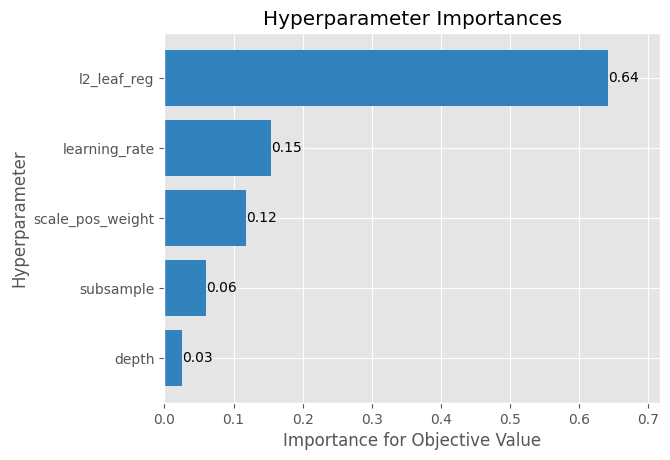

In [ ]:
from optuna.visualization.matplotlib import plot_param_importances
plot_param_importances(study)

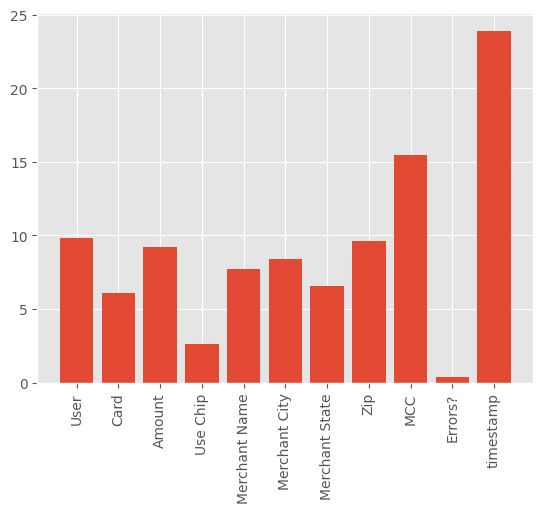

In [ ]:
feature_importance = modelGB.get_feature_importance()

feature_names = x_train.columns

plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(range(len(feature_importance)), feature_names, rotation=90)
plt.show()

In [ ]:
import pickle 
filename = 'model2.pkl' 
pickle.dump(modelGB, open(filename, 'wb'))

In [ ]:
x_train_con = np.concatenate((x_train, x_valid))
y_train_con = np.concatenate((y_train, y_valid))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from tqdm.autonotebook import tqdm

<ipython-input-12-60924369628f>:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
x_tensor_train = torch.tensor(x_train_norm, dtype=torch.float32)
y_tensor_train = torch.tensor(y_train, dtype=torch.long)

dataset = TensorDataset(x_tensor_train, y_tensor_train)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
x_tensor_test = torch.tensor(x_test_norm, dtype=torch.float32)
y_tensor_test = torch.tensor(y_test.values, dtype=torch.long)

dataset_test = TensorDataset(x_tensor_test, y_tensor_test)

dataloader_test = DataLoader(dataset_test, batch_size=32)

In [ ]:
print(x_tensor_train.shape)  
print(y_tensor_train.shape)

print(x_tensor_test.shape)  
print(y_tensor_test.shape)

torch.Size([4800000, 11])
torch.Size([4800000])
torch.Size([1200000, 11])
torch.Size([1200000])


In [ ]:
class classifierNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.flat=nn.Flatten()
    self.linear1=nn.Linear(11,6)
    self.linear2=nn.Linear(6,3)
    self.linear3=nn.Linear(3,2)
    self.act=nn.ReLU()

  def forward(self,x):
    out=self.flat(x)
    out=self.linear1(out)
    out=self.act(out)
    out=self.linear2(out)
    out=self.act(out)
    out=self.linear3(out)

    return out  

In [ ]:
modelNN=classifierNN()

In [ ]:
loss_fn=nn.BCEWithLogitsLoss()

In [ ]:
optimizer = torch.optim.Adam(modelNN.parameters(), lr=3e-3)

In [ ]:
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelNN.to(device)

for epoch in range(num_epochs):
    modelNN.train()
    for batch_idx, (data, target) in enumerate(dataloader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = modelNN(data)

        target_one_hot = torch.nn.functional.one_hot(torch.tensor(target), num_classes=2)

        loss = loss_fn(output, target_one_hot.float())

        loss.backward()

        optimizer.step()

    modelNN.eval()
    with torch.no_grad():
        test_preds = []
        test_targets = []
        for data_test, target_test in dataloader_test:
            data_test, target_test = data_test.to(device), target_test.to(device)

            output = modelNN(data_test)

            preds = torch.argmax(output, dim=1)
            test_preds += preds.flatten().tolist()
            test_targets += target_test.flatten().tolist()

        f1 = f1_score(test_targets, test_preds)
        precision = precision_score(test_targets, test_preds)
        recall = recall_score(test_targets, test_preds)

        print(f"Epoch {epoch}: F1 score: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

<ipython-input-24-37191287820f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_one_hot = torch.nn.functional.one_hot(torch.tensor(target), num_classes=2)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 0: F1 score: 0.000, Precision: 0.000, Recall: 0.000


<ipython-input-24-37191287820f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_one_hot = torch.nn.functional.one_hot(torch.tensor(target), num_classes=2)


Epoch 1: F1 score: 0.244, Precision: 0.774, Recall: 0.145


<ipython-input-24-37191287820f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_one_hot = torch.nn.functional.one_hot(torch.tensor(target), num_classes=2)


Epoch 2: F1 score: 0.331, Precision: 0.817, Recall: 0.208


<ipython-input-24-37191287820f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_one_hot = torch.nn.functional.one_hot(torch.tensor(target), num_classes=2)


Epoch 3: F1 score: 0.323, Precision: 0.770, Recall: 0.204


<ipython-input-24-37191287820f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_one_hot = torch.nn.functional.one_hot(torch.tensor(target), num_classes=2)


Epoch 4: F1 score: 0.285, Precision: 0.875, Recall: 0.170


<ipython-input-24-37191287820f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_one_hot = torch.nn.functional.one_hot(torch.tensor(target), num_classes=2)


Epoch 5: F1 score: 0.288, Precision: 0.895, Recall: 0.172


<ipython-input-24-37191287820f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_one_hot = torch.nn.functional.one_hot(torch.tensor(target), num_classes=2)


Epoch 6: F1 score: 0.323, Precision: 0.847, Recall: 0.200


<ipython-input-24-37191287820f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_one_hot = torch.nn.functional.one_hot(torch.tensor(target), num_classes=2)


Epoch 7: F1 score: 0.321, Precision: 0.877, Recall: 0.197


<ipython-input-24-37191287820f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_one_hot = torch.nn.functional.one_hot(torch.tensor(target), num_classes=2)


Epoch 8: F1 score: 0.252, Precision: 0.933, Recall: 0.146


<ipython-input-24-37191287820f>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_one_hot = torch.nn.functional.one_hot(torch.tensor(target), num_classes=2)


Epoch 9: F1 score: 0.283, Precision: 0.612, Recall: 0.184


In [ ]:
print(len(test_preds))
print(len(test_targets))


4800000
4800000


In [ ]:
print(test_preds[7])
print(test_targets[7])

0
0


In [ ]:
loss

tensor(0.0011, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
count = 0
for item in test_targets:
    if item == 1:
        count += 1
print(count)

5619


In [ ]:
len(dataloader_test)

150000

In [ ]:
print(target_one_hot.shape)

torch.Size([32, 2])
